<span>
<b>Authors:</b> 
<a href="http://------">Ornela Danushi </a>
<a href="http://------">Gerlando Gramaglia </a>
<a href="http://------">Domenico Profumo </a><br/>
<b>Python version:</b>  3.x<br/>
</span>

# Import library

In [1]:
import time

import statistics 
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.stats import randint as sp_randint
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import scikitplot as skplt

#confusion matrix
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay


import graphviz
from sklearn.tree import export_graphviz

In [2]:
#import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)


### Adding player's rank on tennis player's profile
Since in table of players created, there are no one attributes related to rank, the dataset of tennis matched is used to retrieve players' rank and for each of them add its mean

In [3]:
df = pd.read_csv("dataset/tennis_players.csv", skipinitialspace=True, sep=',', index_col=0)

In [4]:
df_rank = pd.read_csv('../Task1/dataset/matches_datacleaning.csv', index_col = 0)
pd.set_option('display.max_columns', None) # to visualize all the columns

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
winner_rank = df_rank[['winner_name', 'winner_rank']]
winner_rank.set_axis(['name', 'rank'], axis=1, inplace=True)

loser_rank = df_rank[['loser_name', 'loser_rank']]
loser_rank.set_axis(['name', 'rank'], axis=1, inplace=True)

player_rank = loser_rank.append(winner_rank)
player = df[['name']]
player = pd.merge(player, player_rank, how='left', on='name')

In [6]:
player = player.groupby('name').mean()
player['rank']=player['rank'].round(0)
player['rank'].describe()

count    2079.000000
mean      496.550746
std       333.184933
min         3.000000
25%       243.000000
50%       428.000000
75%       696.500000
max      1908.000000
Name: rank, dtype: float64

count the players without rank

In [7]:
player.isna().sum()

rank    41
dtype: int64

In [8]:
player.reset_index(inplace = True)
player

name    rank
0                 AARON ADDISON  1131.0
1                   ABBIE MYERS   475.0
2     ABHINAV SANJEEV SHANMUGAM  1233.0
3           ABIGAIL TERE APISAH   422.0
4                ABIR EL FAHIMI     NaN
...                         ...     ...
2115                ZIZOU BERGS   369.0
2116                  ZOE HIVES   319.0
2117                 ZOE KRUGER   750.0
2118              ZSOMBOR PIROS   453.0
2119            ZUZANA ZLOCHOVA   461.0

[2120 rows x 2 columns]

In [9]:
df = pd.merge(df, player, how='left', on='name')
df.describe()

num_matches        ratio  ratio_2016-2019  num_matches_2020-2021  \
count  2120.000000  2120.000000      2120.000000            2120.000000   
mean    125.892453    48.145441        47.308430              23.863679   
std      98.550168    12.089893        13.943840              27.020238   
min      11.000000     4.166667         0.000000               0.000000   
25%      34.000000    41.882363        41.078328               0.000000   
50%     100.000000    50.000000        50.000000              11.000000   
75%     208.000000    56.160661        56.352814              46.000000   
max     387.000000    85.250737       100.000000             108.000000   

       ratio_2020-2021        birth           ht      minutes     perc_ace  \
count      2120.000000  2120.000000  2120.000000  2120.000000  2120.000000   
mean         30.619122  1993.779245   179.207650    80.938008     6.727476   
std          26.477303     5.111969     8.134681    16.400592     5.464472   
min           0.000000  1973.000000   155.000000    40.000000     0.000000   
25%           0.000000  1990.000000   173.000000    62.789282     2.390000   
50%          37.066906  1994.000000   178.000000    82.647443     5.705000   
75%          53.077168  1998.000000   185.705882    94.781937     9.792500   
max         100.000000  2006.000000   211.000000   132.724084    40.000000   

       _1stwon_1stIn      perc_df  perc_2ndwon   perc_v_ace    perc_v_df  \
count    2120.000000  2120.000000  2120.000000  2120.000000  2120.000000   
mean       57.332763     7.546972    42.933934     6.764241     6.386939   
std        17.035407     3.591227    12.249540     4.649582     1.990824   
min         3.234105     0.000000     0.000000     0.070000     0.000000   
25%        53.724864     5.220000    40.532500     2.547500     5.420000   
50%        63.567684     6.995000    47.150000     6.165000     6.610000   
75%        68.723107     9.252500    50.000000    10.400000     7.590000   
max        82.386560    29.930000    94.180000    23.170000    17.890000   

       perc_v_1stwon         rank  
count    2120.000000  2079.000000  
mean       53.913325   496.550746  
std        19.585296   333.184933  
min         0.910000     3.000000  
25%        37.820000   243.000000  
50%        64.400000   428.000000  
75%        69.700000   696.500000  
max        81.880000  1908.000000

## Transform categorical features into numerical ones

In [10]:
#function to discretize the variables
#input: the dataset and the list of variables' names to discretize
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [11]:
#discretize the categorical variables
variables = ['hand', 'gender', 'ioc']
df = discretize_data(df, variables)

In [12]:
#drop the categorical variables since we don't need them anymore 
df.drop(columns=['name','hand', 'gender', 'ioc'], axis=1,inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2120 entries, 0 to 2119
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_matches            2120 non-null   int64  
 1   ratio                  2120 non-null   float64
 2   ratio_2016-2019        2120 non-null   float64
 3   num_matches_2020-2021  2120 non-null   float64
 4   ratio_2020-2021        2120 non-null   float64
 5   birth                  2120 non-null   float64
 6   ht                     2120 non-null   float64
 7   minutes                2120 non-null   float64
 8   perc_ace               2120 non-null   float64
 9   _1stwon_1stIn          2120 non-null   float64
 10  perc_df                2120 non-null   float64
 11  perc_2ndwon            2120 non-null   float64
 12  perc_v_ace             2120 non-null   float64
 13  perc_v_df              2120 non-null   float64
 14  perc_v_1stwon          2120 non-null   float64
 15  rank

### Write to csv before classification

In [14]:
df.to_csv('dataset/players_classification.csv')

## Labels
First of all is necessary to assign a label to each player according to the rank. So, it's important to decide a threashold by which a player can be classified such as 0 or 1. The threashold identifies that the 25% of players with best rank are labeled as 0 and the remaining ones as 1. The players without a rank are removed and their label is calculated with the models obtained.

In [15]:
df = df.sort_values(by=['rank']).copy()

In [16]:
df

num_matches      ratio  ratio_2016-2019  num_matches_2020-2021  \
1651          314  83.439490        84.063745                   63.0   
1525          339  85.250737        84.000000                   89.0   
1823          293  74.061433        73.684211                   46.0   
1707          229  82.969432        84.210526                   20.0   
1045          348  69.827586        71.071429                   68.0   
...           ...        ...              ...                    ...   
1812           16   6.250000         6.666667                    1.0   
1874           16  50.000000        50.000000                    0.0   
1907           23  39.130435        39.130435                    0.0   
1937           24   4.166667         4.166667                    0.0   
1982           35  34.285714        25.000000                   19.0   

      ratio_2020-2021   birth          ht     minutes  perc_ace  \
1651        80.952381  1986.0  185.000000  128.560922      7.25   
1525        88.764045  1987.0  188.000000  121.779204     10.34   
1823        76.086957  1991.0  168.000000   89.320671      4.20   
1707        70.000000  1981.0  185.000000  114.490553     17.45   
1045        64.705882  1992.0  184.000000   96.256908     15.73   
...               ...     ...         ...         ...       ...   
1812         0.000000  1993.0  168.000000   59.866667      0.17   
1874         0.000000  1994.0  173.363636   59.750000      0.00   
1907         0.000000  1994.0  172.137868   76.420635      0.75   
1937         0.000000  1981.0  191.142857  104.521739      7.78   
1982        42.105263  2000.0  165.000000   60.239130      0.00   

      _1stwon_1stIn  perc_df  perc_2ndwon  perc_v_ace  perc_v_df  \
1651      72.752799     3.77        57.67       12.01       5.74   
1525      74.216409     4.90        54.86       10.90       5.97   
1823      64.033508     5.47        47.88        4.45       7.11   
1707      78.359655     3.40        58.37       10.95       5.59   
1045      71.493825     7.82        45.45        7.39       8.47   
...             ...      ...          ...         ...        ...   
1812      22.682119     9.77        36.69        1.06       4.09   
1874      13.067151     5.81        13.16        1.44       2.89   
1907      52.136752    11.65        42.18        1.68       8.79   
1937      66.836735    21.81        41.01       12.75      12.05   
1982      21.160651     8.14        26.14        0.07       0.07   

      perc_v_1stwon  rank  hand_num  gender_num  ioc_num  
1651          64.40   3.0         0           1       26  
1525          65.08   3.0         1           1       78  
1823          58.31   3.0         1           0       71  
1707          67.99   4.0         1           1       80  
1045          63.61   7.0         1           0       20  
...             ...   ...       ...         ...      ...  
1812          29.39   NaN         1           0       84  
1874          11.19   NaN         2           0       29  
1907          28.04   NaN         2           0       52  
1937          74.97   NaN         1           1       68  
1982           0.91   NaN         2           0        4  

[2120 rows x 19 columns]

In [17]:
quantile_a = df['rank'].quantile(0.25)

In [18]:
blindtest=df[df['rank'].isna()]
del blindtest['rank']

In [19]:
df = df.drop(df[df['rank'].isna()].index)

In [20]:
labels = []
for index, rank in df['rank'].items():
    if rank <= quantile_a:
        labels.append(0)
    else:
        labels.append(1)

In [21]:
class_names = ['high-level', 'low-level']

In [22]:
classes = pd.DataFrame()
classes['labels'] = labels
classes.labels.value_counts(True)

1    0.748437
0    0.251563
Name: labels, dtype: float64

### Prepare dataset (splitting)
use stratify because database contain unbalanced label, in this way it's possible to mantain this percentage 
of label in train and test set 

In [23]:
del df['rank']
train_set, test_set, train_label, test_label = train_test_split(df, labels, stratify=labels, test_size=0.25)

# Classification 

Nine methods are used, for each of them are reported the classification report, confusion matrix and ROC curve. The methods are:

**Tree-based classifiers**
- Decision Tree

**Naive Bayes classifiers**
- Bayesian classifier

**Machine Learning classifiers**
- Neural Network

**Neighbors-based classifiers**
- KNN
- Radius-Neighbors 

**Support Vector Machine**
- SVM

**Rule based classifiers**
- Rule based

**Ensemble Method**
- AdaBoosting
- Random forest

# Function for print report, ROC, confusion matrix

In [24]:
def print_all(models, training , training_pred, test, test_pred, roc="yes"):
    #print all classification report
    print("TRAINING:\n",classification_report(train_label, training_pred, target_names=class_names))
    print("TEST:\n",classification_report(test_label, test_pred, target_names=class_names))
    
    #plot confusion matrix
    cm = confusion_matrix(test_label, test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    
    #plot ROC
    if(roc=="yes"):
        test_pred_proba = models.predict_proba(test)
        skplt.metrics.plot_roc(test_label, test_pred_proba)

## Decision Tree
A grid search is implemented and the best model is decided according to f1_score

In [25]:
from sklearn import tree
from sklearn.metrics import classification_report
import pydotplus 
from IPython.display import Image

In [26]:
dt_max_depth = [2,3,5,6,7,10,12,None]
dt_min_samples_split = sp_randint(2, 51)
min_samples_leaf = sp_randint(1, 51)
criterion = ["entropy", "gini"]
splitter = ["best", "random"]
max_features = [None, 2, 3, 4, 5]

dt_param_grid = {
    "max_depth": dt_max_depth,
    "min_samples_split": dt_min_samples_split.rvs(5),
    "min_samples_leaf": min_samples_leaf.rvs(5),
    "criterion": criterion,
    "splitter": splitter,
    "max_features": max_features,
    "class_weight":[None, {0: 0.65, 1: 0.25}]
    }


dt_grid = GridSearchCV(tree.DecisionTreeClassifier(), param_grid=dt_param_grid, n_jobs=-1,
                            scoring=make_scorer(f1_score))

In [27]:
best_model = dt_grid.fit(train_set, train_label)
print(dt_grid.best_params_)
train_pred_dt = dt_grid.predict(train_set)
test_pred_dt = dt_grid.predict(test_set)

{'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 9, 'splitter': 'random'}


In [28]:
dot_data = export_graphviz(best_model.best_estimator_, out_file=None, 
            filled=True, rounded=True, class_names=['0','1'])

In [29]:
graph = pydotplus.graph_from_dot_data(dot_data)
print(graph.to_string())
#Image(graph.create_png())


digraph Tree {
node [color="black", fontname="helvetica", shape=box, style="filled, rounded"];
edge [fontname="helvetica"];
0 [fillcolor="#7cbeee", label="X[0] <= 217.649\nentropy = 0.814\nsamples = 1559\nvalue = [392, 1167]\nclass = 1"];
1 [fillcolor="#52aae8", label="X[7] <= 65.667\nentropy = 0.512\nsamples = 1194\nvalue = [136, 1058]\nclass = 1"];
0 -> 1  [headlabel="True", labelangle=45, labeldistance="2.5"];
2 [fillcolor="#3a9de5", label="X[15] <= 1.529\nentropy = 0.044\nsamples = 416\nvalue = [2, 414]\nclass = 1"];
1 -> 2;
3 [fillcolor="#3b9ee5", label="X[13] <= 6.278\nentropy = 0.072\nsamples = 231\nvalue = [2, 229]\nclass = 1"];
2 -> 3;
4 [fillcolor="#399de5", label="entropy = 0.0\nsamples = 199\nvalue = [0, 199]\nclass = 1"];
3 -> 4;
5 [fillcolor="#46a4e7", label="X[3] <= 20.829\nentropy = 0.337\nsamples = 32\nvalue = [2, 30]\nclass = 1"];
3 -> 5;
6 [fillcolor="#4da7e8", label="X[0] <= 89.795\nentropy = 0.439\nsamples = 22\nvalue = [2, 20]\nclass = 1"];
5 -> 6;
7 [fillcolor="#

### Evaluation of the decision tree

TRAINING:
               precision    recall  f1-score   support

  high-level       0.89      0.84      0.87       392
   low-level       0.95      0.96      0.96      1167

    accuracy                           0.93      1559
   macro avg       0.92      0.90      0.91      1559
weighted avg       0.93      0.93      0.93      1559

TEST:
               precision    recall  f1-score   support

  high-level       0.87      0.84      0.86       131
   low-level       0.95      0.96      0.95       389

    accuracy                           0.93       520
   macro avg       0.91      0.90      0.90       520
weighted avg       0.93      0.93      0.93       520



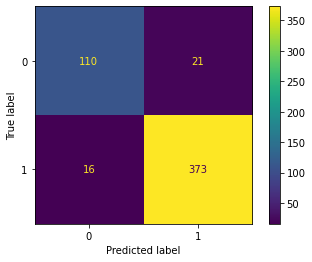

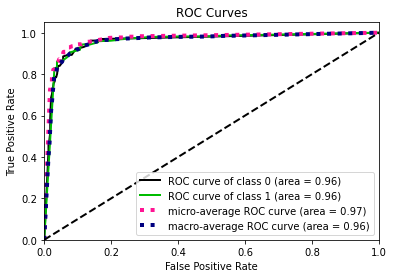

In [30]:
print_all(dt_grid,train_set,train_pred_dt,test_set,test_pred_dt)

## Bayesian classifier

In [31]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB

In [32]:
gnb = GaussianNB()
gnb.fit(train_set, train_label)
train_pred_gnb = gnb.predict(train_set)
test_pred_gnb = gnb.predict(test_set)

### Evaluation of bayesian classifier

TRAINING:
               precision    recall  f1-score   support

  high-level       0.63      0.90      0.74       392
   low-level       0.96      0.82      0.89      1167

    accuracy                           0.84      1559
   macro avg       0.80      0.86      0.81      1559
weighted avg       0.88      0.84      0.85      1559

TEST:
               precision    recall  f1-score   support

  high-level       0.60      0.89      0.72       131
   low-level       0.96      0.80      0.87       389

    accuracy                           0.82       520
   macro avg       0.78      0.85      0.80       520
weighted avg       0.87      0.82      0.83       520



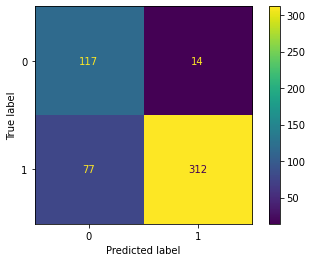

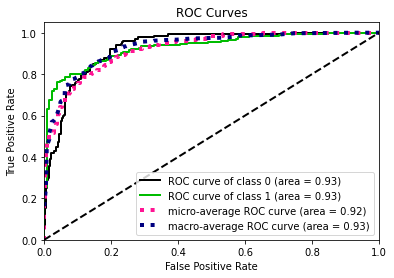

In [33]:
print_all(gnb,train_set,train_pred_gnb,test_set,test_pred_gnb)

## Neural Network
A neural network is created with a specific method. It has always a single hidden layer and an output layer with only one neuron. It's possible to set the number of neurons, activation functions of both hidden and output layer and the loss. Again a grid search is implemented to find the best configuration according to accuracy.

In [64]:
import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

Init Plugin
Init Graph Optimizer
Init Kernel


In [65]:
def create_model(n_input, n_neurons1, activation1, optimizer, activation_out, loss): 
    #create model
    model = Sequential()
    model.add(Dense(n_neurons1, kernel_initializer='uniform', input_dim=n_input, activation=activation1)) 
    model.add(Dense(1,  kernel_initializer='uniform', activation=activation_out))
    #Compile model
    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
    return model

In [66]:
grid_param = {
    "n_input": [len(df.columns)],
    "n_neurons1":[5,7,20,12],
    "activation1":["relu","sigmoidal","tanh"],
    "optimizer": ['adam'],
    "activation_out":["linear"],
    "loss":["mean_squared_error","binary_crossentropy"]
}

nn = KerasClassifier(build_fn=create_model, epochs=150, batch_size=32)
nn_grid = GridSearchCV(nn, param_grid=grid_param, n_jobs=-1, cv=8, scoring=make_scorer(f1_score))

In [67]:
start = time.time()
best_model = nn_grid.fit(train_set, train_label)
print(nn_grid.best_params_)
train_pred_nn = nn_grid.predict(train_set)
test_pred_nn = nn_grid.predict(test_set)
print('Time taken for fit: {} sec\n'.format(time.time() - start))

Init Plugin
Init Graph Optimizer
Init Kernel
Init Plugin
Init Graph Optimizer
Init Kernel
Init Plugin
Init Graph Optimizer
Init Kernel
Metal device set to: Apple M1
Metal device set to: Apple M1
Init Plugin
Init Graph Optimizer
Init Kernel
Metal device set to: Apple M1


2022-01-05 20:00:16.823188: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-05 20:00:16.823239: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-05 20:00:16.840677: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-01-05 20:00:16.840677: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL,

Init Plugin
Init Graph Optimizer
Init Kernel
Init Plugin
Init Graph Optimizer
Init Kernel
Metal device set to: Apple M1
Init Plugin
Init Graph Optimizer
Init Kernel
Metal device set to: Apple M1
Metal device set to: Apple M1
Init Plugin
Init Graph Optimizer
Init Kernel
Metal device set to: Apple M1
Metal device set to: Apple M1


2022-01-05 20:00:17.075613: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-05 20:00:17.076448: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-01-05 20:00:17.104917: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-05 20:00:17.105207: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL,

Epoch 1/150
43/43 [==============================] - 2s 20ms/step - loss: 2.6910 - accuracy: 0.7023
Epoch 2/150
43/43 [==============================] - 2s 22ms/step - loss: 0.2709 - accuracy: 0.6474
Epoch 2/150
43/43 [==============================] - 2s 22ms/step - loss: 0.2042 - accuracy: 0.7412
Epoch 2/150
43/43 [==============================] - 1s 14ms/step - loss: 0.1779 - accuracy: 0.7485
Epoch 3/150
43/43 [==============================] - 1s 18ms/step - loss: 0.2221 - accuracy: 0.6444
Epoch 3/150
43/43 [==============================] - 1s 19ms/step - loss: 0.1946 - accuracy: 0.7214
Epoch 3/150
43/43 [==============================] - 1s 18ms/step - loss: 0.1819 - accuracy: 0.7419
Epoch 4/150
43/43 [==============================] - 1s 21ms/step - loss: 0.1493 - accuracy: 0.7617
Epoch 4/150
43/43 [==============================] - 1s 18ms/step - loss: 0.1438 - accuracy: 0.7683
Epoch 4/150
43/43 [==============================] - 1s 18ms/step - loss: 0.1251 - accuracy: 0.8145


43/43 [==============================] - 1s 21ms/step - loss: 0.1028 - accuracy: 0.8592
Epoch 8/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0997 - accuracy: 0.8805
Epoch 8/150
43/43 [==============================] - 1s 20ms/step - loss: 0.1375 - accuracy: 0.7999
Epoch 9/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0978 - accuracy: 0.8937
Epoch 9/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0972 - accuracy: 0.8776
Epoch 9/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0881 - accuracy: 0.8915
Epoch 9/150
43/43 [==============================] - 1s 17ms/step - loss: 0.1271 - accuracy: 0.8306
Epoch 10/150
43/43 [==============================] - 1s 20ms/step - loss: 0.0865 - accuracy: 0.8930
Epoch 10/150
43/43 [==============================] - 1s 21ms/step - loss: 0.1327 - accuracy: 0.8065
Epoch 11/150
43/43 [==============================] - 1s 21ms/step - loss: 0.1270 - accuracy: 0.8152
Epoch 12/

43/43 [==============================] - 1s 22ms/step - loss: 0.1182 - accuracy: 0.8563
Epoch 14/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0964 - accuracy: 0.8850
Epoch 16/150
43/43 [==============================] - 1s 19ms/step - loss: 0.0881 - accuracy: 0.8842
Epoch 18/150
43/43 [==============================] - 1s 23ms/step - loss: 0.1078 - accuracy: 0.8688
Epoch 19/150
43/43 [==============================] - 1s 21ms/step - loss: 0.1051 - accuracy: 0.8790
Epoch 20/150
17/43 [==========>...................] - ETA: 0s - loss: 0.0956 - accuracy: 0.8952Epoch 20/150


43/43 [==============================] - 1s 23ms/step - loss: 0.0779 - accuracy: 0.9010
Epoch 20/150
43/43 [==============================] - 1s 20ms/step - loss: 0.0970 - accuracy: 0.8893
Epoch 23/150
43/43 [==============================] - 1s 20ms/step - loss: 0.0913 - accuracy: 0.8988
Epoch 23/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0996 - accuracy: 0.8821
Epoch 24/150
43/43 [==============================] - 1s 20ms/step - loss: 0.1049 - accuracy: 0.8710
Epoch 24/150
43/43 [==============================] - 1s 20ms/step - loss: 0.0888 - accuracy: 0.8988
Epoch 24/150
43/43 [==============================] - 1s 18ms/step - loss: 0.0990 - accuracy: 0.8893
Epoch 25/150
43/43 [==============================] - 1s 20ms/step - loss: 0.0940 - accuracy: 0.8952
Epoch 25/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0905 - accuracy: 0.9040
Epoch 25/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0981 - accuracy: 0.8886
Epo

43/43 [==============================] - 1s 21ms/step - loss: 0.0728 - accuracy: 0.9098
Epoch 27/150
43/43 [==============================] - 1s 20ms/step - loss: 0.0909 - accuracy: 0.8930
Epoch 26/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0893 - accuracy: 0.8974
Epoch 27/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0990 - accuracy: 0.8952
Epoch 28/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0772 - accuracy: 0.9076
Epoch 28/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0968 - accuracy: 0.8930
Epoch 29/150
43/43 [==============================] - 1s 20ms/step - loss: 0.0734 - accuracy: 0.9113
Epoch 29/150
43/43 [==============================] - 1s 20ms/step - loss: 0.0914 - accuracy: 0.8952
Epoch 30/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0786 - accuracy: 0.9047
Epoch 30/150
43/43 [==============================] - 1s 20ms/step - loss: 0.0922 - accuracy: 0.8937
Epo

43/43 [==============================] - 1s 21ms/step - loss: 0.0972 - accuracy: 0.8930
Epoch 33/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0961 - accuracy: 0.8908
Epoch 33/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0949 - accuracy: 0.8930
Epoch 34/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0966 - accuracy: 0.8966
Epoch 34/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0958 - accuracy: 0.8945
Epoch 36/150
43/43 [==============================] - 1s 18ms/step - loss: 0.0963 - accuracy: 0.8966
Epoch 36/150
43/43 [==============================] - 1s 18ms/step - loss: 0.0767 - accuracy: 0.9091
Epoch 37/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0870 - accuracy: 0.8996
Epoch 37/150
43/43 [==============================] - 1s 19ms/step - loss: 0.0697 - accuracy: 0.9179
Epoch 38/150
43/43 [==============================] - 1s 32ms/step - loss: 0.0739 - accuracy: 0.9113
Epo

43/43 [==============================] - 1s 26ms/step - loss: 0.0925 - accuracy: 0.9018
Epoch 40/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0841 - accuracy: 0.9054
Epoch 40/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0919 - accuracy: 0.8930
Epoch 41/150
43/43 [==============================] - 1s 19ms/step - loss: 0.0953 - accuracy: 0.8944
Epoch 42/150
43/43 [==============================] - 1s 19ms/step - loss: 0.0921 - accuracy: 0.8952
Epoch 41/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0714 - accuracy: 0.9172
Epoch 42/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0915 - accuracy: 0.8988
Epoch 42/150
43/43 [==============================] - 1s 19ms/step - loss: 0.0953 - accuracy: 0.8959
Epoch 43/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0950 - accuracy: 0.9032
Epoch 44/150
 4/43 [=>............................] - ETA: 0s - loss: 0.0743 - accuracy: 0.9062Epoch 45/

43/43 [==============================] - 1s 20ms/step - loss: 0.0795 - accuracy: 0.9084
Epoch 45/150
43/43 [==============================] - 1s 20ms/step - loss: 0.0948 - accuracy: 0.8915
Epoch 46/150
43/43 [==============================] - 1s 20ms/step - loss: 0.0944 - accuracy: 0.8988
Epoch 48/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0881 - accuracy: 0.9010
Epoch 48/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0891 - accuracy: 0.9047
Epoch 49/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0973 - accuracy: 0.8893
Epoch 48/150
43/43 [==============================] - 1s 20ms/step - loss: 0.0653 - accuracy: 0.9216
Epoch 49/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0868 - accuracy: 0.9011
Epoch 49/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0946 - accuracy: 0.8930
Epoch 49/150
43/43 [==============================] - 1s 20ms/step - loss: 0.0941 - accuracy: 0.8996
Epo

43/43 [==============================] - 1s 22ms/step - loss: 0.0949 - accuracy: 0.8930
Epoch 52/150
43/43 [==============================] - 1s 19ms/step - loss: 0.0739 - accuracy: 0.9076
Epoch 52/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0755 - accuracy: 0.9047
Epoch 53/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0924 - accuracy: 0.9062
Epoch 54/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0885 - accuracy: 0.8974
Epoch 54/150
43/43 [==============================] - 1s 20ms/step - loss: 0.0897 - accuracy: 0.9003
Epoch 55/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0734 - accuracy: 0.9069
Epoch 55/150
43/43 [==============================] - 1s 20ms/step - loss: 0.0650 - accuracy: 0.9223
Epoch 56/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0947 - accuracy: 0.8915
Epoch 57/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0708 - accuracy: 0.9157
Epo

43/43 [==============================] - 1s 23ms/step - loss: 0.0867 - accuracy: 0.9069
Epoch 57/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0721 - accuracy: 0.9106
Epoch 58/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0650 - accuracy: 0.9179
Epoch 60/150
43/43 [==============================] - 1s 20ms/step - loss: 0.0750 - accuracy: 0.9047
Epoch 60/150
43/43 [==============================] - 1s 20ms/step - loss: 0.0822 - accuracy: 0.8996
Epoch 60/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0927 - accuracy: 0.9010
Epoch 60/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0851 - accuracy: 0.9032
Epoch 61/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0939 - accuracy: 0.8952
Epoch 63/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0914 - accuracy: 0.8981
Epoch 63/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0848 - accuracy: 0.9047
Epo

43/43 [==============================] - 1s 22ms/step - loss: 0.0910 - accuracy: 0.9040
Epoch 64/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0689 - accuracy: 0.9157
Epoch 65/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0660 - accuracy: 0.9186
Epoch 66/150
43/43 [==============================] - 1s 19ms/step - loss: 0.0708 - accuracy: 0.9128
Epoch 67/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0663 - accuracy: 0.9186
Epoch 68/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0807 - accuracy: 0.8967
Epoch 69/150
43/43 [==============================] - 1s 20ms/step - loss: 0.0730 - accuracy: 0.9091
Epoch 70/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0825 - accuracy: 0.9120


43/43 [==============================] - 1s 23ms/step - loss: 0.0755 - accuracy: 0.9054
Epoch 72/150
43/43 [==============================] - 1s 19ms/step - loss: 0.0806 - accuracy: 0.9069
Epoch 71/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0904 - accuracy: 0.8974
Epoch 72/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0726 - accuracy: 0.9186
Epoch 73/150
43/43 [==============================] - 1s 20ms/step - loss: 0.0808 - accuracy: 0.9076
Epoch 72/150
43/43 [==============================] - 1s 20ms/step - loss: 0.0798 - accuracy: 0.9120
Epoch 74/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0900 - accuracy: 0.9010
Epoch 74/150
43/43 [==============================] - 1s 19ms/step - loss: 0.0879 - accuracy: 0.9047
Epoch 74/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0718 - accuracy: 0.9062
Epoch 75/150
43/43 [==============================] - 1s 20ms/step - loss: 0.0936 - accuracy: 0.8959


43/43 [==============================] - 1s 20ms/step - loss: 0.0698 - accuracy: 0.9150
Epoch 77/150
43/43 [==============================] - 1s 19ms/step - loss: 0.0710 - accuracy: 0.9077
Epoch 77/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0636 - accuracy: 0.9238
Epoch 77/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0661 - accuracy: 0.9120
Epoch 78/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0740 - accuracy: 0.9048
Epoch 78/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0741 - accuracy: 0.9091
Epoch 78/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0802 - accuracy: 0.9091
Epoch 80/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0771 - accuracy: 0.9018
Epoch 80/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0929 - accuracy: 0.9003
Epoch 80/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0911 - accuracy: 0.8988
Epo

43/43 [==============================] - 1s 24ms/step - loss: 0.0658 - accuracy: 0.9142
Epoch 84/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0734 - accuracy: 0.9121
Epoch 84/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0758 - accuracy: 0.9098
Epoch 84/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0705 - accuracy: 0.9157
Epoch 84/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0900 - accuracy: 0.9091
Epoch 84/150
43/43 [==============================] - 1s 20ms/step - loss: 0.0660 - accuracy: 0.9157
Epoch 84/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0660 - accuracy: 0.9142
Epoch 87/150
43/43 [==============================] - 1s 19ms/step - loss: 0.0623 - accuracy: 0.9238
Epoch 87/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0892 - accuracy: 0.9032
Epoch 88/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0665 - accuracy: 0.9135
Epo

43/43 [==============================] - 1s 24ms/step - loss: 0.0775 - accuracy: 0.9084
Epoch 88/150
43/43 [==============================] - 1s 19ms/step - loss: 0.0727 - accuracy: 0.9135
Epoch 89/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0744 - accuracy: 0.9054
Epoch 89/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0665 - accuracy: 0.9150
Epoch 90/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0909 - accuracy: 0.9040
Epoch 91/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0651 - accuracy: 0.9194
Epoch 92/150
43/43 [==============================] - 1s 19ms/step - loss: 0.0716 - accuracy: 0.9055
Epoch 92/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0671 - accuracy: 0.9114
Epoch 93/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0917 - accuracy: 0.8944
Epoch 94/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0634 - accuracy: 0.9230
Epo

43/43 [==============================] - 1s 22ms/step - loss: 0.0755 - accuracy: 0.9128
Epoch 95/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0897 - accuracy: 0.9120
Epoch 97/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0785 - accuracy: 0.9018
Epoch 97/150
43/43 [==============================] - 1s 18ms/step - loss: 0.0831 - accuracy: 0.9076
Epoch 97/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0675 - accuracy: 0.9194
Epoch 97/150
43/43 [==============================] - 1s 20ms/step - loss: 0.0893 - accuracy: 0.9054
Epoch 99/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0682 - accuracy: 0.9150
Epoch 100/150
10/43 [=====>........................] - ETA: 0s - loss: 0.0821 - accuracy: 0.8906Epoch 101/150


43/43 [==============================] - 1s 23ms/step - loss: 0.0643 - accuracy: 0.9172
Epoch 101/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0864 - accuracy: 0.9047
Epoch 102/150
43/43 [==============================] - 1s 18ms/step - loss: 0.0673 - accuracy: 0.9186
Epoch 102/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0644 - accuracy: 0.9245
Epoch 103/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0833 - accuracy: 0.8944
Epoch 102/150
43/43 [==============================] - 1s 19ms/step - loss: 0.0883 - accuracy: 0.8944
Epoch 104/150
43/43 [==============================] - 1s 20ms/step - loss: 0.0757 - accuracy: 0.9084
Epoch 103/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0665 - accuracy: 0.9186
Epoch 104/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0636 - accuracy: 0.9120
Epoch 105/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0864 - accuracy: 0

43/43 [==============================] - 1s 20ms/step - loss: 0.0864 - accuracy: 0.9113
Epoch 108/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0772 - accuracy: 0.9076
Epoch 108/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0742 - accuracy: 0.9128
Epoch 109/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0682 - accuracy: 0.9098
Epoch 110/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0651 - accuracy: 0.9172
Epoch 110/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0632 - accuracy: 0.9304
Epoch 111/150
43/43 [==============================] - 1s 20ms/step - loss: 0.0628 - accuracy: 0.9164
Epoch 113/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0652 - accuracy: 0.9216
Epoch 113/150
27/43 [=================>............] - ETA: 0s - loss: 0.0833 - accuracy: 0.9109Epoch 114/150


43/43 [==============================] - 1s 23ms/step - loss: 0.0679 - accuracy: 0.9172
Epoch 114/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0642 - accuracy: 0.9120
Epoch 114/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0741 - accuracy: 0.9113
Epoch 114/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0860 - accuracy: 0.9113
Epoch 116/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0834 - accuracy: 0.9150
Epoch 117/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0658 - accuracy: 0.9282
Epoch 117/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0741 - accuracy: 0.9135
Epoch 118/150
42/43 [============================>.] - ETA: 0s - loss: 0.0620 - accuracy: 0.9286Epoch 119/150


43/43 [==============================] - 1s 23ms/step - loss: 0.0652 - accuracy: 0.9186
Epoch 120/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0737 - accuracy: 0.9098
Epoch 120/150
43/43 [==============================] - 1s 18ms/step - loss: 0.0863 - accuracy: 0.9091
Epoch 123/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0656 - accuracy: 0.9209
Epoch 124/150
43/43 [==============================] - 1s 19ms/step - loss: 0.0615 - accuracy: 0.9208
Epoch 124/150
43/43 [==============================] - 1s 20ms/step - loss: 0.0692 - accuracy: 0.9164
Epoch 124/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0615 - accuracy: 0.9245
Epoch 125/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0666 - accuracy: 0.9186
Epoch 125/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0877 - accuracy: 0.9076


43/43 [==============================] - 1s 24ms/step - loss: 0.0863 - accuracy: 0.9091
Epoch 127/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0632 - accuracy: 0.9289
Epoch 129/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0672 - accuracy: 0.9164
Epoch 129/150
14/43 [========>.....................] - ETA: 0s - loss: 0.0727 - accuracy: 0.9107Epoch 132/150


43/43 [==============================] - 1s 24ms/step - loss: 0.0700 - accuracy: 0.9128
Epoch 132/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0863 - accuracy: 0.9040
Epoch 133/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0887 - accuracy: 0.9018
Epoch 131/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0827 - accuracy: 0.9150
Epoch 133/150
43/43 [==============================] - 1s 18ms/step - loss: 0.0613 - accuracy: 0.9179
Epoch 133/150
43/43 [==============================] - 1s 19ms/step - loss: 0.0731 - accuracy: 0.9055
Epoch 133/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0864 - accuracy: 0.9025
Epoch 134/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0851 - accuracy: 0.9076
Epoch 133/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0737 - accuracy: 0.9113
Epoch 135/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0855 - accuracy: 0

43/43 [==============================] - 1s 24ms/step - loss: 0.0856 - accuracy: 0.9047
Epoch 139/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0879 - accuracy: 0.9069
Epoch 139/150
43/43 [==============================] - 1s 20ms/step - loss: 0.0741 - accuracy: 0.9113
Epoch 140/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0896 - accuracy: 0.8974
Epoch 138/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0760 - accuracy: 0.9135
Epoch 141/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0748 - accuracy: 0.9076
Epoch 141/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0641 - accuracy: 0.9164
Epoch 142/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0713 - accuracy: 0.9136
Epoch 142/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0618 - accuracy: 0.9194
Epoch 142/150
43/43 [==============================] - 1s 18ms/step - loss: 0.0643 - accuracy: 0

43/43 [==============================] - 1s 23ms/step - loss: 0.0822 - accuracy: 0.9128
Epoch 145/150
43/43 [==============================] - 1s 19ms/step - loss: 0.0852 - accuracy: 0.9069
Epoch 146/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0675 - accuracy: 0.9187
Epoch 146/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0853 - accuracy: 0.9128
Epoch 146/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0744 - accuracy: 0.9003
Epoch 149/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0745 - accuracy: 0.9040
Epoch 148/150
 5/43 [==>...........................] - ETA: 0s - loss: 0.0776 - accuracy: 0.9250

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 149/150
43/43 [==============================] - 1s 19ms/step - loss: 0.0846 - accuracy: 0.9106


/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")

41/43 [===========================>..] - ETA: 0s - loss: 0.0727 - accuracy: 0.9085

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 20:02:38.873691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 20:02:38.923813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 20:02:38.983368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Pl

43/43 [==============================] - 1s 21ms/step - loss: 0.0720 - accuracy: 0.9106
Epoch 150/150
 8/43 [====>.........................] - ETA: 0s - loss: 0.0714 - accuracy: 0.9141

2022-01-05 20:02:39.113711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


19/43 [============>.................] - ETA: 0s - loss: 0.0824 - accuracy: 0.9293

2022-01-05 20:02:39.321761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 19ms/step - loss: 0.0768 - accuracy: 0.9120


/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 20:02:39.968755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 6/43 [===>..........................] - ETA: 1s - loss: 0.0753 - accuracy: 0.9115

2022-01-05 20:02:39.981909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 20:02:39.994087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 20:02:40.012883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 20:02:40.015207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


24/43 [===============>..............] - ETA: 0s - loss: 0.0855 - accuracy: 0.9102

2022-01-05 20:02:40.248858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


18/43 [===========>..................] - ETA: 0s - loss: 4.9149 - accuracy: 0.4983

2022-01-05 20:02:40.544718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


38/43 [=========================>....] - ETA: 0s - loss: 3.0961 - accuracy: 0.3890

2022-01-05 20:02:41.039337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 2s 25ms/step - loss: 1.1318 - accuracy: 0.2427
Epoch 2/150
40/43 [==========================>...] - ETA: 0s - loss: 0.1833 - accuracy: 0.7469

2022-01-05 20:02:41.779052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 21ms/step - loss: 0.2164 - accuracy: 0.6635
Epoch 3/150
43/43 [==============================] - 1s 22ms/step - loss: 0.6808 - accuracy: 0.2427
Epoch 3/150
43/43 [==============================] - 1s 19ms/step - loss: 0.6322 - accuracy: 0.2427
Epoch 4/150
32/43 [=====================>........] - ETA: 0s - loss: 0.1120 - accuracy: 0.8662

2022-01-05 20:02:43.519719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 20ms/step - loss: 0.1118 - accuracy: 0.8622
Epoch 5/150
43/43 [==============================] - 1s 20ms/step - loss: 0.5853 - accuracy: 0.2427
Epoch 5/150
43/43 [==============================] - 1s 22ms/step - loss: 0.1059 - accuracy: 0.8776
Epoch 6/150
43/43 [==============================] - 1s 22ms/step - loss: 0.1037 - accuracy: 0.8739
Epoch 8/150
43/43 [==============================] - 1s 22ms/step - loss: 0.1079 - accuracy: 0.8658
Epoch 8/150
43/43 [==============================] - 1s 26ms/step - loss: 0.1210 - accuracy: 0.8372
Epoch 8/150
43/43 [==============================] - 1s 22ms/step - loss: 0.1061 - accuracy: 0.8790
Epoch 9/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0958 - accuracy: 0.8922
Epoch 10/150
43/43 [==============================] - 1s 22ms/step - loss: 0.1233 - accuracy: 0.8396
Epoch 6/150
43/43 [==============================] - 1s 24ms/step - loss: 0.1252 - accuracy: 0.8343


43/43 [==============================] - 1s 22ms/step - loss: 0.1091 - accuracy: 0.8600
Epoch 11/150
43/43 [==============================] - 1s 24ms/step - loss: 0.1004 - accuracy: 0.8790
Epoch 12/150
43/43 [==============================] - 1s 34ms/step - loss: 0.3232 - accuracy: 0.2427
Epoch 13/150
43/43 [==============================] - 2s 41ms/step - loss: 0.1154 - accuracy: 0.8702
Epoch 14/150
43/43 [==============================] - 2s 39ms/step - loss: 0.0994 - accuracy: 0.8812
Epoch 14/150
43/43 [==============================] - 2s 37ms/step - loss: 0.1129 - accuracy: 0.8746
Epoch 15/150
43/43 [==============================] - 1s 22ms/step - loss: 0.1031 - accuracy: 0.8733
Epoch 11/150
21/43 [=============>................] - ETA: 0s - loss: 0.1005 - accuracy: 0.8705Epoch 17/150


43/43 [==============================] - 1s 25ms/step - loss: 0.0991 - accuracy: 0.8791
Epoch 17/150
43/43 [==============================] - 1s 28ms/step - loss: 0.1038 - accuracy: 0.8710
Epoch 13/150
43/43 [==============================] - 2s 55ms/step - loss: 0.1014 - accuracy: 0.8834
Epoch 17/150
43/43 [==============================] - 3s 56ms/step - loss: 0.0995 - accuracy: 0.8777
Epoch 15/150
43/43 [==============================] - 3s 77ms/step - loss: 0.0974 - accuracy: 0.8834
Epoch 19/150
29/43 [===================>..........] - ETA: 0s - loss: 0.1029 - accuracy: 0.8825Epoch 23/150


43/43 [==============================] - 2s 53ms/step - loss: 0.0964 - accuracy: 0.8908
Epoch 19/150
43/43 [==============================] - 2s 52ms/step - loss: 0.2030 - accuracy: 0.7573
Epoch 24/150
43/43 [==============================] - 3s 79ms/step - loss: 0.0948 - accuracy: 0.8908
Epoch 25/150
43/43 [==============================] - 2s 45ms/step - loss: 0.0996 - accuracy: 0.8827
Epoch 24/150
43/43 [==============================] - 2s 36ms/step - loss: 0.0969 - accuracy: 0.8886
Epoch 23/150
43/43 [==============================] - 1s 29ms/step - loss: 0.1916 - accuracy: 0.7573
Epoch 28/150
30/43 [===================>..........] - ETA: 0s - loss: 0.1064 - accuracy: 0.8740Epoch 29/150


43/43 [==============================] - 1s 31ms/step - loss: 0.0973 - accuracy: 0.8842
Epoch 29/150
43/43 [==============================] - 1s 32ms/step - loss: 0.0958 - accuracy: 0.8923
Epoch 30/150
43/43 [==============================] - 1s 31ms/step - loss: 0.0973 - accuracy: 0.8805
Epoch 31/150
43/43 [==============================] - 1s 28ms/step - loss: 0.1866 - accuracy: 0.7573
Epoch 32/150
43/43 [==============================] - 1s 34ms/step - loss: 0.0960 - accuracy: 0.8900
Epoch 32/150
43/43 [==============================] - 1s 30ms/step - loss: 0.1859 - accuracy: 0.7573
Epoch 33/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0925 - accuracy: 0.8908
Epoch 34/150
43/43 [==============================] - 1s 31ms/step - loss: 0.0898 - accuracy: 0.9025
Epoch 30/150
25/43 [================>.............] - ETA: 0s - loss: 0.0904 - accuracy: 0.9050Epoch 35/150


43/43 [==============================] - 2s 44ms/step - loss: 0.0908 - accuracy: 0.8966
Epoch 35/150
43/43 [==============================] - 2s 45ms/step - loss: 0.0939 - accuracy: 0.8930
Epoch 38/150
43/43 [==============================] - 2s 36ms/step - loss: 0.0935 - accuracy: 0.9018
Epoch 39/150
43/43 [==============================] - 2s 43ms/step - loss: 0.0847 - accuracy: 0.8996
Epoch 40/150
34/43 [======================>.......] - ETA: 0s - loss: 0.0940 - accuracy: 0.9026Epoch 41/150


43/43 [==============================] - 2s 40ms/step - loss: 0.0977 - accuracy: 0.8974
Epoch 41/150
43/43 [==============================] - 3s 60ms/step - loss: 0.0914 - accuracy: 0.8974
Epoch 43/150
43/43 [==============================] - 3s 61ms/step - loss: 0.0923 - accuracy: 0.8988
Epoch 43/150
43/43 [==============================] - 2s 42ms/step - loss: 0.0933 - accuracy: 0.8952
Epoch 44/150
43/43 [==============================] - 2s 38ms/step - loss: 0.1839 - accuracy: 0.7573
Epoch 44/150
43/43 [==============================] - 2s 43ms/step - loss: 0.0952 - accuracy: 0.8878
Epoch 42/150
28/43 [==================>...........] - ETA: 0s - loss: 0.0950 - accuracy: 0.8906Epoch 47/150


43/43 [==============================] - 2s 37ms/step - loss: 0.0928 - accuracy: 0.8908
Epoch 49/150
43/43 [==============================] - 1s 34ms/step - loss: 0.0925 - accuracy: 0.8915
Epoch 48/150
43/43 [==============================] - 1s 35ms/step - loss: 0.0828 - accuracy: 0.9018
Epoch 51/150
43/43 [==============================] - 2s 37ms/step - loss: 0.1838 - accuracy: 0.7573
Epoch 51/150
43/43 [==============================] - 2s 44ms/step - loss: 0.0980 - accuracy: 0.8915
Epoch 50/150
32/43 [=====================>........] - ETA: 0s - loss: 0.0988 - accuracy: 0.8818Epoch 48/150


43/43 [==============================] - 2s 54ms/step - loss: 0.0899 - accuracy: 0.9076
Epoch 55/150
43/43 [==============================] - 2s 46ms/step - loss: 0.0909 - accuracy: 0.9010
Epoch 54/150
43/43 [==============================] - 2s 42ms/step - loss: 0.1838 - accuracy: 0.7573
Epoch 57/150
43/43 [==============================] - 2s 43ms/step - loss: 0.1838 - accuracy: 0.7573
Epoch 58/150
43/43 [==============================] - 2s 37ms/step - loss: 0.0919 - accuracy: 0.8988
Epoch 56/150
43/43 [==============================] - 2s 40ms/step - loss: 0.0972 - accuracy: 0.8878
Epoch 59/150
43/43 [==============================] - 2s 38ms/step - loss: 0.0899 - accuracy: 0.8996


43/43 [==============================] - 2s 40ms/step - loss: 0.0907 - accuracy: 0.9054
Epoch 59/150
43/43 [==============================] - 2s 41ms/step - loss: 0.0918 - accuracy: 0.8959
Epoch 57/150
43/43 [==============================] - 2s 44ms/step - loss: 0.0904 - accuracy: 0.9010
Epoch 59/150
43/43 [==============================] - 2s 39ms/step - loss: 0.0916 - accuracy: 0.8996
Epoch 60/150
43/43 [==============================] - 2s 40ms/step - loss: 0.0896 - accuracy: 0.8989
Epoch 60/150
43/43 [==============================] - 2s 42ms/step - loss: 0.0892 - accuracy: 0.9032
Epoch 60/150
43/43 [==============================] - 2s 38ms/step - loss: 0.1838 - accuracy: 0.7573
Epoch 61/150
43/43 [==============================] - 2s 36ms/step - loss: 0.0893 - accuracy: 0.9040
Epoch 63/150
43/43 [==============================] - 2s 36ms/step - loss: 0.0885 - accuracy: 0.9010
Epoch 64/150
43/43 [==============================] - 2s 40ms/step - loss: 0.0788 - accuracy: 0.9032
Epo

43/43 [==============================] - 2s 39ms/step - loss: 0.0922 - accuracy: 0.8974
Epoch 64/150
43/43 [==============================] - 1s 34ms/step - loss: 0.0757 - accuracy: 0.9062
Epoch 62/150
43/43 [==============================] - 2s 39ms/step - loss: 0.0896 - accuracy: 0.8981
Epoch 68/150
43/43 [==============================] - 2s 37ms/step - loss: 0.0784 - accuracy: 0.9054
Epoch 71/150
12/43 [=======>......................] - ETA: 0s - loss: 0.0835 - accuracy: 0.9141Epoch 66/150


43/43 [==============================] - 2s 42ms/step - loss: 0.0930 - accuracy: 0.8996
Epoch 69/150
43/43 [==============================] - 2s 40ms/step - loss: 0.1838 - accuracy: 0.7573
Epoch 72/150
43/43 [==============================] - 2s 40ms/step - loss: 0.0887 - accuracy: 0.9032
Epoch 72/150
43/43 [==============================] - 1s 33ms/step - loss: 0.0907 - accuracy: 0.8988
Epoch 75/150
43/43 [==============================] - 2s 48ms/step - loss: 0.0675 - accuracy: 0.9179
Epoch 77/150
 1/43 [..............................] - ETA: 1s - loss: 0.0219 - accuracy: 1.0000Epoch 76/150


43/43 [==============================] - 2s 41ms/step - loss: 0.0889 - accuracy: 0.8959
Epoch 76/150
43/43 [==============================] - 2s 40ms/step - loss: 0.0906 - accuracy: 0.8930
Epoch 74/150
43/43 [==============================] - 2s 46ms/step - loss: 0.0886 - accuracy: 0.9010
Epoch 77/150
43/43 [==============================] - 2s 55ms/step - loss: 0.0890 - accuracy: 0.9076
Epoch 80/150
43/43 [==============================] - 2s 44ms/step - loss: 0.0721 - accuracy: 0.9106
Epoch 82/150
29/43 [===================>..........] - ETA: 0s - loss: 0.0871 - accuracy: 0.8998Epoch 82/150


43/43 [==============================] - 2s 45ms/step - loss: 0.0671 - accuracy: 0.9179
Epoch 83/150
43/43 [==============================] - 2s 53ms/step - loss: 0.0936 - accuracy: 0.8944
Epoch 83/150
43/43 [==============================] - 2s 36ms/step - loss: 0.0915 - accuracy: 0.8996
Epoch 85/150
43/43 [==============================] - 2s 36ms/step - loss: 0.0913 - accuracy: 0.9062
Epoch 85/150
43/43 [==============================] - 2s 49ms/step - loss: 0.0860 - accuracy: 0.9076
Epoch 85/150
34/43 [======================>.......] - ETA: 0s - loss: 0.0669 - accuracy: 0.9219Epoch 89/150


43/43 [==============================] - 2s 36ms/step - loss: 0.0914 - accuracy: 0.8981
Epoch 89/150
43/43 [==============================] - 2s 35ms/step - loss: 0.0876 - accuracy: 0.9070
Epoch 84/150
43/43 [==============================] - 2s 37ms/step - loss: 0.0898 - accuracy: 0.8966
Epoch 90/150
43/43 [==============================] - 2s 41ms/step - loss: 0.0872 - accuracy: 0.9040
Epoch 89/150
43/43 [==============================] - 1s 32ms/step - loss: 0.0885 - accuracy: 0.9032
Epoch 93/150
25/43 [================>.............] - ETA: 0s - loss: 0.0893 - accuracy: 0.8963Epoch 95/150


43/43 [==============================] - 2s 37ms/step - loss: 0.1838 - accuracy: 0.7573
Epoch 96/150
43/43 [==============================] - 1s 35ms/step - loss: 0.0685 - accuracy: 0.9194
Epoch 98/150
43/43 [==============================] - 1s 33ms/step - loss: 0.0656 - accuracy: 0.9186
Epoch 98/150
43/43 [==============================] - 2s 38ms/step - loss: 0.0850 - accuracy: 0.9069
Epoch 99/150
43/43 [==============================] - 2s 46ms/step - loss: 0.0869 - accuracy: 0.9040
Epoch 98/150


43/43 [==============================] - 2s 43ms/step - loss: 0.0765 - accuracy: 0.9069
Epoch 101/150
43/43 [==============================] - 2s 36ms/step - loss: 0.0862 - accuracy: 0.9120
Epoch 96/150
43/43 [==============================] - 2s 39ms/step - loss: 0.0859 - accuracy: 0.8996
Epoch 99/150
43/43 [==============================] - 2s 41ms/step - loss: 0.0879 - accuracy: 0.9054
Epoch 102/150
43/43 [==============================] - 2s 37ms/step - loss: 0.0886 - accuracy: 0.9070
Epoch 103/150
43/43 [==============================] - 2s 43ms/step - loss: 0.0876 - accuracy: 0.9025
Epoch 103/150
43/43 [==============================] - 2s 43ms/step - loss: 0.0686 - accuracy: 0.9135


43/43 [==============================] - 2s 50ms/step - loss: 0.0859 - accuracy: 0.9076
Epoch 106/150
43/43 [==============================] - 2s 52ms/step - loss: 0.1838 - accuracy: 0.7573
Epoch 108/150
43/43 [==============================] - 2s 44ms/step - loss: 0.0846 - accuracy: 0.9084
Epoch 109/150
43/43 [==============================] - 2s 47ms/step - loss: 0.0659 - accuracy: 0.9172
Epoch 110/150
43/43 [==============================] - 2s 42ms/step - loss: 0.0720 - accuracy: 0.9120
Epoch 112/150
43/43 [==============================] - 2s 38ms/step - loss: 0.0774 - accuracy: 0.9069
Epoch 109/150
43/43 [==============================] - 2s 42ms/step - loss: 0.0660 - accuracy: 0.9186
Epoch 112/150
43/43 [==============================] - 2s 40ms/step - loss: 0.0847 - accuracy: 0.9113
Epoch 111/150
19/43 [============>.................] - ETA: 0s - loss: 0.0849 - accuracy: 0.9128Epoch 113/150


43/43 [==============================] - 2s 43ms/step - loss: 0.0779 - accuracy: 0.9069
Epoch 110/150
43/43 [==============================] - 2s 37ms/step - loss: 0.0679 - accuracy: 0.9164
Epoch 113/150
43/43 [==============================] - 2s 44ms/step - loss: 0.0657 - accuracy: 0.9208
Epoch 114/150
43/43 [==============================] - 2s 39ms/step - loss: 0.0654 - accuracy: 0.9186
Epoch 115/150
43/43 [==============================] - 2s 40ms/step - loss: 0.0856 - accuracy: 0.9157
Epoch 115/150
43/43 [==============================] - 2s 36ms/step - loss: 0.0889 - accuracy: 0.9092
Epoch 110/150
43/43 [==============================] - 2s 42ms/step - loss: 0.1838 - accuracy: 0.7573
Epoch 115/150
43/43 [==============================] - 2s 44ms/step - loss: 0.0721 - accuracy: 0.9084
Epoch 118/150
43/43 [==============================] - 3s 57ms/step - loss: 0.0825 - accuracy: 0.9076
Epoch 117/150
43/43 [==============================] - 2s 54ms/step - loss: 0.0883 - accuracy: 0

43/43 [==============================] - 2s 41ms/step - loss: 0.0851 - accuracy: 0.9010
Epoch 118/150
43/43 [==============================] - 2s 39ms/step - loss: 0.1839 - accuracy: 0.7573
Epoch 114/150
43/43 [==============================] - 2s 37ms/step - loss: 0.0696 - accuracy: 0.9084
Epoch 120/150
43/43 [==============================] - 2s 38ms/step - loss: 0.1838 - accuracy: 0.7573
Epoch 119/150
43/43 [==============================] - 2s 38ms/step - loss: 0.0766 - accuracy: 0.9032
Epoch 118/150
43/43 [==============================] - 1s 35ms/step - loss: 0.0655 - accuracy: 0.9194
Epoch 119/150
43/43 [==============================] - 2s 44ms/step - loss: 0.0659 - accuracy: 0.9201
Epoch 123/150
43/43 [==============================] - 2s 51ms/step - loss: 0.0668 - accuracy: 0.9164
Epoch 120/150
43/43 [==============================] - 2s 47ms/step - loss: 0.1838 - accuracy: 0.7573
Epoch 124/150
43/43 [==============================] - 2s 40ms/step - loss: 0.0816 - accuracy: 0

43/43 [==============================] - 2s 41ms/step - loss: 0.1839 - accuracy: 0.7573
Epoch 124/150
43/43 [==============================] - 2s 35ms/step - loss: 0.1839 - accuracy: 0.7573
Epoch 127/150
43/43 [==============================] - 2s 52ms/step - loss: 0.0773 - accuracy: 0.9092
Epoch 128/150
43/43 [==============================] - 3s 63ms/step - loss: 0.1838 - accuracy: 0.7573
Epoch 128/150
36/43 [========================>.....] - ETA: 0s - loss: 0.0805 - accuracy: 0.9080Epoch 131/150


43/43 [==============================] - 2s 40ms/step - loss: 0.0718 - accuracy: 0.9128
Epoch 133/150
43/43 [==============================] - 2s 46ms/step - loss: 0.0748 - accuracy: 0.9032
Epoch 132/150
43/43 [==============================] - 2s 47ms/step - loss: 0.0659 - accuracy: 0.9135
Epoch 129/150
43/43 [==============================] - 2s 51ms/step - loss: 0.0842 - accuracy: 0.9150
Epoch 135/150
43/43 [==============================] - 2s 42ms/step - loss: 0.0734 - accuracy: 0.9120
Epoch 132/150
43/43 [==============================] - 2s 40ms/step - loss: 0.0658 - accuracy: 0.9194
Epoch 136/150
43/43 [==============================] - 2s 36ms/step - loss: 0.0635 - accuracy: 0.9245
Epoch 137/150
43/43 [==============================] - 2s 44ms/step - loss: 0.0873 - accuracy: 0.9032
Epoch 134/150
25/43 [================>.............] - ETA: 0s - loss: 0.0720 - accuracy: 0.9087Epoch 137/150


43/43 [==============================] - 3s 58ms/step - loss: 0.0831 - accuracy: 0.9084
Epoch 138/150
43/43 [==============================] - 3s 66ms/step - loss: 0.0634 - accuracy: 0.9208
Epoch 138/150
43/43 [==============================] - 3s 61ms/step - loss: 0.0702 - accuracy: 0.9106
Epoch 137/150
43/43 [==============================] - 2s 53ms/step - loss: 0.1839 - accuracy: 0.7573
Epoch 138/150
43/43 [==============================] - 2s 51ms/step - loss: 0.1839 - accuracy: 0.7573
Epoch 138/150
43/43 [==============================] - 2s 45ms/step - loss: 0.0757 - accuracy: 0.9091
Epoch 140/150
43/43 [==============================] - 2s 43ms/step - loss: 0.0860 - accuracy: 0.9069
Epoch 141/150
43/43 [==============================] - 2s 41ms/step - loss: 0.0679 - accuracy: 0.9186
Epoch 142/150
43/43 [==============================] - 2s 40ms/step - loss: 0.0740 - accuracy: 0.9076
Epoch 140/150
43/43 [==============================] - 2s 39ms/step - loss: 0.0705 - accuracy: 0

43/43 [==============================] - 2s 37ms/step - loss: 0.0846 - accuracy: 0.9062
Epoch 145/150
43/43 [==============================] - 2s 38ms/step - loss: 0.0696 - accuracy: 0.9165
Epoch 140/150
43/43 [==============================] - 2s 41ms/step - loss: 0.0725 - accuracy: 0.9084
Epoch 145/150
43/43 [==============================] - 2s 44ms/step - loss: 0.0701 - accuracy: 0.9150
Epoch 146/150
43/43 [==============================] - 2s 37ms/step - loss: 0.1838 - accuracy: 0.7573
Epoch 148/150
40/43 [==========================>...] - ETA: 0s - loss: 0.0732 - accuracy: 0.9156Epoch 150/150


21/43 [=============>................] - ETA: 0s - loss: 0.0817 - accuracy: 0.9196

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


25/43 [================>.............] - ETA: 0s - loss: 0.0638 - accuracy: 0.9275

2022-01-05 20:06:56.989860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


39/43 [==========================>...] - ETA: 0s - loss: 0.0719 - accuracy: 0.9151

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")

43/43 [==============================] - 2s 38ms/step - loss: 0.0725 - accuracy: 0.9135
Epoch 148/150
12/43 [=======>......................] - ETA: 1s - loss: 0.0734 - accuracy: 0.9062

2022-01-05 20:06:58.024476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 20:06:58.034058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


17/43 [==========>...................] - ETA: 0s - loss: 0.0780 - accuracy: 0.9026

2022-01-05 20:06:58.415536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/43 [===========================>..] - ETA: 0s - loss: 0.0692 - accuracy: 0.9116

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


 4/43 [=>............................] - ETA: 1s - loss: 0.0576 - accuracy: 0.9453

2022-01-05 20:06:59.260596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 2s 40ms/step - loss: 0.0800 - accuracy: 0.9026
Epoch 149/150
29/43 [===================>..........] - ETA: 0s - loss: 0.0649 - accuracy: 0.9159

2022-01-05 20:06:59.965956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


33/43 [======================>.......] - ETA: 0s - loss: 0.0704 - accuracy: 0.9148

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 20:07:00.499118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 20:07:00.581807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 31ms/step - loss: 0.0677 - accuracy: 0.9201
Epoch 148/150
15/43 [=========>....................] - ETA: 0s - loss: 0.0674 - accuracy: 0.9188

2022-01-05 20:07:01.103608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


25/43 [================>.............] - ETA: 0s - loss: 0.0659 - accuracy: 0.9212

2022-01-05 20:07:01.616493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 32ms/step - loss: 0.0663 - accuracy: 0.9179
Epoch 1/150
43/43 [==============================] - 3s 36ms/step - loss: 0.4955 - accuracy: 0.5770
Epoch 2/150
29/43 [===================>..........] - ETA: 0s - loss: 11.4784 - accuracy: 0.4677

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


 7/43 [===>..........................] - ETA: 0s - loss: 0.7435 - accuracy: 0.2366

2022-01-05 20:07:02.980493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


20/43 [============>.................] - ETA: 0s - loss: 0.1999 - accuracy: 0.7078

2022-01-05 20:07:03.624045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 4/43 [=>............................] - ETA: 0s - loss: 0.1042 - accuracy: 0.8672

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


38/43 [=========================>....] - ETA: 0s - loss: 0.1319 - accuracy: 0.8199

2022-01-05 20:07:05.307401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 25ms/step - loss: 0.1343 - accuracy: 0.8138
Epoch 4/150
43/43 [==============================] - 1s 23ms/step - loss: 0.1994 - accuracy: 0.7075


2022-01-05 20:07:06.185326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


18/43 [===========>..................] - ETA: 0s - loss: 0.1518 - accuracy: 0.7812

2022-01-05 20:07:07.824123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 30ms/step - loss: 0.1502 - accuracy: 0.7925
Epoch 7/150
43/43 [==============================] - 6s 36ms/step - loss: 0.7383 - accuracy: 0.4633
Epoch 2/150
43/43 [==============================] - 2s 37ms/step - loss: 0.1760 - accuracy: 0.7581
Epoch 4/150
31/43 [====================>.........] - ETA: 0s - loss: 0.1013 - accuracy: 0.8720

2022-01-05 20:07:11.688337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 32ms/step - loss: 0.1120 - accuracy: 0.8570
Epoch 12/150
43/43 [==============================] - 1s 35ms/step - loss: 0.1000 - accuracy: 0.8812
Epoch 13/150
 3/43 [=>............................] - ETA: 1s - loss: 0.1445 - accuracy: 0.7708Epoch 15/150


43/43 [==============================] - 1s 33ms/step - loss: 0.0987 - accuracy: 0.8812
Epoch 16/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0968 - accuracy: 0.8812
Epoch 16/150
43/43 [==============================] - 1s 32ms/step - loss: 0.1014 - accuracy: 0.8746
Epoch 17/150
43/43 [==============================] - 1s 33ms/step - loss: 0.0952 - accuracy: 0.8827
Epoch 18/150
43/43 [==============================] - 2s 40ms/step - loss: 0.1145 - accuracy: 0.8673
Epoch 20/150
43/43 [==============================] - 2s 36ms/step - loss: 0.0956 - accuracy: 0.8908
Epoch 15/150
43/43 [==============================] - 2s 39ms/step - loss: 0.0968 - accuracy: 0.8864
Epoch 20/150
43/43 [==============================] - 2s 41ms/step - loss: 0.1006 - accuracy: 0.8732
Epoch 21/150
37/43 [========================>.....] - ETA: 0s - loss: 0.0942 - accuracy: 0.8953Epoch 12/150


43/43 [==============================] - 2s 37ms/step - loss: 0.1055 - accuracy: 0.8717
Epoch 22/150
43/43 [==============================] - 2s 38ms/step - loss: 0.0904 - accuracy: 0.8981
Epoch 20/150
43/43 [==============================] - 2s 36ms/step - loss: 0.0939 - accuracy: 0.8952
Epoch 19/150
43/43 [==============================] - 2s 38ms/step - loss: 0.1006 - accuracy: 0.8878
Epoch 24/150
43/43 [==============================] - 1s 33ms/step - loss: 0.1022 - accuracy: 0.8739
Epoch 20/150
43/43 [==============================] - 1s 33ms/step - loss: 0.0905 - accuracy: 0.9003
Epoch 26/150
31/43 [====================>.........] - ETA: 0s - loss: 0.0981 - accuracy: 0.8962Epoch 18/150


43/43 [==============================] - 1s 32ms/step - loss: 0.0948 - accuracy: 0.8856
Epoch 28/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0918 - accuracy: 0.8996
Epoch 28/150
43/43 [==============================] - 2s 36ms/step - loss: 0.0919 - accuracy: 0.8988
Epoch 26/150
43/43 [==============================] - 1s 34ms/step - loss: 0.0914 - accuracy: 0.8930
Epoch 25/150
43/43 [==============================] - 1s 31ms/step - loss: 0.0995 - accuracy: 0.8850
Epoch 30/150
43/43 [==============================] - 1s 34ms/step - loss: 0.0861 - accuracy: 0.8996
Epoch 27/150
43/43 [==============================] - 2s 36ms/step - loss: 0.0977 - accuracy: 0.8872


43/43 [==============================] - 2s 44ms/step - loss: 0.0952 - accuracy: 0.8981
Epoch 36/150
43/43 [==============================] - 2s 40ms/step - loss: 0.0950 - accuracy: 0.8864
Epoch 28/150
43/43 [==============================] - 2s 41ms/step - loss: 0.0958 - accuracy: 0.8893
Epoch 38/150
43/43 [==============================] - 2s 36ms/step - loss: 0.0875 - accuracy: 0.9135


43/43 [==============================] - 2s 37ms/step - loss: 0.0941 - accuracy: 0.8879
Epoch 40/150
43/43 [==============================] - 2s 38ms/step - loss: 0.0896 - accuracy: 0.9018
Epoch 36/150
43/43 [==============================] - 2s 41ms/step - loss: 0.0893 - accuracy: 0.9047
Epoch 38/150
43/43 [==============================] - 2s 37ms/step - loss: 0.0905 - accuracy: 0.8966
Epoch 41/150
43/43 [==============================] - 2s 40ms/step - loss: 0.0802 - accuracy: 0.9076
Epoch 42/150
43/43 [==============================] - 1s 33ms/step - loss: 0.0754 - accuracy: 0.9069
Epoch 44/150
29/43 [===================>..........] - ETA: 0s - loss: 0.0973 - accuracy: 0.8976Epoch 41/150


43/43 [==============================] - 1s 33ms/step - loss: 0.0966 - accuracy: 0.8886
Epoch 43/150
43/43 [==============================] - 1s 33ms/step - loss: 0.0904 - accuracy: 0.8974
Epoch 38/150
43/43 [==============================] - 1s 33ms/step - loss: 0.0888 - accuracy: 0.8901
Epoch 50/150
 7/43 [===>..........................] - ETA: 1s - loss: 0.0930 - accuracy: 0.8973Epoch 50/150


43/43 [==============================] - 1s 34ms/step - loss: 0.0962 - accuracy: 0.8842
Epoch 48/150
43/43 [==============================] - 2s 38ms/step - loss: 0.0748 - accuracy: 0.9135
Epoch 43/150
43/43 [==============================] - 2s 36ms/step - loss: 0.0992 - accuracy: 0.8908
Epoch 52/150
43/43 [==============================] - 2s 40ms/step - loss: 0.0750 - accuracy: 0.9135
Epoch 44/150
43/43 [==============================] - 2s 41ms/step - loss: 0.1004 - accuracy: 0.8878
Epoch 53/150
43/43 [==============================] - 2s 47ms/step - loss: 0.0767 - accuracy: 0.9142
Epoch 55/150
43/43 [==============================] - 2s 51ms/step - loss: 0.0869 - accuracy: 0.8989
Epoch 46/150
43/43 [==============================] - 2s 46ms/step - loss: 0.0734 - accuracy: 0.9150
Epoch 55/150
43/43 [==============================] - 2s 44ms/step - loss: 0.0919 - accuracy: 0.8930
Epoch 56/150
43/43 [==============================] - 2s 41ms/step - loss: 0.0853 - accuracy: 0.8916
Epo

43/43 [==============================] - 2s 44ms/step - loss: 0.0883 - accuracy: 0.9025
Epoch 54/150
43/43 [==============================] - 2s 42ms/step - loss: 0.0727 - accuracy: 0.9062
Epoch 57/150
43/43 [==============================] - 1s 34ms/step - loss: 0.0742 - accuracy: 0.9142
Epoch 60/150
43/43 [==============================] - 2s 37ms/step - loss: 0.0896 - accuracy: 0.9003
Epoch 62/150
16/43 [==========>...................] - ETA: 0s - loss: 0.0856 - accuracy: 0.8906Epoch 59/150


43/43 [==============================] - 2s 39ms/step - loss: 0.0974 - accuracy: 0.8893
Epoch 63/150
43/43 [==============================] - 2s 42ms/step - loss: 0.1004 - accuracy: 0.8820
Epoch 64/150
43/43 [==============================] - 2s 39ms/step - loss: 0.0904 - accuracy: 0.8988
Epoch 61/150
43/43 [==============================] - 2s 37ms/step - loss: 0.0871 - accuracy: 0.9076
Epoch 65/150
43/43 [==============================] - 1s 32ms/step - loss: 0.0925 - accuracy: 0.8996
Epoch 65/150
43/43 [==============================] - 2s 42ms/step - loss: 0.0836 - accuracy: 0.9040
Epoch 66/150
43/43 [==============================] - 2s 35ms/step - loss: 0.0887 - accuracy: 0.9062
Epoch 58/150
43/43 [==============================] - 2s 45ms/step - loss: 0.0807 - accuracy: 0.9069
Epoch 68/150
43/43 [==============================] - 2s 36ms/step - loss: 0.0677 - accuracy: 0.9128
Epoch 68/150
 9/43 [=====>........................] - ETA: 1s - loss: 0.1360 - accuracy: 0.8368Epoch 65/

43/43 [==============================] - 2s 37ms/step - loss: 0.0674 - accuracy: 0.9142
Epoch 66/150
43/43 [==============================] - 2s 35ms/step - loss: 0.0743 - accuracy: 0.9157
Epoch 65/150
43/43 [==============================] - 1s 33ms/step - loss: 0.0823 - accuracy: 0.9011
Epoch 61/150
43/43 [==============================] - 2s 36ms/step - loss: 0.0713 - accuracy: 0.9128
Epoch 70/150
43/43 [==============================] - 2s 37ms/step - loss: 0.0711 - accuracy: 0.9194
Epoch 66/150
43/43 [==============================] - 2s 38ms/step - loss: 0.0954 - accuracy: 0.8878
Epoch 71/150
20/43 [============>.................] - ETA: 0s - loss: 0.0940 - accuracy: 0.8891Epoch 74/150


43/43 [==============================] - 2s 40ms/step - loss: 0.0715 - accuracy: 0.9120
Epoch 66/150
43/43 [==============================] - 2s 42ms/step - loss: 0.0999 - accuracy: 0.8834
Epoch 77/150
43/43 [==============================] - 2s 36ms/step - loss: 0.0748 - accuracy: 0.9047
Epoch 76/150
43/43 [==============================] - 2s 40ms/step - loss: 0.0981 - accuracy: 0.8952
Epoch 74/150
43/43 [==============================] - 2s 42ms/step - loss: 0.0786 - accuracy: 0.9040
Epoch 77/150
43/43 [==============================] - 2s 36ms/step - loss: 0.0861 - accuracy: 0.9040
Epoch 69/150
16/43 [==========>...................] - ETA: 1s - loss: 0.0656 - accuracy: 0.9199Epoch 80/150


43/43 [==============================] - 2s 38ms/step - loss: 0.0681 - accuracy: 0.9128
Epoch 83/150
43/43 [==============================] - 2s 40ms/step - loss: 0.0690 - accuracy: 0.9157
Epoch 80/150
43/43 [==============================] - 2s 38ms/step - loss: 0.0728 - accuracy: 0.9135
Epoch 79/150
43/43 [==============================] - 2s 40ms/step - loss: 0.0979 - accuracy: 0.8937
Epoch 85/150
28/43 [==================>...........] - ETA: 0s - loss: 0.0754 - accuracy: 0.9118Epoch 86/150


43/43 [==============================] - 2s 38ms/step - loss: 0.0656 - accuracy: 0.9260
Epoch 84/150
43/43 [==============================] - 2s 40ms/step - loss: 0.0764 - accuracy: 0.9077
Epoch 88/150
43/43 [==============================] - 2s 36ms/step - loss: 0.0687 - accuracy: 0.9164
Epoch 86/150
43/43 [==============================] - 1s 34ms/step - loss: 0.0811 - accuracy: 0.9018
Epoch 89/150
43/43 [==============================] - 2s 35ms/step - loss: 0.0965 - accuracy: 0.8988
Epoch 80/150
43/43 [==============================] - 2s 48ms/step - loss: 0.0669 - accuracy: 0.9223
Epoch 87/150
43/43 [==============================] - 2s 37ms/step - loss: 0.0931 - accuracy: 0.8944
Epoch 93/150
43/43 [==============================] - 1s 34ms/step - loss: 0.0723 - accuracy: 0.9121


43/43 [==============================] - 1s 29ms/step - loss: 0.0792 - accuracy: 0.8982
Epoch 84/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0645 - accuracy: 0.9201
Epoch 94/150
43/43 [==============================] - 1s 31ms/step - loss: 0.0782 - accuracy: 0.9136
Epoch 96/150
19/43 [============>.................] - ETA: 0s - loss: 0.0879 - accuracy: 0.9046Epoch 98/150


43/43 [==============================] - 1s 32ms/step - loss: 0.0843 - accuracy: 0.9150
Epoch 96/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0648 - accuracy: 0.9223
Epoch 101/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0887 - accuracy: 0.8974
Epoch 102/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0683 - accuracy: 0.9208
Epoch 97/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0712 - accuracy: 0.9142


43/43 [==============================] - 1s 31ms/step - loss: 0.0887 - accuracy: 0.8952
Epoch 100/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0848 - accuracy: 0.9091
Epoch 101/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0754 - accuracy: 0.9128
Epoch 106/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0836 - accuracy: 0.9084
Epoch 107/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0854 - accuracy: 0.9018
Epoch 104/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0709 - accuracy: 0.9098
Epoch 103/150
43/43 [==============================] - 1s 34ms/step - loss: 0.0641 - accuracy: 0.9216
Epoch 109/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0814 - accuracy: 0.9084
Epoch 110/150
43/43 [==============================] - 2s 40ms/step - loss: 0.0663 - accuracy: 0.9201
Epoch 107/150
34/43 [======================>.......] - ETA: 0s - loss: 0.0951 - accuracy: 0.8989

43/43 [==============================] - 1s 33ms/step - loss: 0.0754 - accuracy: 0.9091
Epoch 101/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0989 - accuracy: 0.8768
Epoch 110/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0769 - accuracy: 0.9092
Epoch 105/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0692 - accuracy: 0.9157
Epoch 113/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0833 - accuracy: 0.9025
Epoch 116/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0663 - accuracy: 0.9201
Epoch 113/150
27/43 [=================>............] - ETA: 0s - loss: 0.0710 - accuracy: 0.9028Epoch 116/150


43/43 [==============================] - 1s 30ms/step - loss: 0.0773 - accuracy: 0.9186
Epoch 116/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0910 - accuracy: 0.8974
Epoch 116/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0913 - accuracy: 0.8966
Epoch 119/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0740 - accuracy: 0.9076
Epoch 114/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0641 - accuracy: 0.9260
Epoch 119/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0666 - accuracy: 0.9208
Epoch 119/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0823 - accuracy: 0.9135
Epoch 117/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0797 - accuracy: 0.9091
Epoch 117/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0662 - accuracy: 0.9208


43/43 [==============================] - 1s 29ms/step - loss: 0.0647 - accuracy: 0.9172
Epoch 124/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0814 - accuracy: 0.9054
Epoch 125/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0642 - accuracy: 0.9194
Epoch 126/150
43/43 [==============================] - 1s 32ms/step - loss: 0.0653 - accuracy: 0.9194
Epoch 124/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0735 - accuracy: 0.9172
Epoch 125/150
 4/43 [=>............................] - ETA: 0s - loss: 0.0664 - accuracy: 0.9219Epoch 128/150


43/43 [==============================] - 2s 35ms/step - loss: 0.0638 - accuracy: 0.9238
Epoch 129/150
43/43 [==============================] - 1s 32ms/step - loss: 0.0706 - accuracy: 0.9157
Epoch 125/150
43/43 [==============================] - 1s 32ms/step - loss: 0.0698 - accuracy: 0.9128
Epoch 120/150
43/43 [==============================] - 2s 37ms/step - loss: 0.0658 - accuracy: 0.9208
Epoch 130/150
43/43 [==============================] - 2s 36ms/step - loss: 0.0651 - accuracy: 0.9230
Epoch 128/150
43/43 [==============================] - 2s 38ms/step - loss: 0.0704 - accuracy: 0.9128
Epoch 129/150
43/43 [==============================] - 2s 38ms/step - loss: 0.0717 - accuracy: 0.9143
Epoch 122/150
43/43 [==============================] - 2s 39ms/step - loss: 0.0658 - accuracy: 0.9186
Epoch 133/150
43/43 [==============================] - 2s 37ms/step - loss: 0.0708 - accuracy: 0.9076
Epoch 134/150
43/43 [==============================] - 2s 37ms/step - loss: 0.0642 - accuracy: 0

43/43 [==============================] - 2s 36ms/step - loss: 0.0652 - accuracy: 0.9172
Epoch 132/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0648 - accuracy: 0.9238
Epoch 131/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0640 - accuracy: 0.9216
Epoch 134/150
43/43 [==============================] - 1s 31ms/step - loss: 0.0658 - accuracy: 0.9216
Epoch 136/150
43/43 [==============================] - 1s 31ms/step - loss: 0.0694 - accuracy: 0.9179
Epoch 135/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0706 - accuracy: 0.9128
Epoch 136/150
43/43 [==============================] - 1s 32ms/step - loss: 0.0660 - accuracy: 0.9216
Epoch 138/150
 1/43 [..............................] - ETA: 1s - loss: 0.0431 - accuracy: 0.9688Epoch 140/150


43/43 [==============================] - 1s 28ms/step - loss: 0.0689 - accuracy: 0.9164
Epoch 140/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0703 - accuracy: 0.9194
Epoch 139/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0658 - accuracy: 0.9164
Epoch 142/150
43/43 [==============================] - 1s 35ms/step - loss: 0.0747 - accuracy: 0.9098
Epoch 142/150
43/43 [==============================] - 2s 36ms/step - loss: 0.0658 - accuracy: 0.9282
Epoch 140/150
43/43 [==============================] - 2s 37ms/step - loss: 0.0708 - accuracy: 0.9194
Epoch 138/150
43/43 [==============================] - 1s 31ms/step - loss: 0.0712 - accuracy: 0.9230
Epoch 143/150
43/43 [==============================] - 2s 38ms/step - loss: 0.0746 - accuracy: 0.9098
Epoch 139/150
43/43 [==============================] - 2s 44ms/step - loss: 0.0613 - accuracy: 0.9274
Epoch 142/150
43/43 [==============================] - 2s 44ms/step - loss: 0.0716 - accuracy: 0

43/43 [==============================] - 2s 52ms/step - loss: 0.0699 - accuracy: 0.9135
Epoch 147/150
43/43 [==============================] - 4s 95ms/step - loss: 0.0716 - accuracy: 0.9157
Epoch 145/150
 7/43 [===>..........................] - ETA: 1s - loss: 0.0584 - accuracy: 0.9196

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


11/43 [======>.......................] - ETA: 1s - loss: 0.0720 - accuracy: 0.9091

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


14/43 [========>.....................] - ETA: 1s - loss: 0.0756 - accuracy: 0.9085

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")

43/43 [==============================] - 2s 40ms/step - loss: 0.0671 - accuracy: 0.9157
Epoch 149/150
40/43 [==========================>...] - ETA: 0s - loss: 0.0725 - accuracy: 0.9094

2022-01-05 20:10:50.250810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 20:10:50.299482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 2/43 [>.............................] - ETA: 2s - loss: 0.0646 - accuracy: 0.9375

2022-01-05 20:10:50.687493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 2s 49ms/step - loss: 0.0715 - accuracy: 0.9120


/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


 8/43 [====>.........................] - ETA: 0s - loss: 0.0748 - accuracy: 0.9141

2022-01-05 20:10:53.023171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 2s 41ms/step - loss: 0.0702 - accuracy: 0.9179


/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 20:10:53.654103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 2/43 [>.............................] - ETA: 2s - loss: 36.2007 - accuracy: 0.7656  

2022-01-05 20:10:53.924911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 20:10:53.963848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 20:10:54.063160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


27/43 [=================>............] - ETA: 0s - loss: 0.0721 - accuracy: 0.9120

2022-01-05 20:10:54.374153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 35ms/step - loss: 0.0677 - accuracy: 0.9194
Epoch 2/150
23/43 [===============>..............] - ETA: 0s - loss: 0.0734 - accuracy: 0.9090

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 34ms/step - loss: 0.2257 - accuracy: 0.6576
Epoch 3/150
35/43 [=======================>......] - ETA: 0s - loss: 0.2065 - accuracy: 0.7437

2022-01-05 20:10:57.380499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


10/43 [=====>........................] - ETA: 1s - loss: 0.1510 - accuracy: 0.7656

2022-01-05 20:10:59.757233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 20:10:59.874164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 2s 42ms/step - loss: 0.1227 - accuracy: 0.8365
Epoch 150/150
10/43 [=====>........................] - ETA: 1s - loss: 0.1237 - accuracy: 0.8219

2022-01-05 20:11:05.035105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 2s 41ms/step - loss: 0.3183 - accuracy: 0.6466
Epoch 4/150
 2/43 [>.............................] - ETA: 3s - loss: 0.1331 - accuracy: 0.8281

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


17/43 [==========>...................] - ETA: 0s - loss: 0.1330 - accuracy: 0.8364

2022-01-05 20:11:08.120671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 1/43 [..............................] - ETA: 0s - loss: 0.0717 - accuracy: 0.9062

2022-01-05 20:11:17.976719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 2s 35ms/step - loss: 0.1272 - accuracy: 0.8109
Epoch 14/150
43/43 [==============================] - 2s 39ms/step - loss: 0.1056 - accuracy: 0.8658
Epoch 11/150
43/43 [==============================] - 2s 46ms/step - loss: 0.0999 - accuracy: 0.8805
Epoch 14/150
43/43 [==============================] - 3s 68ms/step - loss: 0.0978 - accuracy: 0.8827
Epoch 10/150
43/43 [==============================] - 3s 63ms/step - loss: 0.1092 - accuracy: 0.8695
Epoch 14/150
43/43 [==============================] - 3s 59ms/step - loss: 0.1061 - accuracy: 0.8702
Epoch 15/150
33/43 [======================>.......] - ETA: 0s - loss: 0.1044 - accuracy: 0.8750Epoch 20/150


43/43 [==============================] - 3s 59ms/step - loss: 0.0956 - accuracy: 0.8834
Epoch 13/150
43/43 [==============================] - 2s 43ms/step - loss: 0.1050 - accuracy: 0.8717
Epoch 21/150
43/43 [==============================] - 2s 46ms/step - loss: 0.0998 - accuracy: 0.8776
Epoch 15/150
31/43 [====================>.........] - ETA: 0s - loss: 0.0955 - accuracy: 0.8831Epoch 25/150


43/43 [==============================] - 2s 48ms/step - loss: 0.0984 - accuracy: 0.8842
Epoch 22/150
43/43 [==============================] - 3s 71ms/step - loss: 0.0952 - accuracy: 0.8922
Epoch 29/150
43/43 [==============================] - 3s 58ms/step - loss: 0.0961 - accuracy: 0.8922
Epoch 30/150
26/43 [=================>............] - ETA: 0s - loss: 0.0944 - accuracy: 0.8978Epoch 31/150


43/43 [==============================] - 2s 47ms/step - loss: 0.0981 - accuracy: 0.8923
Epoch 18/150
43/43 [==============================] - 2s 47ms/step - loss: 0.0927 - accuracy: 0.8893
Epoch 30/150
43/43 [==============================] - 2s 46ms/step - loss: 0.0973 - accuracy: 0.8893
Epoch 33/150
43/43 [==============================] - 2s 37ms/step - loss: 0.0982 - accuracy: 0.8864
Epoch 35/150
43/43 [==============================] - 2s 41ms/step - loss: 0.0903 - accuracy: 0.8974
Epoch 34/150
43/43 [==============================] - 2s 39ms/step - loss: 0.0959 - accuracy: 0.8812
Epoch 35/150
43/43 [==============================] - 2s 50ms/step - loss: 0.0955 - accuracy: 0.8886
Epoch 36/150
43/43 [==============================] - 2s 46ms/step - loss: 0.0963 - accuracy: 0.8834
Epoch 36/150
27/43 [=================>............] - ETA: 0s - loss: 0.0986 - accuracy: 0.8877Epoch 37/150


43/43 [==============================] - 2s 47ms/step - loss: 0.0952 - accuracy: 0.8856
Epoch 26/150
43/43 [==============================] - 2s 41ms/step - loss: 0.0948 - accuracy: 0.8952
Epoch 40/150
43/43 [==============================] - 2s 37ms/step - loss: 0.0926 - accuracy: 0.8966
Epoch 37/150
43/43 [==============================] - 2s 45ms/step - loss: 0.0946 - accuracy: 0.9032
Epoch 38/150
41/43 [===========================>..] - ETA: 0s - loss: 0.0946 - accuracy: 0.8880Epoch 43/150


43/43 [==============================] - 3s 56ms/step - loss: 0.0949 - accuracy: 0.8930
Epoch 44/150
43/43 [==============================] - 2s 42ms/step - loss: 0.0993 - accuracy: 0.8842
Epoch 45/150
43/43 [==============================] - 2s 40ms/step - loss: 0.0859 - accuracy: 0.9128
Epoch 44/150
18/43 [===========>..................] - ETA: 1s - loss: 0.1018 - accuracy: 0.8872Epoch 49/150


43/43 [==============================] - 2s 54ms/step - loss: 0.1015 - accuracy: 0.8937
Epoch 50/150
43/43 [==============================] - 2s 54ms/step - loss: 0.0905 - accuracy: 0.8981
Epoch 52/150
43/43 [==============================] - 2s 51ms/step - loss: 0.0807 - accuracy: 0.9040
Epoch 53/150
43/43 [==============================] - 2s 56ms/step - loss: 0.0930 - accuracy: 0.8900
Epoch 50/150
43/43 [==============================] - 2s 54ms/step - loss: 0.0989 - accuracy: 0.8930
Epoch 55/150
25/43 [================>.............] - ETA: 0s - loss: 0.0794 - accuracy: 0.9038Epoch 51/150


43/43 [==============================] - 2s 58ms/step - loss: 0.0766 - accuracy: 0.9076
Epoch 54/150
43/43 [==============================] - 2s 51ms/step - loss: 0.0950 - accuracy: 0.8930
Epoch 42/150
43/43 [==============================] - 3s 82ms/step - loss: 0.0930 - accuracy: 0.8944
Epoch 53/150
43/43 [==============================] - 4s 87ms/step - loss: 0.0939 - accuracy: 0.8900
Epoch 60/150
 7/43 [===>..........................] - ETA: 3s - loss: 0.0928 - accuracy: 0.8884Epoch 47/150


43/43 [==============================] - 3s 69ms/step - loss: 0.0919 - accuracy: 0.8996
Epoch 62/150
43/43 [==============================] - 2s 47ms/step - loss: 0.0766 - accuracy: 0.9062
Epoch 64/150
43/43 [==============================] - 2s 49ms/step - loss: 0.0725 - accuracy: 0.9098
Epoch 65/150
43/43 [==============================] - 2s 44ms/step - loss: 0.0932 - accuracy: 0.8952
Epoch 66/150
43/43 [==============================] - 2s 42ms/step - loss: 0.0899 - accuracy: 0.8930
Epoch 63/150
16/43 [==========>...................] - ETA: 1s - loss: 0.1042 - accuracy: 0.8965Epoch 53/150


43/43 [==============================] - 2s 54ms/step - loss: 0.0729 - accuracy: 0.9142
Epoch 68/150
43/43 [==============================] - 3s 60ms/step - loss: 0.0921 - accuracy: 0.8966
Epoch 70/150
43/43 [==============================] - 2s 43ms/step - loss: 0.0916 - accuracy: 0.8952
Epoch 58/150
43/43 [==============================] - 2s 39ms/step - loss: 0.0926 - accuracy: 0.8959
Epoch 72/150
43/43 [==============================] - 2s 40ms/step - loss: 0.0779 - accuracy: 0.9032
Epoch 69/150
43/43 [==============================] - 2s 40ms/step - loss: 0.0919 - accuracy: 0.8996
Epoch 72/150
18/43 [===========>..................] - ETA: 0s - loss: 0.0625 - accuracy: 0.9323Epoch 59/150


43/43 [==============================] - 2s 43ms/step - loss: 0.0913 - accuracy: 0.9018
Epoch 75/150
43/43 [==============================] - 2s 42ms/step - loss: 0.0863 - accuracy: 0.9091
Epoch 69/150
43/43 [==============================] - 2s 44ms/step - loss: 0.0713 - accuracy: 0.9076
Epoch 75/150
43/43 [==============================] - 2s 44ms/step - loss: 0.0679 - accuracy: 0.9164
Epoch 73/150
43/43 [==============================] - 2s 49ms/step - loss: 0.0886 - accuracy: 0.9032
Epoch 77/150
28/43 [==================>...........] - ETA: 0s - loss: 0.0824 - accuracy: 0.9163Epoch 78/150


43/43 [==============================] - 2s 49ms/step - loss: 0.0880 - accuracy: 0.9047
Epoch 79/150
43/43 [==============================] - 2s 37ms/step - loss: 0.0935 - accuracy: 0.9025
Epoch 77/150
43/43 [==============================] - 2s 47ms/step - loss: 0.0679 - accuracy: 0.9172
Epoch 80/150
43/43 [==============================] - 2s 50ms/step - loss: 0.0881 - accuracy: 0.9062
Epoch 81/150
23/43 [===============>..............] - ETA: 0s - loss: 0.0953 - accuracy: 0.8995Epoch 71/150


43/43 [==============================] - 3s 61ms/step - loss: 0.0923 - accuracy: 0.8944
Epoch 85/150
43/43 [==============================] - 3s 78ms/step - loss: 0.0936 - accuracy: 0.8959
Epoch 82/150
43/43 [==============================] - 2s 40ms/step - loss: 0.0896 - accuracy: 0.9025
Epoch 83/150
43/43 [==============================] - 2s 39ms/step - loss: 0.0876 - accuracy: 0.9018
Epoch 86/150
43/43 [==============================] - 2s 43ms/step - loss: 0.0901 - accuracy: 0.8959
Epoch 86/150
43/43 [==============================] - 2s 42ms/step - loss: 0.0662 - accuracy: 0.9201
Epoch 84/150
43/43 [==============================] - 2s 46ms/step - loss: 0.0934 - accuracy: 0.8900
Epoch 88/150
43/43 [==============================] - 2s 44ms/step - loss: 0.0920 - accuracy: 0.8988
Epoch 88/150
43/43 [==============================] - 2s 48ms/step - loss: 0.0883 - accuracy: 0.9032
Epoch 86/150
43/43 [==============================] - 2s 45ms/step - loss: 0.0927 - accuracy: 0.8966
Epo

43/43 [==============================] - 2s 46ms/step - loss: 0.0665 - accuracy: 0.9150
Epoch 91/150
43/43 [==============================] - 2s 48ms/step - loss: 0.0676 - accuracy: 0.9164
Epoch 92/150
43/43 [==============================] - 2s 47ms/step - loss: 0.0902 - accuracy: 0.9018
Epoch 79/150
43/43 [==============================] - 2s 46ms/step - loss: 0.1030 - accuracy: 0.8783
Epoch 89/150
43/43 [==============================] - 2s 44ms/step - loss: 0.0901 - accuracy: 0.9025
Epoch 93/150
43/43 [==============================] - 2s 40ms/step - loss: 0.0880 - accuracy: 0.9055
Epoch 93/150
43/43 [==============================] - 2s 38ms/step - loss: 0.0873 - accuracy: 0.8996
Epoch 91/150
43/43 [==============================] - 2s 57ms/step - loss: 0.0886 - accuracy: 0.8974
Epoch 95/150
43/43 [==============================] - 2s 53ms/step - loss: 0.0639 - accuracy: 0.9238
Epoch 95/150
24/43 [===============>..............] - ETA: 1s - loss: 0.0859 - accuracy: 0.9167Epoch 90/

43/43 [==============================] - 2s 46ms/step - loss: 0.0761 - accuracy: 0.9062
Epoch 93/150
 1/43 [..............................] - ETA: 0s - loss: 0.0741 - accuracy: 0.9375Epoch 89/150


43/43 [==============================] - 2s 53ms/step - loss: 0.0899 - accuracy: 0.9025
Epoch 90/150
43/43 [==============================] - 2s 55ms/step - loss: 0.0894 - accuracy: 0.9032
Epoch 106/150
43/43 [==============================] - 2s 51ms/step - loss: 0.0660 - accuracy: 0.9157
Epoch 105/150
43/43 [==============================] - 3s 61ms/step - loss: 0.0944 - accuracy: 0.8915
Epoch 107/150
43/43 [==============================] - 2s 45ms/step - loss: 0.0899 - accuracy: 0.9054
Epoch 108/150
38/43 [=========================>....] - ETA: 0s - loss: 0.0657 - accuracy: 0.9161Epoch 108/150


43/43 [==============================] - 2s 39ms/step - loss: 0.0924 - accuracy: 0.8988
Epoch 109/150
43/43 [==============================] - 2s 42ms/step - loss: 0.0902 - accuracy: 0.8981
Epoch 110/150
43/43 [==============================] - 2s 41ms/step - loss: 0.0810 - accuracy: 0.9106
Epoch 110/150
43/43 [==============================] - 2s 38ms/step - loss: 0.0849 - accuracy: 0.9120
Epoch 114/150
32/43 [=====================>........] - ETA: 0s - loss: 0.0634 - accuracy: 0.9229Epoch 114/150


43/43 [==============================] - 2s 47ms/step - loss: 0.0810 - accuracy: 0.9069
Epoch 111/150
43/43 [==============================] - 2s 42ms/step - loss: 0.0925 - accuracy: 0.8974
Epoch 117/150
43/43 [==============================] - 2s 45ms/step - loss: 0.0682 - accuracy: 0.9128
Epoch 117/150
43/43 [==============================] - 2s 43ms/step - loss: 0.0865 - accuracy: 0.9106
Epoch 118/150
43/43 [==============================] - 2s 41ms/step - loss: 0.0740 - accuracy: 0.9076
Epoch 113/150
 1/43 [..............................] - ETA: 0s - loss: 0.0787 - accuracy: 0.9062Epoch 120/150


43/43 [==============================] - 2s 42ms/step - loss: 0.0684 - accuracy: 0.9120
Epoch 119/150
43/43 [==============================] - 2s 45ms/step - loss: 0.0757 - accuracy: 0.9047
Epoch 117/150
43/43 [==============================] - 2s 44ms/step - loss: 0.0713 - accuracy: 0.9142
Epoch 114/150
43/43 [==============================] - 2s 45ms/step - loss: 0.0651 - accuracy: 0.9164
Epoch 121/150
43/43 [==============================] - 2s 35ms/step - loss: 0.0923 - accuracy: 0.8937
Epoch 121/150
43/43 [==============================] - 2s 43ms/step - loss: 0.0631 - accuracy: 0.9216
Epoch 118/150
43/43 [==============================] - 2s 40ms/step - loss: 0.0695 - accuracy: 0.9238
Epoch 122/150
43/43 [==============================] - 2s 48ms/step - loss: 0.0703 - accuracy: 0.9201
Epoch 117/150
43/43 [==============================] - 2s 48ms/step - loss: 0.0635 - accuracy: 0.9186
Epoch 123/150
 9/43 [=====>........................] - ETA: 1s - loss: 0.0625 - accuracy: 0.9236

43/43 [==============================] - 2s 36ms/step - loss: 0.0640 - accuracy: 0.9216
Epoch 125/150
43/43 [==============================] - 2s 45ms/step - loss: 0.0692 - accuracy: 0.9091
Epoch 128/150
43/43 [==============================] - 2s 47ms/step - loss: 0.0853 - accuracy: 0.9048
Epoch 115/150
43/43 [==============================] - 2s 46ms/step - loss: 0.0708 - accuracy: 0.9194
Epoch 125/150
43/43 [==============================] - 2s 47ms/step - loss: 0.0866 - accuracy: 0.8989
Epoch 116/150
43/43 [==============================] - 3s 66ms/step - loss: 0.0829 - accuracy: 0.9070


43/43 [==============================] - 3s 69ms/step - loss: 0.0691 - accuracy: 0.9113
Epoch 133/150
43/43 [==============================] - 3s 68ms/step - loss: 0.0838 - accuracy: 0.9048
Epoch 126/150
43/43 [==============================] - 2s 41ms/step - loss: 0.0895 - accuracy: 0.9040


43/43 [==============================] - 2s 44ms/step - loss: 0.0701 - accuracy: 0.9106
Epoch 131/150
43/43 [==============================] - 2s 52ms/step - loss: 0.0863 - accuracy: 0.9047
Epoch 137/150
43/43 [==============================] - 2s 46ms/step - loss: 0.0671 - accuracy: 0.9157
Epoch 132/150
43/43 [==============================] - 2s 40ms/step - loss: 0.0679 - accuracy: 0.9164
Epoch 137/150
43/43 [==============================] - 2s 41ms/step - loss: 0.0684 - accuracy: 0.9172
Epoch 134/150
43/43 [==============================] - 2s 45ms/step - loss: 0.0655 - accuracy: 0.9208
Epoch 139/150
43/43 [==============================] - 2s 48ms/step - loss: 0.0640 - accuracy: 0.9223


43/43 [==============================] - 2s 39ms/step - loss: 0.0880 - accuracy: 0.9054
Epoch 143/150
43/43 [==============================] - 2s 36ms/step - loss: 0.0731 - accuracy: 0.9158
Epoch 131/150
43/43 [==============================] - 2s 43ms/step - loss: 0.0824 - accuracy: 0.9186
Epoch 146/150
43/43 [==============================] - 2s 43ms/step - loss: 0.0671 - accuracy: 0.9157
Epoch 145/150
43/43 [==============================] - 2s 50ms/step - loss: 0.0606 - accuracy: 0.9304
Epoch 146/150
43/43 [==============================] - 2s 54ms/step - loss: 0.0714 - accuracy: 0.9098
Epoch 142/150
43/43 [==============================] - 2s 50ms/step - loss: 0.0832 - accuracy: 0.9076
Epoch 149/150
43/43 [==============================] - 2s 54ms/step - loss: 0.0607 - accuracy: 0.9238
Epoch 146/150
43/43 [==============================] - 2s 52ms/step - loss: 0.0800 - accuracy: 0.9142


27/43 [=================>............] - ETA: 0s - loss: 0.0669 - accuracy: 0.9248

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


36/43 [========================>.....] - ETA: 0s - loss: 0.0857 - accuracy: 0.9080

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 2s 52ms/step - loss: 0.0659 - accuracy: 0.9223


2022-01-05 20:16:17.225880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


33/43 [======================>.......] - ETA: 0s - loss: 0.0763 - accuracy: 0.9015

2022-01-05 20:16:17.629126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


23/43 [===============>..............] - ETA: 0s - loss: 0.0590 - accuracy: 0.9307

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


27/43 [=================>............] - ETA: 0s - loss: 0.0615 - accuracy: 0.9259

2022-01-05 20:16:20.024352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


30/43 [===================>..........] - ETA: 0s - loss: 0.0692 - accuracy: 0.9177

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 2s 44ms/step - loss: 0.0686 - accuracy: 0.9216
Epoch 150/150
35/43 [=======================>......] - ETA: 0s - loss: 0.0620 - accuracy: 0.9268

2022-01-05 20:16:21.636408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 2s 38ms/step - loss: 0.0642 - accuracy: 0.9230
Epoch 147/150
24/43 [===============>..............] - ETA: 0s - loss: 0.0707 - accuracy: 0.9154

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")

43/43 [==============================] - 1s 26ms/step - loss: 0.0704 - accuracy: 0.9165
Epoch 148/150
 1/43 [..............................] - ETA: 2s - loss: 0.0331 - accuracy: 0.9688

2022-01-05 20:16:23.218403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 20:16:23.308317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


15/43 [=========>....................] - ETA: 1s - loss: 0.0644 - accuracy: 0.9167

2022-01-05 20:16:23.605942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


28/43 [==================>...........] - ETA: 0s - loss: 0.0668 - accuracy: 0.9230

2022-01-05 20:16:23.908616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


36/43 [========================>.....] - ETA: 0s - loss: 0.0658 - accuracy: 0.9236

2022-01-05 20:16:24.321604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 2s 38ms/step - loss: 0.0696 - accuracy: 0.9187
Epoch 150/150
21/43 [=============>................] - ETA: 0s - loss: 0.5724 - accuracy: 0.7545

2022-01-05 20:16:27.486564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


15/43 [=========>....................] - ETA: 0s - loss: 4.0665 - accuracy: 0.7333

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 144/150
 1/43 [..............................] - ETA: 0s - loss: 0.5118 - accuracy: 0.8125

2022-01-05 20:16:28.236362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


31/43 [====================>.........] - ETA: 0s - loss: 0.5182 - accuracy: 0.7530

2022-01-05 20:16:29.339583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


33/43 [======================>.......] - ETA: 0s - loss: 3.9567 - accuracy: 0.7405

2022-01-05 20:16:30.472338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


39/43 [==========================>...] - ETA: 0s - loss: 3.6535 - accuracy: 0.7604

2022-01-05 20:16:40.011274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 11s 55ms/step - loss: 3.8347 - accuracy: 0.7485
Epoch 2/150
13/43 [========>.....................] - ETA: 1s - loss: 3.4824 - accuracy: 0.7716

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


 2/43 [>.............................] - ETA: 17s - loss: 0.6559 - accuracy: 0.7500

2022-01-05 20:16:47.698935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 3s 65ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 9/150
43/43 [==============================] - 3s 68ms/step - loss: 11.7723 - accuracy: 0.2368
Epoch 4/150
43/43 [==============================] - 2s 50ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 11/150
15/43 [=========>....................] - ETA: 1s - loss: 0.3569 - accuracy: 0.8292

2022-01-05 20:16:58.179360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 3s 65ms/step - loss: 0.3397 - accuracy: 0.8504
Epoch 1/150
43/43 [==============================] - 3s 78ms/step - loss: 3.8682 - accuracy: 0.7463
Epoch 11/150
43/43 [==============================] - 3s 68ms/step - loss: 3.9101 - accuracy: 0.7436
Epoch 15/150
43/43 [==============================] - 3s 57ms/step - loss: 3.9101 - accuracy: 0.7436


43/43 [==============================] - 2s 57ms/step - loss: 3.7005 - accuracy: 0.7573
Epoch 6/150
43/43 [==============================] - 3s 65ms/step - loss: 3.8347 - accuracy: 0.7485
Epoch 14/150
43/43 [==============================] - 5s 123ms/step - loss: 3.7005 - accuracy: 0.7573
Epoch 19/150
43/43 [==============================] - 4s 87ms/step - loss: 3.8347 - accuracy: 0.7485
Epoch 23/150
19/43 [============>.................] - ETA: 0s - loss: 11.8224 - accuracy: 0.2336Epoch 12/150


43/43 [==============================] - 2s 50ms/step - loss: 0.3618 - accuracy: 0.8585
Epoch 23/150
43/43 [==============================] - 2s 54ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 26/150
43/43 [==============================] - 2s 47ms/step - loss: 3.8347 - accuracy: 0.7485
Epoch 27/150
43/43 [==============================] - 3s 74ms/step - loss: 3.8682 - accuracy: 0.7463
Epoch 27/150
43/43 [==============================] - 3s 60ms/step - loss: 3.8347 - accuracy: 0.7485
Epoch 25/150
19/43 [============>.................] - ETA: 1s - loss: 3.8625 - accuracy: 0.7467Epoch 31/150


43/43 [==============================] - 4s 89ms/step - loss: 3.8682 - accuracy: 0.7463
Epoch 30/150
43/43 [==============================] - 4s 92ms/step - loss: 3.9101 - accuracy: 0.7436
Epoch 20/150
43/43 [==============================] - 3s 66ms/step - loss: 0.3436 - accuracy: 0.8937
Epoch 32/150
43/43 [==============================] - 3s 73ms/step - loss: 0.3198 - accuracy: 0.8849
Epoch 34/150
43/43 [==============================] - 4s 89ms/step - loss: 11.7723 - accuracy: 0.2368
Epoch 34/150
 1/43 [..............................] - ETA: 0s - loss: 13.4968 - accuracy: 0.1250Epoch 35/150


43/43 [==============================] - 1s 26ms/step - loss: 11.7723 - accuracy: 0.2368
Epoch 36/150
43/43 [==============================] - 1s 30ms/step - loss: 3.9101 - accuracy: 0.7436
Epoch 28/150
43/43 [==============================] - 1s 25ms/step - loss: 3.8682 - accuracy: 0.7463
Epoch 40/150
16/43 [==========>...................] - ETA: 0s - loss: 0.3792 - accuracy: 0.8906Epoch 43/150


43/43 [==============================] - 1s 24ms/step - loss: 3.8682 - accuracy: 0.7463
Epoch 42/150
43/43 [==============================] - 1s 24ms/step - loss: 0.3623 - accuracy: 0.8996
Epoch 44/150
43/43 [==============================] - 1s 26ms/step - loss: 0.3758 - accuracy: 0.8592
Epoch 46/150
43/43 [==============================] - 1s 28ms/step - loss: 3.8682 - accuracy: 0.7463
Epoch 44/150
43/43 [==============================] - 1s 25ms/step - loss: 0.3560 - accuracy: 0.8952
Epoch 34/150
43/43 [==============================] - 1s 20ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 48/150


43/43 [==============================] - 1s 24ms/step - loss: 3.7005 - accuracy: 0.7573
Epoch 46/150
43/43 [==============================] - 1s 29ms/step - loss: 11.7723 - accuracy: 0.2368
Epoch 50/150
43/43 [==============================] - 1s 27ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 49/150
20/43 [============>.................] - ETA: 0s - loss: 3.6217 - accuracy: 0.7625Epoch 55/150


43/43 [==============================] - 1s 29ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 54/150
43/43 [==============================] - 1s 22ms/step - loss: 0.3651 - accuracy: 0.8959
Epoch 54/150
43/43 [==============================] - 1s 26ms/step - loss: 3.7005 - accuracy: 0.7573
Epoch 54/150
43/43 [==============================] - 1s 24ms/step - loss: 11.7723 - accuracy: 0.2368
Epoch 58/150
43/43 [==============================] - 1s 24ms/step - loss: 11.7723 - accuracy: 0.2368
Epoch 57/150
43/43 [==============================] - 1s 26ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 57/150
43/43 [==============================] - 1s 29ms/step - loss: 0.3582 - accuracy: 0.8790


43/43 [==============================] - 1s 27ms/step - loss: 3.8682 - accuracy: 0.7463
Epoch 57/150
43/43 [==============================] - 1s 20ms/step - loss: 0.3105 - accuracy: 0.8922
Epoch 58/150
43/43 [==============================] - 1s 23ms/step - loss: 3.9101 - accuracy: 0.7436
Epoch 61/150
43/43 [==============================] - 1s 24ms/step - loss: 11.7723 - accuracy: 0.2368
Epoch 63/150
43/43 [==============================] - 1s 23ms/step - loss: 3.9101 - accuracy: 0.7436
Epoch 63/150
31/43 [====================>.........] - ETA: 0s - loss: 3.6586 - accuracy: 0.7601Epoch 66/150


43/43 [==============================] - 1s 28ms/step - loss: 3.8682 - accuracy: 0.7463
Epoch 65/150
43/43 [==============================] - 1s 25ms/step - loss: 0.3252 - accuracy: 0.8952
Epoch 68/150
43/43 [==============================] - 1s 27ms/step - loss: 3.7005 - accuracy: 0.7573
Epoch 69/150
43/43 [==============================] - 1s 28ms/step - loss: 3.8682 - accuracy: 0.7463
Epoch 67/150
43/43 [==============================] - 1s 28ms/step - loss: 3.8347 - accuracy: 0.7485
Epoch 68/150
43/43 [==============================] - 1s 26ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 71/150
43/43 [==============================] - 1s 28ms/step - loss: 0.4032 - accuracy: 0.9018
Epoch 66/150
14/43 [========>.....................] - ETA: 0s - loss: 4.1527 - accuracy: 0.7277Epoch 69/150


43/43 [==============================] - 1s 26ms/step - loss: 0.3309 - accuracy: 0.8915
Epoch 73/150
43/43 [==============================] - 1s 31ms/step - loss: 0.7917 - accuracy: 0.6166
Epoch 72/150
43/43 [==============================] - 1s 28ms/step - loss: 3.8682 - accuracy: 0.7463
Epoch 62/150
43/43 [==============================] - 3s 68ms/step - loss: 3.8682 - accuracy: 0.7463
Epoch 73/150
 4/43 [=>............................] - ETA: 3s - loss: 12.1712 - accuracy: 0.2109Epoch 75/150


43/43 [==============================] - 4s 83ms/step - loss: 0.8321 - accuracy: 0.6408
Epoch 79/150
43/43 [==============================] - 3s 72ms/step - loss: 3.9101 - accuracy: 0.7436
Epoch 67/150
43/43 [==============================] - 3s 76ms/step - loss: 0.9907 - accuracy: 0.3482
Epoch 81/150
 9/43 [=====>........................] - ETA: 2s - loss: 0.3101 - accuracy: 0.8750Epoch 85/150


43/43 [==============================] - 3s 72ms/step - loss: 3.8682 - accuracy: 0.7463
Epoch 72/150
43/43 [==============================] - 4s 84ms/step - loss: 3.8682 - accuracy: 0.7463
Epoch 76/150
43/43 [==============================] - 3s 68ms/step - loss: 0.3094 - accuracy: 0.8922


43/43 [==============================] - 3s 64ms/step - loss: 3.7005 - accuracy: 0.7573
Epoch 87/150
43/43 [==============================] - 3s 68ms/step - loss: 3.9101 - accuracy: 0.7436
Epoch 86/150
43/43 [==============================] - 3s 68ms/step - loss: 3.9101 - accuracy: 0.7436
Epoch 89/150
43/43 [==============================] - 3s 74ms/step - loss: 0.3259 - accuracy: 0.8893
Epoch 94/150
12/43 [=======>......................] - ETA: 1s - loss: 3.5343 - accuracy: 0.7682Epoch 91/150


43/43 [==============================] - 3s 75ms/step - loss: 3.7005 - accuracy: 0.7573
Epoch 93/150
43/43 [==============================] - 3s 61ms/step - loss: 11.7723 - accuracy: 0.2368
Epoch 100/150
43/43 [==============================] - 3s 64ms/step - loss: 11.7723 - accuracy: 0.2368
Epoch 102/150
21/43 [=============>................] - ETA: 1s - loss: 0.2768 - accuracy: 0.9048Epoch 89/150


43/43 [==============================] - 3s 62ms/step - loss: 0.6150 - accuracy: 0.7419
Epoch 103/150
43/43 [==============================] - 3s 68ms/step - loss: 0.3167 - accuracy: 0.8893
Epoch 105/150
43/43 [==============================] - 2s 51ms/step - loss: 0.3191 - accuracy: 0.8981
Epoch 106/150
 7/43 [===>..........................] - ETA: 3s - loss: 0.3392 - accuracy: 0.8750Epoch 104/150


43/43 [==============================] - 2s 56ms/step - loss: 3.7005 - accuracy: 0.7573
Epoch 105/150
43/43 [==============================] - 2s 57ms/step - loss: 11.7723 - accuracy: 0.2368
Epoch 106/150
43/43 [==============================] - 3s 63ms/step - loss: 3.8682 - accuracy: 0.7463
Epoch 106/150
43/43 [==============================] - 3s 66ms/step - loss: 3.7005 - accuracy: 0.7573
Epoch 107/150
43/43 [==============================] - 3s 62ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 112/150
43/43 [==============================] - 2s 53ms/step - loss: 0.3234 - accuracy: 0.8966
Epoch 113/150
43/43 [==============================] - 2s 54ms/step - loss: 3.7005 - accuracy: 0.7573
Epoch 110/150
 1/43 [..............................] - ETA: 1s - loss: 5.7185 - accuracy: 0.6250Epoch 113/150


43/43 [==============================] - 3s 63ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 115/150
43/43 [==============================] - 3s 59ms/step - loss: 0.3217 - accuracy: 0.8966
Epoch 116/150
43/43 [==============================] - 2s 51ms/step - loss: 3.7005 - accuracy: 0.7573
Epoch 114/150
43/43 [==============================] - 2s 50ms/step - loss: 3.8682 - accuracy: 0.7463
Epoch 119/150
43/43 [==============================] - 2s 59ms/step - loss: 11.7723 - accuracy: 0.2368
Epoch 120/150
 8/43 [====>.........................] - ETA: 2s - loss: 0.2762 - accuracy: 0.9375Epoch 119/150


43/43 [==============================] - 2s 56ms/step - loss: 3.8682 - accuracy: 0.7463
Epoch 122/150
43/43 [==============================] - 2s 50ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 120/150
43/43 [==============================] - 2s 55ms/step - loss: 3.8682 - accuracy: 0.7463
Epoch 120/150
43/43 [==============================] - 3s 62ms/step - loss: 0.3199 - accuracy: 0.8966
Epoch 124/150
43/43 [==============================] - 2s 55ms/step - loss: 0.5715 - accuracy: 0.7419
Epoch 122/150
43/43 [==============================] - 2s 56ms/step - loss: 3.8682 - accuracy: 0.7463
Epoch 126/150
41/43 [===========================>..] - ETA: 0s - loss: 3.9053 - accuracy: 0.7439Epoch 122/150


43/43 [==============================] - 2s 52ms/step - loss: 0.6157 - accuracy: 0.7126
Epoch 123/150
43/43 [==============================] - 2s 51ms/step - loss: 1.3437 - accuracy: 0.2544
Epoch 124/150
43/43 [==============================] - 2s 54ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 129/150
43/43 [==============================] - 2s 45ms/step - loss: 0.5712 - accuracy: 0.7419
Epoch 127/150
43/43 [==============================] - 2s 53ms/step - loss: 3.8682 - accuracy: 0.7463
Epoch 128/150
34/43 [======================>.......] - ETA: 0s - loss: 4.1207 - accuracy: 0.7298Epoch 131/150


43/43 [==============================] - 2s 54ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 120/150
43/43 [==============================] - 3s 59ms/step - loss: 11.7723 - accuracy: 0.2368
Epoch 130/150
43/43 [==============================] - 2s 48ms/step - loss: 3.7005 - accuracy: 0.7573
Epoch 132/150
43/43 [==============================] - 2s 45ms/step - loss: 3.8682 - accuracy: 0.7463
Epoch 132/150
43/43 [==============================] - 2s 52ms/step - loss: 11.7723 - accuracy: 0.2368
Epoch 135/150
43/43 [==============================] - 2s 50ms/step - loss: 3.9101 - accuracy: 0.7436
Epoch 123/150
21/43 [=============>................] - ETA: 0s - loss: 0.5563 - accuracy: 0.7560Epoch 137/150


43/43 [==============================] - 2s 49ms/step - loss: 3.8347 - accuracy: 0.7485
Epoch 133/150
43/43 [==============================] - 2s 48ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 138/150
43/43 [==============================] - 2s 45ms/step - loss: 3.9101 - accuracy: 0.7436
Epoch 138/150
43/43 [==============================] - 2s 58ms/step - loss: 3.7005 - accuracy: 0.7573
Epoch 137/150
43/43 [==============================] - 2s 42ms/step - loss: 0.7130 - accuracy: 0.2544
Epoch 141/150
43/43 [==============================] - 2s 46ms/step - loss: 3.9101 - accuracy: 0.7436
Epoch 143/150
43/43 [==============================] - 2s 47ms/step - loss: 3.8347 - accuracy: 0.7485
Epoch 142/150
 9/43 [=====>........................] - ETA: 2s - loss: 3.8123 - accuracy: 0.7500Epoch 140/150


43/43 [==============================] - 3s 64ms/step - loss: 3.7005 - accuracy: 0.7573
Epoch 144/150
43/43 [==============================] - 3s 56ms/step - loss: 3.9101 - accuracy: 0.7436
Epoch 141/150
43/43 [==============================] - 2s 51ms/step - loss: 3.8682 - accuracy: 0.7463
Epoch 144/150
43/43 [==============================] - 2s 52ms/step - loss: 3.8682 - accuracy: 0.7463
Epoch 149/150
34/43 [======================>.......] - ETA: 0s - loss: 3.9385 - accuracy: 0.7417Epoch 146/150


43/43 [==============================] - 3s 59ms/step - loss: 0.5711 - accuracy: 0.7419
Epoch 147/150
 1/43 [..............................] - ETA: 3s - loss: 3.8123 - accuracy: 0.7500

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


 6/43 [===>..........................] - ETA: 1s - loss: 3.2563 - accuracy: 0.7865

2022-01-05 20:22:25.645123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 2s 44ms/step - loss: 0.5710 - accuracy: 0.7419


/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 2s 41ms/step - loss: 3.9101 - accuracy: 0.7436
Epoch 147/150
11/43 [======>.......................] - ETA: 1s - loss: 4.2455 - accuracy: 0.7216

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 20:22:28.146147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


36/43 [========================>.....] - ETA: 0s - loss: 0.5726 - accuracy: 0.7405

2022-01-05 20:22:28.676595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


29/43 [===================>..........] - ETA: 1s - loss: 3.5494 - accuracy: 0.7672

2022-01-05 20:22:30.986371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


40/43 [==========================>...] - ETA: 0s - loss: 3.8600 - accuracy: 0.7469

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 2s 46ms/step - loss: 3.8682 - accuracy: 0.7463
Epoch 1/150
 3/43 [=>............................] - ETA: 2s - loss: 12.2114 - accuracy: 0.2083

2022-01-05 20:22:32.227392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


32/43 [=====================>........] - ETA: 0s - loss: 3.6485 - accuracy: 0.7607

2022-01-05 20:22:33.210070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


30/43 [===================>..........] - ETA: 0s - loss: 4.0029 - accuracy: 0.7375

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 20:22:34.273874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/150
38/43 [=========================>....] - ETA: 0s - loss: 3.7998 - accuracy: 0.7508

2022-01-05 20:22:34.553716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/43 [===========================>..] - ETA: 0s - loss: 3.8356 - accuracy: 0.7485

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 142/150
12/43 [=======>......................] - ETA: 1s - loss: 11.3277 - accuracy: 0.2656

2022-01-05 20:22:35.285315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 5/43 [==>...........................] - ETA: 1s - loss: 4.0982 - accuracy: 0.7312

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 6s 43ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 2/150
12/43 [=======>......................] - ETA: 1s - loss: 11.4482 - accuracy: 0.2578

2022-01-05 20:22:37.091738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 20:22:37.119459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


33/43 [======================>.......] - ETA: 0s - loss: 3.4802 - accuracy: 0.7718

2022-01-05 20:22:40.258284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 3/43 [=>............................] - ETA: 1s - loss: 11.2474 - accuracy: 0.2708

2022-01-05 20:22:41.370737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


18/43 [===========>..................] - ETA: 1s - loss: 11.5152 - accuracy: 0.2535

2022-01-05 20:22:45.344020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 2s 52ms/step - loss: 3.6111 - accuracy: 0.7632
Epoch 7/150
43/43 [==============================] - 2s 51ms/step - loss: 11.5122 - accuracy: 0.2537
Epoch 8/150
 9/43 [=====>........................] - ETA: 2s - loss: 11.8365 - accuracy: 0.2326

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


13/43 [========>.....................] - ETA: 1s - loss: 11.1979 - accuracy: 0.2740

2022-01-05 20:22:55.726295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 4s 90ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 13/150
40/43 [==========================>...] - ETA: 0s - loss: 11.4844 - accuracy: 0.2555

2022-01-05 20:23:04.837401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 9/150
43/43 [==============================] - 3s 64ms/step - loss: 11.6818 - accuracy: 0.2427
Epoch 13/150
 1/43 [..............................] - ETA: 1s - loss: 11.5687 - accuracy: 0.2500Epoch 13/150


43/43 [==============================] - 2s 47ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 21/150
43/43 [==============================] - 2s 57ms/step - loss: 11.5122 - accuracy: 0.2537
Epoch 8/150
43/43 [==============================] - 2s 45ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 19/150
43/43 [==============================] - 2s 54ms/step - loss: 11.6818 - accuracy: 0.2427
Epoch 21/150
43/43 [==============================] - 2s 47ms/step - loss: 3.8347 - accuracy: 0.7485
Epoch 17/150
43/43 [==============================] - 2s 42ms/step - loss: 11.5122 - accuracy: 0.2537
Epoch 17/150
43/43 [==============================] - 3s 52ms/step - loss: 3.9101 - accuracy: 0.7436
Epoch 10/150
43/43 [==============================] - 2s 50ms/step - loss: 3.8347 - accuracy: 0.7485
Epoch 23/150
43/43 [==============================] - 3s 63ms/step - loss: 3.6111 - accuracy: 0.7632
Epoch 24/150
43/43 [==============================] - 2s 53ms/step - loss: 11.6818 - accuracy: 0.2427

43/43 [==============================] - 2s 47ms/step - loss: 11.5122 - accuracy: 0.2537
Epoch 26/150
43/43 [==============================] - 2s 51ms/step - loss: 3.6111 - accuracy: 0.7632
Epoch 20/150
43/43 [==============================] - 2s 51ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 27/150
43/43 [==============================] - 2s 47ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 28/150
43/43 [==============================] - 2s 54ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 28/150
43/43 [==============================] - 2s 49ms/step - loss: 11.6818 - accuracy: 0.2427
Epoch 22/150
43/43 [==============================] - 2s 41ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 29/150
43/43 [==============================] - 2s 55ms/step - loss: 3.6111 - accuracy: 0.7632
Epoch 24/150
43/43 [==============================] - 3s 68ms/step - loss: 3.8347 - accuracy: 0.7485
Epoch 31/150
43/43 [==============================] - 3s 68ms/step - loss: 11.5122 - accuracy: 0.2

43/43 [==============================] - 2s 53ms/step - loss: 3.6111 - accuracy: 0.7632
Epoch 19/150
43/43 [==============================] - 3s 58ms/step - loss: 11.6818 - accuracy: 0.2427
Epoch 29/150
43/43 [==============================] - 2s 41ms/step - loss: 11.5122 - accuracy: 0.2537
Epoch 30/150
43/43 [==============================] - 2s 56ms/step - loss: 3.9101 - accuracy: 0.7436
Epoch 21/150
43/43 [==============================] - 2s 41ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 36/150
43/43 [==============================] - 2s 40ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 30/150
43/43 [==============================] - 2s 50ms/step - loss: 11.6818 - accuracy: 0.2427
Epoch 33/150


43/43 [==============================] - 3s 59ms/step - loss: 3.8347 - accuracy: 0.7485
Epoch 26/150
43/43 [==============================] - 2s 51ms/step - loss: 11.6818 - accuracy: 0.2427
Epoch 35/150
33/43 [======================>.......] - ETA: 0s - loss: 3.9278 - accuracy: 0.7424Epoch 43/150


43/43 [==============================] - 3s 69ms/step - loss: 11.5122 - accuracy: 0.2537
Epoch 39/150
43/43 [==============================] - 3s 62ms/step - loss: 11.6818 - accuracy: 0.2427
Epoch 40/150
43/43 [==============================] - 2s 48ms/step - loss: 11.5122 - accuracy: 0.2537
Epoch 46/150
43/43 [==============================] - 3s 78ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 47/150
43/43 [==============================] - 5s 110ms/step - loss: 3.9101 - accuracy: 0.7436


43/43 [==============================] - 4s 84ms/step - loss: 11.6818 - accuracy: 0.2427
Epoch 48/150
43/43 [==============================] - 3s 59ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 46/150
43/43 [==============================] - 2s 51ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 53/150
43/43 [==============================] - 3s 59ms/step - loss: 11.4443 - accuracy: 0.2581


43/43 [==============================] - 3s 64ms/step - loss: 11.5122 - accuracy: 0.2537
Epoch 55/150
43/43 [==============================] - 3s 63ms/step - loss: 11.6818 - accuracy: 0.2427
Epoch 58/150
43/43 [==============================] - 3s 67ms/step - loss: 11.6818 - accuracy: 0.2427
Epoch 54/150
 1/43 [..............................] - ETA: 9s - loss: 12.0507 - accuracy: 0.2188Epoch 56/150


43/43 [==============================] - 3s 62ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 62/150
43/43 [==============================] - 3s 66ms/step - loss: 3.6111 - accuracy: 0.7632
Epoch 64/150
43/43 [==============================] - 3s 65ms/step - loss: 3.8347 - accuracy: 0.7485
Epoch 60/150
43/43 [==============================] - 3s 71ms/step - loss: 3.6111 - accuracy: 0.7632
Epoch 65/150
34/43 [======================>.......] - ETA: 0s - loss: 11.7388 - accuracy: 0.2390Epoch 53/150


43/43 [==============================] - 4s 90ms/step - loss: 3.6111 - accuracy: 0.7632
Epoch 68/150
43/43 [==============================] - 3s 60ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 69/150
43/43 [==============================] - 3s 75ms/step - loss: 11.5122 - accuracy: 0.2537
Epoch 65/150
22/43 [==============>...............] - ETA: 1s - loss: 11.4153 - accuracy: 0.2599Epoch 72/150


43/43 [==============================] - 3s 61ms/step - loss: 11.6818 - accuracy: 0.2427
Epoch 69/150
43/43 [==============================] - 2s 54ms/step - loss: 3.9101 - accuracy: 0.7436
Epoch 75/150
43/43 [==============================] - 2s 52ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 76/150
12/43 [=======>......................] - ETA: 1s - loss: 11.7696 - accuracy: 0.2370Epoch 78/150


43/43 [==============================] - 3s 65ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 78/150
43/43 [==============================] - 2s 56ms/step - loss: 11.5122 - accuracy: 0.2537
Epoch 74/150
43/43 [==============================] - 3s 64ms/step - loss: 11.5122 - accuracy: 0.2537
Epoch 80/150
43/43 [==============================] - 2s 52ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 76/150
29/43 [===================>..........] - ETA: 0s - loss: 3.8780 - accuracy: 0.7457Epoch 84/150


43/43 [==============================] - 3s 68ms/step - loss: 3.6111 - accuracy: 0.7632
Epoch 86/150
43/43 [==============================] - 3s 63ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 87/150
10/43 [=====>........................] - ETA: 4s - loss: 11.9543 - accuracy: 0.2250Epoch 89/150


43/43 [==============================] - 2s 56ms/step - loss: 3.8347 - accuracy: 0.7485
Epoch 94/150
43/43 [==============================] - 2s 52ms/step - loss: 3.8347 - accuracy: 0.7485


Epoch 89/150
43/43 [==============================] - 2s 52ms/step - loss: 11.5122 - accuracy: 0.2537
Epoch 92/150
43/43 [==============================] - 2s 58ms/step - loss: 3.6111 - accuracy: 0.7632
Epoch 97/150
43/43 [==============================] - 2s 57ms/step - loss: 3.6111 - accuracy: 0.7632
Epoch 98/150
43/43 [==============================] - 2s 51ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 100/150
19/43 [============>.................] - ETA: 1s - loss: 11.6956 - accuracy: 0.2418Epoch 100/150


43/43 [==============================] - 2s 47ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 101/150
43/43 [==============================] - 2s 42ms/step - loss: 11.5122 - accuracy: 0.2537
Epoch 97/150
43/43 [==============================] - 2s 50ms/step - loss: 11.5122 - accuracy: 0.2537
Epoch 102/150
43/43 [==============================] - 2s 50ms/step - loss: 3.8347 - accuracy: 0.7485
Epoch 99/150
43/43 [==============================] - 2s 50ms/step - loss: 11.6818 - accuracy: 0.2427
Epoch 101/150
43/43 [==============================] - 3s 60ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 105/150
15/43 [=========>....................] - ETA: 1s - loss: 4.2253 - accuracy: 0.7229Epoch 107/150


43/43 [==============================] - 2s 49ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 101/150
43/43 [==============================] - 2s 49ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 109/150
43/43 [==============================] - 2s 39ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 110/150
43/43 [==============================] - 2s 45ms/step - loss: 11.6818 - accuracy: 0.2427
Epoch 109/150
43/43 [==============================] - 2s 42ms/step - loss: 3.9101 - accuracy: 0.7436
Epoch 99/150
43/43 [==============================] - 3s 62ms/step - loss: 11.6818 - accuracy: 0.2427


43/43 [==============================] - 2s 58ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 107/150
43/43 [==============================] - 2s 49ms/step - loss: 11.5122 - accuracy: 0.2537
Epoch 109/150
43/43 [==============================] - 2s 56ms/step - loss: 3.8347 - accuracy: 0.7485
Epoch 115/150
43/43 [==============================] - 2s 55ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 116/150
43/43 [==============================] - 2s 58ms/step - loss: 3.9101 - accuracy: 0.7436
Epoch 105/150
43/43 [==============================] - 2s 51ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 116/150
 7/43 [===>..........................] - ETA: 2s - loss: 11.7064 - accuracy: 0.2411Epoch 114/150


43/43 [==============================] - 2s 48ms/step - loss: 3.8347 - accuracy: 0.7485
Epoch 113/150
43/43 [==============================] - 2s 44ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 107/150
43/43 [==============================] - 2s 44ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 114/150
43/43 [==============================] - 3s 79ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 122/150
43/43 [==============================] - 4s 86ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 118/150
 4/43 [=>............................] - ETA: 1s - loss: 11.0867 - accuracy: 0.2812Epoch 112/150


43/43 [==============================] - 3s 73ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 126/150
43/43 [==============================] - 3s 81ms/step - loss: 3.8347 - accuracy: 0.7485
Epoch 120/150
43/43 [==============================] - 3s 69ms/step - loss: 3.6111 - accuracy: 0.7632
Epoch 114/150
43/43 [==============================] - 3s 68ms/step - loss: 3.8347 - accuracy: 0.7485
Epoch 121/150
43/43 [==============================] - 2s 48ms/step - loss: 11.5122 - accuracy: 0.2537
Epoch 125/150
24/43 [===============>..............] - ETA: 1s - loss: 11.4683 - accuracy: 0.2565Epoch 129/150


43/43 [==============================] - 3s 76ms/step - loss: 11.5122 - accuracy: 0.2537
Epoch 127/150
43/43 [==============================] - 3s 78ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 132/150
43/43 [==============================] - 5s 105ms/step - loss: 3.6111 - accuracy: 0.7632
Epoch 121/150
36/43 [========================>.....] - ETA: 0s - loss: 11.4214 - accuracy: 0.2595Epoch 124/150


43/43 [==============================] - 3s 69ms/step - loss: 3.6111 - accuracy: 0.7632
Epoch 136/150
35/43 [=======================>......] - ETA: 0s - loss: 3.8259 - accuracy: 0.7491Epoch 130/150


43/43 [==============================] - 2s 50ms/step - loss: 3.8347 - accuracy: 0.7485
Epoch 137/150
43/43 [==============================] - 2s 56ms/step - loss: 3.9101 - accuracy: 0.7436
Epoch 132/150
43/43 [==============================] - 3s 76ms/step - loss: 3.8347 - accuracy: 0.7485
Epoch 145/150
19/43 [============>.................] - ETA: 1s - loss: 3.7371 - accuracy: 0.7549Epoch 143/150


43/43 [==============================] - 3s 63ms/step - loss: 11.6818 - accuracy: 0.2427
Epoch 136/150
43/43 [==============================] - 2s 54ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 149/150
32/43 [=====================>........] - ETA: 0s - loss: 3.7676 - accuracy: 0.7529

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


13/43 [========>.....................] - ETA: 1s - loss: 11.3092 - accuracy: 0.2668

2022-01-05 20:29:17.246123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 139/150
38/43 [=========================>....] - ETA: 0s - loss: 11.4799 - accuracy: 0.2558

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


39/43 [==========================>...] - ETA: 0s - loss: 3.6046 - accuracy: 0.7636

2022-01-05 20:29:19.650044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


22/43 [==============>...............] - ETA: 1s - loss: 11.4592 - accuracy: 0.2571

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


21/43 [=============>................] - ETA: 1s - loss: 3.6535 - accuracy: 0.7604

2022-01-05 20:29:21.625254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 3s 70ms/step - loss: 11.5122 - accuracy: 0.2537
Epoch 148/150
43/43 [==============================] - 2s 55ms/step - loss: 11.6818 - accuracy: 0.2427


/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 147/150
11/43 [======>.......................] - ETA: 1s - loss: 11.4372 - accuracy: 0.2585

2022-01-05 20:29:23.476471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


24/43 [===============>..............] - ETA: 0s - loss: 3.7925 - accuracy: 0.7513

2022-01-05 20:29:24.037064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 2s 46ms/step - loss: 11.5122 - accuracy: 0.2537
Epoch 1/150
43/43 [==============================] - 2s 44ms/step - loss: 3.9101 - accuracy: 0.7436
Epoch 148/150
 1/43 [..............................] - ETA: 0s - loss: 11.5687 - accuracy: 0.2500

2022-01-05 20:29:26.267354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


33/43 [======================>.......] - ETA: 0s - loss: 11.7148 - accuracy: 0.2405

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 2s 38ms/step - loss: 3.9101 - accuracy: 0.7436
Epoch 144/150
43/43 [==============================] - 2s 45ms/step - loss: 11.6818 - accuracy: 0.2427


2022-01-05 20:29:28.631502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 20:29:28.663973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 150/150
 2/43 [>.............................] - ETA: 6s - loss: 4.0506 - accuracy: 0.7344

2022-01-05 20:29:30.591967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


30/43 [===================>..........] - ETA: 0s - loss: 4.0029 - accuracy: 0.7375

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


18/43 [===========>..................] - ETA: 2s - loss: 11.6490 - accuracy: 0.2448

2022-01-05 20:29:32.167205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


33/43 [======================>.......] - ETA: 0s - loss: 11.4519 - accuracy: 0.2576

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


 5/43 [==>...........................] - ETA: 1s - loss: 11.8579 - accuracy: 0.2313

2022-01-05 20:29:33.945150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


25/43 [================>.............] - ETA: 1s - loss: 3.8504 - accuracy: 0.7475

2022-01-05 20:29:35.160484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


37/43 [========================>.....] - ETA: 0s - loss: 3.9153 - accuracy: 0.7432

2022-01-05 20:29:39.128426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


31/43 [====================>.........] - ETA: 0s - loss: 3.7201 - accuracy: 0.7560

2022-01-05 20:29:40.605977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


42/43 [============================>.] - ETA: 0s - loss: 3.6421 - accuracy: 0.7612

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


 1/43 [..............................] - ETA: 6s - loss: 12.0507 - accuracy: 0.2188

2022-01-05 20:29:51.387195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 3s 60ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 11/150
43/43 [==============================] - 2s 47ms/step - loss: 3.8682 - accuracy: 0.7463
Epoch 5/150
43/43 [==============================] - 3s 64ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 9/150
 5/43 [==>...........................] - ETA: 1s - loss: 11.4723 - accuracy: 0.2562

2022-01-05 20:30:00.163283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 4s 83ms/step - loss: 11.6818 - accuracy: 0.2427
Epoch 9/150
43/43 [==============================] - 4s 78ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 16/150
43/43 [==============================] - 3s 62ms/step - loss: 3.8682 - accuracy: 0.7463
Epoch 6/150


43/43 [==============================] - 4s 98ms/step - loss: 3.6111 - accuracy: 0.7632
Epoch 18/150
43/43 [==============================] - 2s 46ms/step - loss: 11.6818 - accuracy: 0.2427
Epoch 20/150
43/43 [==============================] - 2s 51ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 23/150
23/43 [===============>..............] - ETA: 1s - loss: 3.5637 - accuracy: 0.7663Epoch 18/150


43/43 [==============================] - 3s 61ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 24/150
43/43 [==============================] - 3s 55ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 24/150
43/43 [==============================] - 2s 58ms/step - loss: 3.6111 - accuracy: 0.7632
Epoch 26/150
43/43 [==============================] - 2s 51ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 27/150
43/43 [==============================] - 2s 45ms/step - loss: 3.8347 - accuracy: 0.7485
Epoch 22/150
43/43 [==============================] - 2s 50ms/step - loss: 3.8682 - accuracy: 0.7463
Epoch 23/150
17/43 [==========>...................] - ETA: 1s - loss: 3.5881 - accuracy: 0.7647Epoch 24/150


43/43 [==============================] - 3s 61ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 32/150
43/43 [==============================] - 2s 55ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 29/150
39/43 [==========================>...] - ETA: 0s - loss: 3.8612 - accuracy: 0.7468Epoch 35/150


43/43 [==============================] - 3s 67ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 37/150
43/43 [==============================] - 2s 49ms/step - loss: 3.8347 - accuracy: 0.7485
Epoch 33/150
43/43 [==============================] - 4s 91ms/step - loss: 3.6111 - accuracy: 0.7632


43/43 [==============================] - 4s 94ms/step - loss: 3.9101 - accuracy: 0.7436
Epoch 39/150
43/43 [==============================] - 4s 86ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 37/150
43/43 [==============================] - 3s 66ms/step - loss: 3.6111 - accuracy: 0.7632
Epoch 45/150
43/43 [==============================] - 3s 61ms/step - loss: 3.6111 - accuracy: 0.7632
Epoch 46/150
28/43 [==================>...........] - ETA: 1s - loss: 11.4310 - accuracy: 0.2589Epoch 44/150


43/43 [==============================] - 4s 91ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 50/150
43/43 [==============================] - 4s 84ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 39/150
23/43 [===============>..............] - ETA: 1s - loss: 11.5058 - accuracy: 0.2541Epoch 41/150


43/43 [==============================] - 4s 81ms/step - loss: 3.9353 - accuracy: 0.7419


43/43 [==============================] - 4s 83ms/step - loss: 3.8347 - accuracy: 0.7485
Epoch 54/150
43/43 [==============================] - 3s 77ms/step - loss: 11.6818 - accuracy: 0.2427
Epoch 54/150
43/43 [==============================] - 3s 79ms/step - loss: 3.9101 - accuracy: 0.7436
Epoch 48/150
 2/43 [>.............................] - ETA: 2s - loss: 3.3358 - accuracy: 0.7812Epoch 61/150


43/43 [==============================] - 3s 72ms/step - loss: 3.9101 - accuracy: 0.7436
Epoch 53/150
43/43 [==============================] - 3s 65ms/step - loss: 3.8347 - accuracy: 0.7485
Epoch 60/150
43/43 [==============================] - 2s 56ms/step - loss: 3.8682 - accuracy: 0.7463
Epoch 61/150
37/43 [========================>.....] - ETA: 0s - loss: 3.8638 - accuracy: 0.7466Epoch 65/150


43/43 [==============================] - 3s 70ms/step - loss: 3.8347 - accuracy: 0.7485
Epoch 68/150
20/43 [============>.................] - ETA: 1s - loss: 11.6651 - accuracy: 0.2438Epoch 74/150


43/43 [==============================] - 3s 71ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 72/150
43/43 [==============================] - 3s 67ms/step - loss: 3.9101 - accuracy: 0.7436
Epoch 77/150
43/43 [==============================] - 4s 83ms/step - loss: 3.6111 - accuracy: 0.7632
Epoch 80/150
43/43 [==============================] - 3s 76ms/step - loss: 3.9353 - accuracy: 0.7419


43/43 [==============================] - 4s 84ms/step - loss: 11.6818 - accuracy: 0.2427
Epoch 80/150
43/43 [==============================] - 3s 63ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 83/150
43/43 [==============================] - 4s 104ms/step - loss: 3.9101 - accuracy: 0.7436
Epoch 74/150
43/43 [==============================] - 4s 90ms/step - loss: 3.6111 - accuracy: 0.7632


34/43 [======================>.......] - ETA: 0s - loss: 3.7983 - accuracy: 0.7509Epoch 91/150


43/43 [==============================] - 2s 53ms/step - loss: 3.8347 - accuracy: 0.7485


43/43 [==============================] - 4s 86ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 102/150


43/43 [==============================] - 2s 53ms/step - loss: 3.8347 - accuracy: 0.7485
Epoch 99/150
43/43 [==============================] - 3s 61ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 100/150
43/43 [==============================] - 3s 57ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 101/150
43/43 [==============================] - 2s 43ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 105/150
43/43 [==============================] - 1s 26ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 106/150
 3/43 [=>............................] - ETA: 2s - loss: 2.7004 - accuracy: 0.8229Epoch 108/150


43/43 [==============================] - 1s 29ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 110/150
43/43 [==============================] - 1s 24ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 99/150
43/43 [==============================] - 1s 27ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 102/150
43/43 [==============================] - 1s 25ms/step - loss: 3.8347 - accuracy: 0.7485
Epoch 103/150
43/43 [==============================] - 1s 25ms/step - loss: 3.6111 - accuracy: 0.7632
Epoch 114/150
43/43 [==============================] - 1s 26ms/step - loss: 11.6818 - accuracy: 0.2427
Epoch 112/150
43/43 [==============================] - 1s 25ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 113/150
 1/43 [..............................] - ETA: 1s - loss: 11.5687 - accuracy: 0.2500Epoch 114/150


43/43 [==============================] - 1s 28ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 116/150
43/43 [==============================] - 1s 27ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 119/150
43/43 [==============================] - 1s 23ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 110/150
 1/43 [..............................] - ETA: 0s - loss: 13.0148 - accuracy: 0.1562Epoch 120/150


43/43 [==============================] - 1s 26ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 120/150
43/43 [==============================] - 1s 27ms/step - loss: 11.6818 - accuracy: 0.2427
Epoch 121/150
43/43 [==============================] - 1s 25ms/step - loss: 3.9101 - accuracy: 0.7436
Epoch 114/150
43/43 [==============================] - 1s 28ms/step - loss: 3.8347 - accuracy: 0.7485
Epoch 120/150
43/43 [==============================] - 5s 127ms/step - loss: 3.6111 - accuracy: 0.7632
Epoch 126/150
43/43 [==============================] - 4s 84ms/step - loss: 3.8347 - accuracy: 0.7485
Epoch 122/150
40/43 [==========================>...] - ETA: 0s - loss: 3.9672 - accuracy: 0.7398Epoch 126/150


33/43 [======================>.......] - ETA: 0s - loss: 11.6271 - accuracy: 0.2462Epoch 134/150


43/43 [==============================] - 4s 89ms/step - loss: 3.9101 - accuracy: 0.7436
Epoch 131/150
43/43 [==============================] - 3s 78ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 135/150
43/43 [==============================] - 2s 57ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 137/150
43/43 [==============================] - 6s 135ms/step - loss: 3.9353 - accuracy: 0.7419


43/43 [==============================] - 5s 115ms/step - loss: 3.6111 - accuracy: 0.7632
Epoch 135/150
43/43 [==============================] - 4s 95ms/step - loss: 3.8682 - accuracy: 0.7463
Epoch 143/150
 3/43 [=>............................] - ETA: 4s - loss: 4.2888 - accuracy: 0.7188Epoch 142/150


43/43 [==============================] - 5s 107ms/step - loss: 11.6818 - accuracy: 0.2427
Epoch 136/150
43/43 [==============================] - 3s 64ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 145/150
43/43 [==============================] - 3s 64ms/step - loss: 11.6818 - accuracy: 0.2427
Epoch 147/150
30/43 [===================>..........] - ETA: 0s - loss: 3.6058 - accuracy: 0.7635

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


35/43 [=======================>......] - ETA: 0s - loss: 3.8532 - accuracy: 0.7473

2022-01-05 20:37:00.300658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 2s 53ms/step - loss: 3.6111 - accuracy: 0.7632


/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


 3/43 [=>............................] - ETA: 1s - loss: 3.6535 - accuracy: 0.7604

2022-01-05 20:37:02.336483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 6/43 [===>..........................] - ETA: 2s - loss: 3.8123 - accuracy: 0.7500

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


18/43 [===========>..................] - ETA: 1s - loss: 3.7329 - accuracy: 0.7552

2022-01-05 20:37:05.794202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 20:37:05.952764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


37/43 [========================>.....] - ETA: 0s - loss: 3.9025 - accuracy: 0.74411

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


 1/43 [..............................] - ETA: 3s - loss: 5.2419 - accuracy: 0.6562

2022-01-05 20:37:07.554093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


13/43 [========>.....................] - ETA: 1s - loss: 3.8856 - accuracy: 0.7452

2022-01-05 20:37:08.112830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


28/43 [==================>...........] - ETA: 1s - loss: 11.7753 - accuracy: 0.2366

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 3s 64ms/step - loss: 3.8682 - accuracy: 0.7463


2022-01-05 20:37:09.918479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


14/43 [========>.....................] - ETA: 1s - loss: 4.0846 - accuracy: 0.7321

2022-01-05 20:37:11.787021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 2s 55ms/step - loss: 3.8682 - accuracy: 0.7463
Epoch 3/150
 6/43 [===>..........................] - ETA: 3s - loss: 3.3358 - accuracy: 0.7812

2022-01-05 20:37:13.430138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


13/43 [========>.....................] - ETA: 3s - loss: 11.6058 - accuracy: 0.2476

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


32/43 [=====================>........] - ETA: 0s - loss: 11.5085 - accuracy: 0.2539

2022-01-05 20:37:14.938139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


39/43 [==========================>...] - ETA: 0s - loss: 3.9223 - accuracy: 0.7428

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


40/43 [==========================>...] - ETA: 0s - loss: 11.4482 - accuracy: 0.2578

2022-01-05 20:37:16.401504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 5/43 [==>...........................] - ETA: 1s - loss: 3.7170 - accuracy: 0.7563

2022-01-05 20:37:16.797535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 4/43 [=>............................] - ETA: 3s - loss: 11.8097 - accuracy: 0.2344

2022-01-05 20:37:20.539156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 2/150
 2/43 [>.............................] - ETA: 3s - loss: 3.8123 - accuracy: 0.7500

2022-01-05 20:37:21.801998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 4s 89ms/step - loss: 3.9101 - accuracy: 0.7436
Epoch 149/150
43/43 [==============================] - 4s 102ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 7/150
 4/43 [=>............................] - ETA: 6s - loss: 10.6047 - accuracy: 0.3125

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


26/43 [=================>............] - ETA: 1s - loss: 3.8490 - accuracy: 0.7476

2022-01-05 20:37:39.776686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


20/43 [============>.................] - ETA: 2s - loss: 3.2643 - accuracy: 0.7859

2022-01-05 20:37:49.242148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 30ms/step - loss: 3.8682 - accuracy: 0.7463
Epoch 10/150
43/43 [==============================] - 7s 51ms/step - loss: 3.9104 - accuracy: 0.7436
Epoch 15/150
43/43 [==============================] - 2s 40ms/step - loss: 3.7005 - accuracy: 0.7573
Epoch 3/150
43/43 [==============================] - 1s 26ms/step - loss: 3.8682 - accuracy: 0.7463
Epoch 13/150
43/43 [==============================] - 1s 26ms/step - loss: 3.6111 - accuracy: 0.7632
Epoch 17/150
43/43 [==============================] - 1s 27ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 13/150
16/43 [==========>...................] - ETA: 0s - loss: 4.2293 - accuracy: 0.7227Epoch 14/150


43/43 [==============================] - 1s 23ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 15/150
43/43 [==============================] - 1s 23ms/step - loss: 3.9101 - accuracy: 0.7436
Epoch 16/150
43/43 [==============================] - 1s 27ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 19/150
43/43 [==============================] - 1s 21ms/step - loss: 3.8347 - accuracy: 0.7485


43/43 [==============================] - 1s 27ms/step - loss: 3.8682 - accuracy: 0.7463
Epoch 26/150
43/43 [==============================] - 1s 32ms/step - loss: 3.6111 - accuracy: 0.7632
Epoch 28/150
43/43 [==============================] - 1s 29ms/step - loss: 3.8347 - accuracy: 0.7485
Epoch 24/150
43/43 [==============================] - 1s 24ms/step - loss: 3.8682 - accuracy: 0.7463
Epoch 28/150
43/43 [==============================] - 1s 25ms/step - loss: 3.7005 - accuracy: 0.7573
Epoch 31/150
 8/43 [====>.........................] - ETA: 1s - loss: 11.9905 - accuracy: 0.2227Epoch 30/150


43/43 [==============================] - 1s 19ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 31/150
43/43 [==============================] - 1s 24ms/step - loss: 3.6111 - accuracy: 0.7632
Epoch 31/150
43/43 [==============================] - 1s 22ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 34/150
43/43 [==============================] - 1s 25ms/step - loss: 3.6111 - accuracy: 0.7632
Epoch 32/150
33/43 [======================>.......] - ETA: 0s - loss: 3.6823 - accuracy: 0.7585Epoch 24/150


43/43 [==============================] - 1s 24ms/step - loss: 3.8347 - accuracy: 0.7485
Epoch 33/150
43/43 [==============================] - 1s 26ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 32/150
43/43 [==============================] - 1s 27ms/step - loss: 3.8347 - accuracy: 0.7485
Epoch 34/150
43/43 [==============================] - 1s 30ms/step - loss: 3.9101 - accuracy: 0.7436
Epoch 36/150
43/43 [==============================] - 1s 28ms/step - loss: 3.8347 - accuracy: 0.7485
Epoch 37/150
43/43 [==============================] - 1s 26ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 38/150
13/43 [========>.....................] - ETA: 0s - loss: 11.6058 - accuracy: 0.2476Epoch 38/150


43/43 [==============================] - 1s 28ms/step - loss: 3.8682 - accuracy: 0.7463
Epoch 42/150
43/43 [==============================] - 1s 26ms/step - loss: 3.7005 - accuracy: 0.7573
Epoch 46/150
43/43 [==============================] - 1s 28ms/step - loss: 3.9101 - accuracy: 0.7436
Epoch 35/150
22/43 [==============>...............] - ETA: 0s - loss: 3.8556 - accuracy: 0.7472Epoch 44/150


43/43 [==============================] - 3s 60ms/step - loss: 3.9353 - accuracy: 0.7419


43/43 [==============================] - 3s 70ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 55/150
43/43 [==============================] - 3s 82ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 56/150
43/43 [==============================] - 3s 73ms/step - loss: 3.8682 - accuracy: 0.7463
Epoch 52/150
43/43 [==============================] - 3s 62ms/step - loss: 3.6111 - accuracy: 0.7632
Epoch 56/150
43/43 [==============================] - 2s 52ms/step - loss: 3.9101 - accuracy: 0.7436
Epoch 55/150
43/43 [==============================] - 3s 62ms/step - loss: 3.7005 - accuracy: 0.7573
Epoch 55/150
43/43 [==============================] - 3s 64ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 60/150
43/43 [==============================] - 2s 58ms/step - loss: 3.8682 - accuracy: 0.7463
Epoch 56/150
43/43 [==============================] - 2s 48ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 57/150


43/43 [==============================] - 2s 48ms/step - loss: 3.8682 - accuracy: 0.7463
Epoch 61/150
43/43 [==============================] - 2s 50ms/step - loss: 3.8682 - accuracy: 0.7463
Epoch 49/150
43/43 [==============================] - 2s 46ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 64/150
15/43 [=========>....................] - ETA: 3s - loss: 3.4628 - accuracy: 0.7729Epoch 62/150


43/43 [==============================] - 3s 79ms/step - loss: 3.9101 - accuracy: 0.7436
Epoch 64/150
43/43 [==============================] - 4s 82ms/step - loss: 3.6111 - accuracy: 0.7632
Epoch 68/150
43/43 [==============================] - 4s 95ms/step - loss: 3.8347 - accuracy: 0.7485
Epoch 66/150
43/43 [==============================] - 4s 85ms/step - loss: 3.9101 - accuracy: 0.7436


43/43 [==============================] - 3s 75ms/step - loss: 3.7005 - accuracy: 0.7573
Epoch 71/150
43/43 [==============================] - 3s 67ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 68/150
43/43 [==============================] - 3s 63ms/step - loss: 3.9101 - accuracy: 0.7436
Epoch 60/150
43/43 [==============================] - 4s 84ms/step - loss: 3.7005 - accuracy: 0.7573
Epoch 71/150
43/43 [==============================] - 3s 75ms/step - loss: 3.8347 - accuracy: 0.7485
Epoch 76/150
43/43 [==============================] - 3s 76ms/step - loss: 3.6111 - accuracy: 0.7632
Epoch 76/150
 6/43 [===>..........................] - ETA: 2s - loss: 3.5740 - accuracy: 0.7656Epoch 75/150


43/43 [==============================] - 4s 88ms/step - loss: 3.7005 - accuracy: 0.7573
Epoch 81/150
43/43 [==============================] - 5s 107ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 79/150
43/43 [==============================] - 5s 113ms/step - loss: 3.8682 - accuracy: 0.7463


43/43 [==============================] - 3s 73ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 85/150
43/43 [==============================] - 3s 73ms/step - loss: 3.8682 - accuracy: 0.7463
Epoch 85/150
 3/43 [=>............................] - ETA: 5s - loss: 3.3358 - accuracy: 0.7812Epoch 86/150


43/43 [==============================] - 3s 76ms/step - loss: 3.9101 - accuracy: 0.7436
Epoch 93/150
34/43 [======================>.......] - ETA: 0s - loss: 3.9525 - accuracy: 0.7408Epoch 94/150


43/43 [==============================] - 3s 68ms/step - loss: 3.9101 - accuracy: 0.7436
Epoch 97/150
43/43 [==============================] - 4s 98ms/step - loss: 3.6111 - accuracy: 0.7632
Epoch 86/150
26/43 [=================>............] - ETA: 1s - loss: 3.7757 - accuracy: 0.7524Epoch 100/150


43/43 [==============================] - 4s 80ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 98/150
43/43 [==============================] - 3s 69ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 100/150
43/43 [==============================] - 3s 63ms/step - loss: 3.6111 - accuracy: 0.7632
Epoch 91/150
43/43 [==============================] - 3s 64ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 106/150
43/43 [==============================] - 3s 57ms/step - loss: 3.8347 - accuracy: 0.7485
Epoch 102/150
43/43 [==============================] - 2s 56ms/step - loss: 3.9101 - accuracy: 0.7436


Epoch 94/150
43/43 [==============================] - 3s 71ms/step - loss: 3.6111 - accuracy: 0.7632
Epoch 107/150
43/43 [==============================] - 3s 66ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 106/150
43/43 [==============================] - 2s 56ms/step - loss: 3.9101 - accuracy: 0.7436
Epoch 110/150
43/43 [==============================] - 2s 58ms/step - loss: 3.7005 - accuracy: 0.7573
Epoch 107/150
36/43 [========================>.....] - ETA: 0s - loss: 4.0241 - accuracy: 0.7361Epoch 113/150


43/43 [==============================] - 3s 68ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 101/150
43/43 [==============================] - 2s 53ms/step - loss: 3.9101 - accuracy: 0.7436
Epoch 102/150
43/43 [==============================] - 3s 60ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 114/150
43/43 [==============================] - 7s 174ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 113/150
43/43 [==============================] - 3s 67ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 118/150
43/43 [==============================] - 3s 76ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 115/150
17/43 [==========>...................] - ETA: 2s - loss: 3.7002 - accuracy: 0.7574Epoch 118/150


43/43 [==============================] - 4s 92ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 115/150
43/43 [==============================] - 3s 69ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 118/150
43/43 [==============================] - 3s 70ms/step - loss: 3.8682 - accuracy: 0.7463
Epoch 117/150
43/43 [==============================] - 3s 66ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 118/150
43/43 [==============================] - 3s 69ms/step - loss: 3.8347 - accuracy: 0.7485


43/43 [==============================] - 3s 68ms/step - loss: 3.9101 - accuracy: 0.7436
Epoch 112/150
43/43 [==============================] - 3s 61ms/step - loss: 3.7005 - accuracy: 0.7573
Epoch 121/150
43/43 [==============================] - 3s 81ms/step - loss: 3.7005 - accuracy: 0.7573
Epoch 126/150
40/43 [==========================>...] - ETA: 0s - loss: 3.7051 - accuracy: 0.7570Epoch 127/150


43/43 [==============================] - 3s 76ms/step - loss: 3.6111 - accuracy: 0.7632
Epoch 128/150
43/43 [==============================] - 2s 54ms/step - loss: 3.8682 - accuracy: 0.7463
Epoch 129/150
43/43 [==============================] - 3s 61ms/step - loss: 3.8347 - accuracy: 0.7485
Epoch 130/150
23/43 [===============>..............] - ETA: 1s - loss: 4.1438 - accuracy: 0.7283Epoch 131/150


43/43 [==============================] - 2s 51ms/step - loss: 3.8347 - accuracy: 0.7485
Epoch 137/150
43/43 [==============================] - 3s 69ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 133/150
42/43 [============================>.] - ETA: 0s - loss: 3.8690 - accuracy: 0.7463Epoch 137/150


43/43 [==============================] - 3s 73ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 140/150
43/43 [==============================] - 2s 47ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 141/150
43/43 [==============================] - 2s 39ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 142/150
43/43 [==============================] - 1s 31ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 146/150
43/43 [==============================] - 1s 35ms/step - loss: 3.6111 - accuracy: 0.7632
Epoch 146/150
43/43 [==============================] - 2s 38ms/step - loss: 3.7005 - accuracy: 0.7573
Epoch 143/150
37/43 [========================>.....] - ETA: 0s - loss: 3.7608 - accuracy: 0.7534Epoch 135/150


43/43 [==============================] - 4s 97ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 149/150
43/43 [==============================] - 2s 54ms/step - loss: 11.5009 - accuracy: 0.2544
Epoch 150/150
43/43 [==============================] - 2s 55ms/step - loss: 3.6111 - accuracy: 0.7632


/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")

42/43 [============================>.] - ETA: 0s - loss: 3.7215 - accuracy: 0.7560

2022-01-05 20:43:55.783975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 20:43:55.783806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 1/43 [..............................] - ETA: 2s - loss: 5.7185 - accuracy: 0.6250

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


30/43 [===================>..........] - ETA: 0s - loss: 3.8441 - accuracy: 0.7479

2022-01-05 20:44:00.837442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 31ms/step - loss: 3.9101 - accuracy: 0.7436


/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


10/43 [=====>........................] - ETA: 0s - loss: 3.8600 - accuracy: 0.7469

2022-01-05 20:44:01.761229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 20:44:01.924420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 30ms/step - loss: 3.8347 - accuracy: 0.7485
Epoch 150/150
25/43 [================>.............] - ETA: 0s - loss: 3.7551 - accuracy: 0.7537

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 20:44:02.242801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


17/43 [==========>...................] - ETA: 0s - loss: 4.0926 - accuracy: 0.7316

2022-01-05 20:44:02.290049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


18/43 [===========>..................] - ETA: 0s - loss: 0.5658 - accuracy: 0.2569

2022-01-05 20:44:02.812404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


20/43 [============>.................] - ETA: 0s - loss: 3.8838 - accuracy: 0.7453

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


 1/43 [..............................] - ETA: 3s - loss: 0.3576 - accuracy: 0.2812

2022-01-05 20:44:03.684725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 20:44:03.788562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 4s 32ms/step - loss: 0.4756 - accuracy: 0.2581
Epoch 2/150
 8/43 [====>.........................] - ETA: 1s - loss: 0.5394 - accuracy: 0.2305

2022-01-05 20:44:04.415788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


40/43 [==========================>...] - ETA: 0s - loss: 0.4350 - accuracy: 0.2414

2022-01-05 20:44:05.320483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 3s 32ms/step - loss: 0.4280 - accuracy: 0.2427
Epoch 2/150
43/43 [==============================] - 2s 37ms/step - loss: 0.2194 - accuracy: 0.7456
Epoch 4/150
43/43 [==============================] - 2s 38ms/step - loss: 0.2173 - accuracy: 0.7419
Epoch 4/150
43/43 [==============================] - 4s 33ms/step - loss: 0.5158 - accuracy: 0.2544
Epoch 146/150
 7/43 [===>..........................] - ETA: 0s - loss: 0.1914 - accuracy: 0.7455

2022-01-05 20:44:07.685783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 6s 30ms/step - loss: 0.4943 - accuracy: 0.2581
Epoch 5/150
37/43 [========================>.....] - ETA: 0s - loss: 0.2056 - accuracy: 0.7348

2022-01-05 20:44:10.345268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 33ms/step - loss: 0.2777 - accuracy: 0.4216
Epoch 3/150
43/43 [==============================] - 1s 34ms/step - loss: 0.1897 - accuracy: 0.7456
Epoch 8/150
16/43 [==========>...................] - ETA: 0s - loss: 0.1932 - accuracy: 0.7383

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


 1/43 [..............................] - ETA: 0s - loss: 0.1875 - accuracy: 0.7500

2022-01-05 20:44:16.350717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 27ms/step - loss: 0.1916 - accuracy: 0.7419
Epoch 8/150
43/43 [==============================] - 1s 26ms/step - loss: 0.1916 - accuracy: 0.7419
Epoch 9/150
43/43 [==============================] - 1s 27ms/step - loss: 0.1916 - accuracy: 0.7419
Epoch 11/150
 9/43 [=====>........................] - ETA: 0s - loss: 0.1945 - accuracy: 0.7361

2022-01-05 20:44:22.308758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 25ms/step - loss: 0.1841 - accuracy: 0.7573
Epoch 16/150
43/43 [==============================] - 1s 28ms/step - loss: 0.1840 - accuracy: 0.7573
Epoch 12/150
43/43 [==============================] - 1s 28ms/step - loss: 0.1918 - accuracy: 0.7419
Epoch 21/150
43/43 [==============================] - 1s 27ms/step - loss: 0.1916 - accuracy: 0.7419
Epoch 20/150


43/43 [==============================] - 1s 29ms/step - loss: 0.1839 - accuracy: 0.7573
Epoch 22/150
43/43 [==============================] - 1s 28ms/step - loss: 0.1389 - accuracy: 0.8123
Epoch 22/150
43/43 [==============================] - 1s 34ms/step - loss: 0.1290 - accuracy: 0.8226
Epoch 21/150
43/43 [==============================] - 1s 28ms/step - loss: 0.1842 - accuracy: 0.7573
Epoch 24/150
43/43 [==============================] - 1s 35ms/step - loss: 0.1217 - accuracy: 0.8570
Epoch 11/150
43/43 [==============================] - 1s 25ms/step - loss: 0.1096 - accuracy: 0.8548
Epoch 25/150
13/43 [========>.....................] - ETA: 0s - loss: 0.1315 - accuracy: 0.8389Epoch 29/150


43/43 [==============================] - 1s 28ms/step - loss: 0.1330 - accuracy: 0.8065
Epoch 29/150
43/43 [==============================] - 1s 25ms/step - loss: 0.1148 - accuracy: 0.8666
Epoch 14/150
43/43 [==============================] - 1s 25ms/step - loss: 0.1232 - accuracy: 0.8174
Epoch 25/150
43/43 [==============================] - 1s 25ms/step - loss: 0.1125 - accuracy: 0.8607
Epoch 30/150
43/43 [==============================] - 1s 27ms/step - loss: 0.1086 - accuracy: 0.8497
Epoch 30/150
43/43 [==============================] - 1s 29ms/step - loss: 0.1135 - accuracy: 0.8556
Epoch 27/150
43/43 [==============================] - 1s 30ms/step - loss: 0.1079 - accuracy: 0.8746
Epoch 32/150
43/43 [==============================] - 1s 27ms/step - loss: 0.1300 - accuracy: 0.8475
Epoch 35/150


43/43 [==============================] - 1s 25ms/step - loss: 0.1854 - accuracy: 0.7573
Epoch 21/150
43/43 [==============================] - 1s 24ms/step - loss: 0.1086 - accuracy: 0.8761
Epoch 31/150
43/43 [==============================] - 1s 28ms/step - loss: 0.1175 - accuracy: 0.8504
Epoch 38/150
43/43 [==============================] - 1s 28ms/step - loss: 0.1413 - accuracy: 0.7933
Epoch 23/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0945 - accuracy: 0.8842
Epoch 38/150


43/43 [==============================] - 1s 27ms/step - loss: 0.1108 - accuracy: 0.8702
Epoch 39/150
43/43 [==============================] - 1s 25ms/step - loss: 0.1036 - accuracy: 0.8820
Epoch 27/150
43/43 [==============================] - 1s 27ms/step - loss: 0.1099 - accuracy: 0.8556
Epoch 42/150
43/43 [==============================] - 1s 28ms/step - loss: 0.1144 - accuracy: 0.8299
Epoch 40/150
43/43 [==============================] - 1s 27ms/step - loss: 0.1112 - accuracy: 0.8570
Epoch 43/150
43/43 [==============================] - 1s 27ms/step - loss: 0.1091 - accuracy: 0.8622
Epoch 30/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0945 - accuracy: 0.8849
Epoch 44/150


43/43 [==============================] - 1s 30ms/step - loss: 0.1079 - accuracy: 0.8666
Epoch 43/150
43/43 [==============================] - 1s 25ms/step - loss: 0.1174 - accuracy: 0.8570
Epoch 48/150
43/43 [==============================] - 1s 25ms/step - loss: 0.1113 - accuracy: 0.8519
Epoch 48/150
43/43 [==============================] - 1s 24ms/step - loss: 0.1193 - accuracy: 0.8424
Epoch 50/150
43/43 [==============================] - 1s 26ms/step - loss: 0.1032 - accuracy: 0.8680
Epoch 46/150
43/43 [==============================] - 1s 25ms/step - loss: 0.1129 - accuracy: 0.8438
Epoch 51/150
43/43 [==============================] - 1s 28ms/step - loss: 0.1117 - accuracy: 0.8416
Epoch 35/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0920 - accuracy: 0.8937
Epoch 49/150
43/43 [==============================] - 1s 28ms/step - loss: 0.1022 - accuracy: 0.8717
Epoch 51/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0909 - accuracy: 0.8900


43/43 [==============================] - 1s 27ms/step - loss: 0.1056 - accuracy: 0.8607
Epoch 53/150
43/43 [==============================] - 1s 27ms/step - loss: 0.1307 - accuracy: 0.8453
Epoch 55/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0868 - accuracy: 0.8981
Epoch 57/150
43/43 [==============================] - 1s 29ms/step - loss: 0.1104 - accuracy: 0.8600
Epoch 53/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0996 - accuracy: 0.8761
Epoch 57/150


43/43 [==============================] - 1s 28ms/step - loss: 0.1225 - accuracy: 0.8431
Epoch 58/150
43/43 [==============================] - 1s 29ms/step - loss: 0.1041 - accuracy: 0.8695
Epoch 56/150
43/43 [==============================] - 1s 31ms/step - loss: 0.1204 - accuracy: 0.8556
Epoch 61/150
43/43 [==============================] - 1s 28ms/step - loss: 0.1032 - accuracy: 0.8673
Epoch 60/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0920 - accuracy: 0.8930
Epoch 60/150
43/43 [==============================] - 1s 27ms/step - loss: 0.1041 - accuracy: 0.8629
Epoch 58/150
43/43 [==============================] - 1s 28ms/step - loss: 0.1070 - accuracy: 0.8636
Epoch 47/150
43/43 [==============================] - 1s 24ms/step - loss: 0.1030 - accuracy: 0.8695
Epoch 62/150
43/43 [==============================] - 1s 26ms/step - loss: 0.1026 - accuracy: 0.8732
Epoch 61/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0991 - accuracy: 0.8783
Epo

43/43 [==============================] - 1s 30ms/step - loss: 0.1011 - accuracy: 0.8695
Epoch 63/150
43/43 [==============================] - 1s 24ms/step - loss: 0.1157 - accuracy: 0.8651
Epoch 66/150
43/43 [==============================] - 1s 23ms/step - loss: 0.1167 - accuracy: 0.8600
Epoch 62/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0976 - accuracy: 0.8812
Epoch 63/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0929 - accuracy: 0.8944
Epoch 61/150
43/43 [==============================] - 1s 25ms/step - loss: 0.1141 - accuracy: 0.8541
Epoch 65/150
43/43 [==============================] - 1s 26ms/step - loss: 0.1047 - accuracy: 0.8658
Epoch 69/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0893 - accuracy: 0.8922
Epoch 68/150
43/43 [==============================] - 1s 28ms/step - loss: 0.1067 - accuracy: 0.8651


43/43 [==============================] - 1s 25ms/step - loss: 0.1034 - accuracy: 0.8482
Epoch 56/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0964 - accuracy: 0.8820
Epoch 72/150
43/43 [==============================] - 1s 26ms/step - loss: 0.1157 - accuracy: 0.8556
Epoch 74/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0846 - accuracy: 0.8988
Epoch 73/150
43/43 [==============================] - 1s 27ms/step - loss: 0.1027 - accuracy: 0.8710
Epoch 71/150
43/43 [==============================] - 1s 28ms/step - loss: 0.1040 - accuracy: 0.8710
Epoch 74/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0975 - accuracy: 0.8776
Epoch 58/150
43/43 [==============================] - 1s 24ms/step - loss: 0.1003 - accuracy: 0.8519
Epoch 70/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0981 - accuracy: 0.8798
Epoch 76/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0993 - accuracy: 0.8556
Epo

43/43 [==============================] - 1s 28ms/step - loss: 0.0995 - accuracy: 0.8651
Epoch 74/150
43/43 [==============================] - 1s 26ms/step - loss: 0.1057 - accuracy: 0.8732
Epoch 76/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0965 - accuracy: 0.8790
Epoch 64/150
43/43 [==============================] - 1s 27ms/step - loss: 0.1126 - accuracy: 0.8695
Epoch 81/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0850 - accuracy: 0.8988
Epoch 80/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0960 - accuracy: 0.8790
Epoch 75/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0916 - accuracy: 0.8959
Epoch 79/150
43/43 [==============================] - 1s 22ms/step - loss: 0.1018 - accuracy: 0.8658
Epoch 65/150
43/43 [==============================] - 1s 33ms/step - loss: 0.0955 - accuracy: 0.8790
Epoch 66/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0960 - accuracy: 0.8724
Epo

43/43 [==============================] - 1s 23ms/step - loss: 0.1149 - accuracy: 0.8614
Epoch 85/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0980 - accuracy: 0.8768
Epoch 79/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0942 - accuracy: 0.8842
Epoch 85/150
43/43 [==============================] - 1s 20ms/step - loss: 0.0942 - accuracy: 0.8820
Epoch 70/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0942 - accuracy: 0.8842
Epoch 84/150
43/43 [==============================] - 1s 27ms/step - loss: 0.1001 - accuracy: 0.8702
Epoch 85/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0981 - accuracy: 0.8768
Epoch 87/150
13/43 [========>.....................] - ETA: 0s - loss: 0.0928 - accuracy: 0.8870Epoch 90/150


43/43 [==============================] - 1s 30ms/step - loss: 0.0930 - accuracy: 0.8842
Epoch 90/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0952 - accuracy: 0.8710
Epoch 90/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0944 - accuracy: 0.8783
Epoch 87/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0948 - accuracy: 0.8834
Epoch 91/150
43/43 [==============================] - 1s 25ms/step - loss: 0.1147 - accuracy: 0.8504


43/43 [==============================] - 1s 26ms/step - loss: 0.0961 - accuracy: 0.8746
Epoch 79/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0859 - accuracy: 0.8930
Epoch 93/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0921 - accuracy: 0.8871
Epoch 97/150
43/43 [==============================] - 1s 31ms/step - loss: 0.0920 - accuracy: 0.8856
Epoch 92/150
 6/43 [===>..........................] - ETA: 1s - loss: 0.0851 - accuracy: 0.8958Epoch 101/150


43/43 [==============================] - 1s 24ms/step - loss: 0.0892 - accuracy: 0.9010
Epoch 99/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0948 - accuracy: 0.8629
Epoch 86/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0836 - accuracy: 0.9062
Epoch 102/150
43/43 [==============================] - 1s 28ms/step - loss: 0.1051 - accuracy: 0.8673
Epoch 104/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0857 - accuracy: 0.9025
Epoch 103/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0867 - accuracy: 0.9010
Epoch 104/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0863 - accuracy: 0.8952
Epoch 104/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0931 - accuracy: 0.8886
Epoch 90/150
43/43 [==============================] - 1s 25ms/step - loss: 0.1120 - accuracy: 0.8578


43/43 [==============================] - 1s 27ms/step - loss: 0.1022 - accuracy: 0.8724
Epoch 107/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0860 - accuracy: 0.9003
Epoch 91/150
43/43 [==============================] - 1s 27ms/step - loss: 0.1105 - accuracy: 0.8666
Epoch 110/150
43/43 [==============================] - 1s 25ms/step - loss: 0.1049 - accuracy: 0.8651
Epoch 109/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0899 - accuracy: 0.8864
Epoch 103/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0929 - accuracy: 0.8790
Epoch 93/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0851 - accuracy: 0.9040
Epoch 109/150
43/43 [==============================] - 1s 31ms/step - loss: 0.1016 - accuracy: 0.8732
Epoch 104/150
43/43 [==============================] - 1s 26ms/step - loss: 0.1077 - accuracy: 0.8651
Epoch 105/150
28/43 [==================>...........] - ETA: 0s - loss: 0.0783 - accuracy: 0.9040Ep

43/43 [==============================] - 1s 24ms/step - loss: 0.0880 - accuracy: 0.8915
Epoch 107/150
43/43 [==============================] - 1s 26ms/step - loss: 0.1009 - accuracy: 0.8761
Epoch 115/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0901 - accuracy: 0.8922
Epoch 114/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0853 - accuracy: 0.9010
Epoch 115/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0968 - accuracy: 0.8805
Epoch 113/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0915 - accuracy: 0.8768
Epoch 111/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0857 - accuracy: 0.8930
Epoch 101/150
43/43 [==============================] - 1s 25ms/step - loss: 0.1004 - accuracy: 0.8585
Epoch 102/150
28/43 [==================>...........] - ETA: 0s - loss: 0.0803 - accuracy: 0.9063Epoch 120/150


43/43 [==============================] - 1s 24ms/step - loss: 0.0905 - accuracy: 0.8842
Epoch 120/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0755 - accuracy: 0.9091
Epoch 121/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0852 - accuracy: 0.8974
Epoch 108/150
12/43 [=======>......................] - ETA: 0s - loss: 0.0716 - accuracy: 0.9245Epoch 121/150


43/43 [==============================] - 1s 23ms/step - loss: 0.0896 - accuracy: 0.8944
Epoch 125/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0964 - accuracy: 0.8776
Epoch 122/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0886 - accuracy: 0.8820
Epoch 124/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0868 - accuracy: 0.8944
Epoch 126/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0901 - accuracy: 0.8827
Epoch 125/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0866 - accuracy: 0.8908
Epoch 124/150
43/43 [==============================] - 1s 26ms/step - loss: 0.1090 - accuracy: 0.8754
Epoch 127/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0866 - accuracy: 0.8966
Epoch 126/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0946 - accuracy: 0.8827
Epoch 125/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0868 - accuracy: 0

43/43 [==============================] - 1s 27ms/step - loss: 0.0832 - accuracy: 0.9025
Epoch 129/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0847 - accuracy: 0.9047
Epoch 130/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0900 - accuracy: 0.8812
Epoch 131/150
43/43 [==============================] - 1s 26ms/step - loss: 0.1036 - accuracy: 0.8695
Epoch 132/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0825 - accuracy: 0.9062
Epoch 130/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0922 - accuracy: 0.8849
Epoch 130/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0819 - accuracy: 0.9032
Epoch 130/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0815 - accuracy: 0.9106
Epoch 135/150
43/43 [==============================] - 1s 24ms/step - loss: 0.1038 - accuracy: 0.8805
Epoch 131/150
31/43 [====================>.........] - ETA: 0s - loss: 0.1040 - accuracy: 0.8317

43/43 [==============================] - 1s 24ms/step - loss: 0.0876 - accuracy: 0.8702
Epoch 139/150
43/43 [==============================] - 1s 27ms/step - loss: 0.1088 - accuracy: 0.8666
Epoch 141/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0804 - accuracy: 0.9040
Epoch 139/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0832 - accuracy: 0.8974
Epoch 124/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0971 - accuracy: 0.8754
Epoch 139/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0960 - accuracy: 0.8475
Epoch 142/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0877 - accuracy: 0.8864
Epoch 135/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0868 - accuracy: 0.8849
Epoch 138/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0987 - accuracy: 0.8798
Epoch 137/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0989 - accuracy: 0

43/43 [==============================] - 1s 25ms/step - loss: 0.0968 - accuracy: 0.8739
Epoch 128/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0812 - accuracy: 0.9054
Epoch 143/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0839 - accuracy: 0.8981
Epoch 144/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0836 - accuracy: 0.8966
Epoch 141/150
43/43 [==============================] - 2s 35ms/step - loss: 0.1095 - accuracy: 0.8746
Epoch 148/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0967 - accuracy: 0.8790
Epoch 149/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0859 - accuracy: 0.8842
Epoch 142/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0859 - accuracy: 0.9032
Epoch 147/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0932 - accuracy: 0.8790
Epoch 145/150
32/43 [=====================>........] - ETA: 0s - loss: 0.0882 - accuracy: 0.8994

 1/43 [..............................] - ETA: 1s - loss: 0.0922 - accuracy: 0.9062

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


17/43 [==========>...................] - ETA: 0s - loss: 0.0865 - accuracy: 0.8824

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 20:46:56.499417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 19ms/step - loss: 0.0869 - accuracy: 0.8959


2022-01-05 20:46:57.185778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


11/43 [======>.......................] - ETA: 0s - loss: 0.0885 - accuracy: 0.8864

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")

18/43 [===========>..................] - ETA: 0s - loss: 0.0791 - accuracy: 0.9028

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 20:46:58.081022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 20:46:58.201663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 9/43 [=====>........................] - ETA: 0s - loss: 0.0917 - accuracy: 0.8785

2022-01-05 20:46:58.363897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 13ms/step - loss: 0.0858 - accuracy: 0.8966
Epoch 148/150
43/43 [==============================] - 1s 12ms/step - loss: 0.0830 - accuracy: 0.9010
Epoch 149/150
 1/43 [..............................] - ETA: 0s - loss: 0.0498 - accuracy: 0.9688

2022-01-05 20:46:59.062495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


34/43 [======================>.......] - ETA: 0s - loss: 0.0845 - accuracy: 0.8925

2022-01-05 20:46:59.330923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 13ms/step - loss: 0.0815 - accuracy: 0.8974
Epoch 139/150
 1/43 [..............................] - ETA: 1:06 - loss: 0.5561 - accuracy: 0.3438

2022-01-05 20:46:59.651966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


27/43 [=================>............] - ETA: 0s - loss: 0.5469 - accuracy: 0.2350

2022-01-05 20:47:00.042823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 20:47:00.188060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


12/43 [=======>......................] - ETA: 0s - loss: 0.3406 - accuracy: 0.2604

2022-01-05 20:47:00.432902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/150
35/43 [=======================>......] - ETA: 0s - loss: 0.3008 - accuracy: 0.2580

2022-01-05 20:47:00.646137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 3s 22ms/step - loss: 0.4247 - accuracy: 0.2537
Epoch 2/150
43/43 [==============================] - 1s 20ms/step - loss: 0.2632 - accuracy: 0.4501
Epoch 3/150
28/43 [==================>...........] - ETA: 0s - loss: 0.1933 - accuracy: 0.7556

2022-01-05 20:47:02.353369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 3/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0856 - accuracy: 0.8944
Epoch 143/150
43/43 [==============================] - 1s 20ms/step - loss: 0.1916 - accuracy: 0.7419
Epoch 7/150
38/43 [=========================>....] - ETA: 0s - loss: 0.1818 - accuracy: 0.7615

2022-01-05 20:47:04.834035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 26ms/step - loss: 0.1915 - accuracy: 0.7419
Epoch 7/150
43/43 [==============================] - 1s 26ms/step - loss: 0.1808 - accuracy: 0.7632
Epoch 12/150
 9/43 [=====>........................] - ETA: 0s - loss: 0.1823 - accuracy: 0.7604Epoch 150/150


39/43 [==========================>...] - ETA: 0s - loss: 0.1892 - accuracy: 0.7468

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 20:47:12.300479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 26ms/step - loss: 0.1894 - accuracy: 0.7463
Epoch 12/150
43/43 [==============================] - 1s 27ms/step - loss: 0.1916 - accuracy: 0.7419
Epoch 10/150
43/43 [==============================] - 1s 20ms/step - loss: 0.1915 - accuracy: 0.7419
Epoch 16/150
43/43 [==============================] - 1s 23ms/step - loss: 0.1916 - accuracy: 0.7419
Epoch 15/150
43/43 [==============================] - 1s 25ms/step - loss: 0.1808 - accuracy: 0.7632
Epoch 18/150
19/43 [============>.................] - ETA: 0s - loss: 0.1901 - accuracy: 0.7451

2022-01-05 20:47:17.099168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 23ms/step - loss: 0.1916 - accuracy: 0.7419
Epoch 18/150
43/43 [==============================] - 1s 23ms/step - loss: 0.1895 - accuracy: 0.7463
Epoch 20/150
43/43 [==============================] - 1s 26ms/step - loss: 0.1809 - accuracy: 0.7632
Epoch 20/150
43/43 [==============================] - 1s 24ms/step - loss: 0.1394 - accuracy: 0.7771
Epoch 20/150
43/43 [==============================] - 1s 24ms/step - loss: 0.1362 - accuracy: 0.7463
Epoch 16/150
43/43 [==============================] - 1s 28ms/step - loss: 0.1402 - accuracy: 0.7786
Epoch 21/150
43/43 [==============================] - 1s 28ms/step - loss: 0.1916 - accuracy: 0.7419
Epoch 23/150
43/43 [==============================] - 1s 25ms/step - loss: 0.1264 - accuracy: 0.7632
Epoch 22/150
43/43 [==============================] - 1s 26ms/step - loss: 0.1917 - accuracy: 0.7419
Epoch 20/150
43/43 [==============================] - 1s 23ms/step - loss: 0.1338 - accuracy: 0.7779
Epo

43/43 [==============================] - 1s 27ms/step - loss: 0.1309 - accuracy: 0.8182
Epoch 24/150
43/43 [==============================] - 1s 34ms/step - loss: 0.1386 - accuracy: 0.8402
Epoch 21/150
43/43 [==============================] - 1s 26ms/step - loss: 0.1392 - accuracy: 0.7419
Epoch 27/150
43/43 [==============================] - 1s 32ms/step - loss: 0.1291 - accuracy: 0.7683
Epoch 29/150
43/43 [==============================] - 1s 25ms/step - loss: 0.1286 - accuracy: 0.8240
Epoch 31/150
26/43 [=================>............] - ETA: 0s - loss: 0.1330 - accuracy: 0.7812Epoch 13/150


43/43 [==============================] - 1s 26ms/step - loss: 0.1275 - accuracy: 0.8402
Epoch 27/150
43/43 [==============================] - 1s 26ms/step - loss: 0.1095 - accuracy: 0.8541
Epoch 30/150
43/43 [==============================] - 1s 25ms/step - loss: 0.1214 - accuracy: 0.8416
Epoch 32/150
43/43 [==============================] - 1s 24ms/step - loss: 0.1299 - accuracy: 0.7852
Epoch 32/150
43/43 [==============================] - 1s 28ms/step - loss: 0.1246 - accuracy: 0.8438
Epoch 32/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0933 - accuracy: 0.8908
Epoch 28/150
43/43 [==============================] - 1s 27ms/step - loss: 0.1244 - accuracy: 0.8299
Epoch 35/150
43/43 [==============================] - 1s 27ms/step - loss: 0.1250 - accuracy: 0.8592
Epoch 36/150
43/43 [==============================] - 1s 25ms/step - loss: 0.1099 - accuracy: 0.8614
Epoch 30/150
43/43 [==============================] - 1s 27ms/step - loss: 0.1085 - accuracy: 0.8644
Epo

43/43 [==============================] - 1s 24ms/step - loss: 0.1210 - accuracy: 0.8432
Epoch 38/150
43/43 [==============================] - 1s 28ms/step - loss: 0.1114 - accuracy: 0.8409
Epoch 37/150
43/43 [==============================] - 1s 26ms/step - loss: 0.1220 - accuracy: 0.8475
Epoch 40/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0901 - accuracy: 0.8930
Epoch 34/150
43/43 [==============================] - 1s 25ms/step - loss: 0.1198 - accuracy: 0.8454
Epoch 40/150
43/43 [==============================] - 1s 26ms/step - loss: 0.1052 - accuracy: 0.8702
Epoch 23/150
43/43 [==============================] - 1s 24ms/step - loss: 0.1133 - accuracy: 0.8504
Epoch 35/150
43/43 [==============================] - 1s 27ms/step - loss: 0.1179 - accuracy: 0.8491
Epoch 40/150
43/43 [==============================] - 1s 24ms/step - loss: 0.1217 - accuracy: 0.8592
Epoch 42/150
43/43 [==============================] - 1s 24ms/step - loss: 0.1052 - accuracy: 0.8746
Epo

43/43 [==============================] - 1s 25ms/step - loss: 0.1080 - accuracy: 0.8512
Epoch 40/150
43/43 [==============================] - 1s 26ms/step - loss: 0.1122 - accuracy: 0.8571
Epoch 27/150
43/43 [==============================] - 1s 25ms/step - loss: 0.1069 - accuracy: 0.8710
Epoch 39/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0881 - accuracy: 0.8900
Epoch 40/150
43/43 [==============================] - 1s 24ms/step - loss: 0.1163 - accuracy: 0.8460
Epoch 48/150
43/43 [==============================] - 1s 26ms/step - loss: 0.1078 - accuracy: 0.8622
Epoch 42/150
43/43 [==============================] - 1s 25ms/step - loss: 0.1156 - accuracy: 0.8579
Epoch 31/150
43/43 [==============================] - 1s 26ms/step - loss: 0.1085 - accuracy: 0.8614
Epoch 48/150
 6/43 [===>..........................] - ETA: 0s - loss: 0.0939 - accuracy: 0.8750Epoch 50/150


43/43 [==============================] - 1s 24ms/step - loss: 0.1029 - accuracy: 0.8710
Epoch 49/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0894 - accuracy: 0.8842
Epoch 45/150
43/43 [==============================] - 1s 25ms/step - loss: 0.1127 - accuracy: 0.8468
Epoch 53/150
43/43 [==============================] - 1s 25ms/step - loss: 0.1148 - accuracy: 0.8198
Epoch 37/150
43/43 [==============================] - 1s 25ms/step - loss: 0.1040 - accuracy: 0.8732
Epoch 51/150
14/43 [========>.....................] - ETA: 0s - loss: 0.1036 - accuracy: 0.8728Epoch 54/150


43/43 [==============================] - 1s 26ms/step - loss: 0.1131 - accuracy: 0.8468
Epoch 56/150
43/43 [==============================] - 1s 26ms/step - loss: 0.1060 - accuracy: 0.8608
Epoch 39/150
43/43 [==============================] - 1s 26ms/step - loss: 0.1061 - accuracy: 0.8586
Epoch 40/150
43/43 [==============================] - 1s 24ms/step - loss: 0.1184 - accuracy: 0.8431
Epoch 57/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0960 - accuracy: 0.8820
Epoch 57/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0959 - accuracy: 0.8805
Epoch 58/150
43/43 [==============================] - 1s 23ms/step - loss: 0.1179 - accuracy: 0.8601
Epoch 60/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0807 - accuracy: 0.9010
Epoch 54/150
43/43 [==============================] - 1s 26ms/step - loss: 0.1167 - accuracy: 0.8629
Epoch 61/150
43/43 [==============================] - 1s 29ms/step - loss: 0.1153 - accuracy: 0.8409
Epo

43/43 [==============================] - 1s 27ms/step - loss: 0.1102 - accuracy: 0.8578
Epoch 63/150
43/43 [==============================] - 1s 25ms/step - loss: 0.1044 - accuracy: 0.8673
Epoch 62/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0940 - accuracy: 0.8886
Epoch 63/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0900 - accuracy: 0.8900
Epoch 64/150
 6/43 [===>..........................] - ETA: 1s - loss: 0.1107 - accuracy: 0.8594Epoch 68/150


43/43 [==============================] - 1s 21ms/step - loss: 0.0964 - accuracy: 0.8651
Epoch 68/150
43/43 [==============================] - 1s 25ms/step - loss: 0.1148 - accuracy: 0.8659
Epoch 71/150
43/43 [==============================] - 1s 26ms/step - loss: 0.1044 - accuracy: 0.8666
Epoch 66/150
43/43 [==============================] - 1s 24ms/step - loss: 0.1014 - accuracy: 0.8695
Epoch 69/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0932 - accuracy: 0.8805
Epoch 72/150
26/43 [=================>............] - ETA: 0s - loss: 0.1078 - accuracy: 0.8510Epoch 73/150


43/43 [==============================] - 1s 26ms/step - loss: 0.1031 - accuracy: 0.8636
Epoch 73/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0936 - accuracy: 0.8864
Epoch 72/150
43/43 [==============================] - 1s 26ms/step - loss: 0.1136 - accuracy: 0.8667
Epoch 76/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0808 - accuracy: 0.8966
Epoch 71/150
43/43 [==============================] - 1s 27ms/step - loss: 0.1012 - accuracy: 0.8666
Epoch 78/150
35/43 [=======================>......] - ETA: 0s - loss: 0.0737 - accuracy: 0.9089Epoch 80/150


43/43 [==============================] - 1s 25ms/step - loss: 0.0819 - accuracy: 0.8952
Epoch 75/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0748 - accuracy: 0.9091
Epoch 81/150
43/43 [==============================] - 1s 29ms/step - loss: 0.1080 - accuracy: 0.8689
Epoch 65/150
43/43 [==============================] - 1s 29ms/step - loss: 0.1099 - accuracy: 0.8732
Epoch 80/150
43/43 [==============================] - 1s 32ms/step - loss: 0.0901 - accuracy: 0.8959
Epoch 84/150
16/43 [==========>...................] - ETA: 0s - loss: 0.1070 - accuracy: 0.8652Epoch 86/150


43/43 [==============================] - 1s 24ms/step - loss: 0.0966 - accuracy: 0.8805
Epoch 87/150
43/43 [==============================] - 1s 24ms/step - loss: 0.1079 - accuracy: 0.8557
Epoch 87/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0803 - accuracy: 0.9025
Epoch 83/150
43/43 [==============================] - 1s 27ms/step - loss: 0.1089 - accuracy: 0.8674
Epoch 89/150
43/43 [==============================] - 1s 27ms/step - loss: 0.1022 - accuracy: 0.8724
Epoch 91/150


43/43 [==============================] - 1s 26ms/step - loss: 0.0874 - accuracy: 0.8900
Epoch 91/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0737 - accuracy: 0.9120
Epoch 75/150
43/43 [==============================] - 1s 31ms/step - loss: 0.1081 - accuracy: 0.8755
Epoch 93/150
43/43 [==============================] - 1s 30ms/step - loss: 0.1077 - accuracy: 0.8755
Epoch 93/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0945 - accuracy: 0.8827
Epoch 94/150
43/43 [==============================] - 1s 30ms/step - loss: 0.1089 - accuracy: 0.8740
Epoch 96/150
43/43 [==============================] - 2s 32ms/step - loss: 0.0960 - accuracy: 0.8820
Epoch 96/150
43/43 [==============================] - 1s 29ms/step - loss: 0.1001 - accuracy: 0.8754
Epoch 97/150
43/43 [==============================] - 1s 32ms/step - loss: 0.1083 - accuracy: 0.8740
Epoch 96/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0873 - accuracy: 0.8908
Epo

43/43 [==============================] - 1s 26ms/step - loss: 0.0946 - accuracy: 0.8812
Epoch 99/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0972 - accuracy: 0.8776
Epoch 101/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0945 - accuracy: 0.8834
Epoch 101/150
43/43 [==============================] - 1s 26ms/step - loss: 0.1006 - accuracy: 0.8739
Epoch 102/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0974 - accuracy: 0.8724
Epoch 101/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0929 - accuracy: 0.8849
Epoch 102/150
43/43 [==============================] - 1s 27ms/step - loss: 0.1026 - accuracy: 0.8710
Epoch 103/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0747 - accuracy: 0.9084
Epoch 97/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0947 - accuracy: 0.8834
Epoch 99/150
14/43 [========>.....................] - ETA: 0s - loss: 0.1023 - accuracy: 0.8817Epo

43/43 [==============================] - 1s 23ms/step - loss: 0.0974 - accuracy: 0.8615
Epoch 105/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0868 - accuracy: 0.8930
Epoch 104/150
43/43 [==============================] - 1s 28ms/step - loss: 0.1019 - accuracy: 0.8344
Epoch 90/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0918 - accuracy: 0.8834
Epoch 107/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0938 - accuracy: 0.8746
Epoch 108/150
43/43 [==============================] - 1s 24ms/step - loss: 0.1006 - accuracy: 0.8710
Epoch 109/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0931 - accuracy: 0.8790
Epoch 109/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0808 - accuracy: 0.8966
Epoch 109/150
43/43 [==============================] - 1s 23ms/step - loss: 0.1072 - accuracy: 0.8732
Epoch 104/150
39/43 [==========================>...] - ETA: 0s - loss: 0.0941 - accuracy: 0.8838E

43/43 [==============================] - 1s 26ms/step - loss: 0.0927 - accuracy: 0.8856
Epoch 110/150
43/43 [==============================] - 1s 24ms/step - loss: 0.1088 - accuracy: 0.8746
Epoch 113/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0987 - accuracy: 0.8747
Epoch 112/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0928 - accuracy: 0.8856
Epoch 109/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0947 - accuracy: 0.8813
Epoch 97/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0918 - accuracy: 0.8849
Epoch 113/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0716 - accuracy: 0.9106
Epoch 115/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0937 - accuracy: 0.8849
Epoch 112/150
 1/43 [..............................] - ETA: 1s - loss: 0.1449 - accuracy: 0.8125Epoch 116/150


43/43 [==============================] - 1s 26ms/step - loss: 0.0941 - accuracy: 0.8703
Epoch 100/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0959 - accuracy: 0.8805
Epoch 117/150
43/43 [==============================] - 1s 26ms/step - loss: 0.1031 - accuracy: 0.8827
Epoch 118/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0926 - accuracy: 0.8871
Epoch 114/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0916 - accuracy: 0.8806
Epoch 102/150
43/43 [==============================] - 1s 26ms/step - loss: 0.1061 - accuracy: 0.8703
Epoch 119/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0920 - accuracy: 0.8857
Epoch 119/150
43/43 [==============================] - 1s 25ms/step - loss: 0.1080 - accuracy: 0.8637
Epoch 120/150
43/43 [==============================] - 1s 29ms/step - loss: 0.1016 - accuracy: 0.8666
Epoch 123/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0965 - accuracy: 0

43/43 [==============================] - 1s 23ms/step - loss: 0.0891 - accuracy: 0.8900
Epoch 123/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0903 - accuracy: 0.8893
Epoch 125/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0874 - accuracy: 0.8937
Epoch 125/150
43/43 [==============================] - 1s 20ms/step - loss: 0.1038 - accuracy: 0.8790
Epoch 126/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0886 - accuracy: 0.8915
Epoch 126/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0949 - accuracy: 0.8755
Epoch 127/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0898 - accuracy: 0.8821
Epoch 128/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0940 - accuracy: 0.8783
Epoch 124/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0711 - accuracy: 0.9164
Epoch 123/150
43/43 [==============================] - 1s 27ms/step - loss: 0.1097 - accuracy: 0

43/43 [==============================] - 1s 25ms/step - loss: 0.1133 - accuracy: 0.8460
Epoch 112/150
43/43 [==============================] - 1s 24ms/step - loss: 0.1156 - accuracy: 0.8293
Epoch 129/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0747 - accuracy: 0.9040
Epoch 125/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0728 - accuracy: 0.9113
Epoch 127/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0879 - accuracy: 0.8908
Epoch 131/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0735 - accuracy: 0.9113
Epoch 127/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0952 - accuracy: 0.8812
Epoch 134/150
43/43 [==============================] - 1s 24ms/step - loss: 0.1055 - accuracy: 0.8674
Epoch 133/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0895 - accuracy: 0.8878
Epoch 134/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0921 - accuracy: 0

43/43 [==============================] - 1s 23ms/step - loss: 0.1069 - accuracy: 0.8688
Epoch 136/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0847 - accuracy: 0.8981
Epoch 134/150
43/43 [==============================] - 1s 32ms/step - loss: 0.0860 - accuracy: 0.8959
Epoch 138/150
43/43 [==============================] - 2s 37ms/step - loss: 0.0821 - accuracy: 0.9018
Epoch 134/150
43/43 [==============================] - 1s 32ms/step - loss: 0.0692 - accuracy: 0.9142
Epoch 133/150
14/43 [========>.....................] - ETA: 0s - loss: 0.0580 - accuracy: 0.9330Epoch 140/150


43/43 [==============================] - 1s 27ms/step - loss: 0.0784 - accuracy: 0.8996
Epoch 136/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0947 - accuracy: 0.8842
Epoch 140/150
43/43 [==============================] - 1s 34ms/step - loss: 0.1003 - accuracy: 0.8827
Epoch 143/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0895 - accuracy: 0.8754
Epoch 142/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0956 - accuracy: 0.8834
Epoch 143/150
43/43 [==============================] - 1s 32ms/step - loss: 0.0818 - accuracy: 0.8981
Epoch 125/150
43/43 [==============================] - 1s 32ms/step - loss: 0.0953 - accuracy: 0.8820
Epoch 144/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0865 - accuracy: 0.8981
Epoch 145/150
32/43 [=====================>........] - ETA: 0s - loss: 0.0788 - accuracy: 0.9102Epoch 147/150


43/43 [==============================] - 1s 27ms/step - loss: 0.0783 - accuracy: 0.9098
Epoch 146/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0731 - accuracy: 0.9106
Epoch 142/150
43/43 [==============================] - 1s 34ms/step - loss: 0.0861 - accuracy: 0.8952
Epoch 144/150
43/43 [==============================] - 1s 31ms/step - loss: 0.0989 - accuracy: 0.8864
Epoch 149/150
43/43 [==============================] - 2s 36ms/step - loss: 0.0784 - accuracy: 0.9054
Epoch 147/150
43/43 [==============================] - 1s 32ms/step - loss: 0.0871 - accuracy: 0.8850
Epoch 131/150
43/43 [==============================] - 1s 31ms/step - loss: 0.0746 - accuracy: 0.9054
Epoch 143/150
43/43 [==============================] - 2s 40ms/step - loss: 0.0968 - accuracy: 0.8812
Epoch 149/150
43/43 [==============================] - 1s 30ms/step - loss: 0.1009 - accuracy: 0.8864


/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 33ms/step - loss: 0.0919 - accuracy: 0.8828
Epoch 133/150
19/43 [============>.................] - ETA: 0s - loss: 0.0853 - accuracy: 0.8931

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


 1/43 [..............................] - ETA: 0s - loss: 0.0919 - accuracy: 0.9062

2022-01-05 20:49:50.467649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 26ms/step - loss: 0.0809 - accuracy: 0.8974
Epoch 150/150
20/43 [============>.................] - ETA: 0s - loss: 0.0934 - accuracy: 0.8672

2022-01-05 20:49:50.868404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 6/43 [===>..........................] - ETA: 0s - loss: 0.0965 - accuracy: 0.8906

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")

43/43 [==============================] - 1s 18ms/step - loss: 0.0766 - accuracy: 0.9084
Epoch 135/150
 8/43 [====>.........................] - ETA: 0s - loss: 0.0901 - accuracy: 0.8672

2022-01-05 20:49:51.868357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 14ms/step - loss: 0.0905 - accuracy: 0.8849
Epoch 149/150
 7/43 [===>..........................] - ETA: 0s - loss: 0.1039 - accuracy: 0.8438

2022-01-05 20:49:52.101425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 16ms/step - loss: 0.0696 - accuracy: 0.9172
Epoch 148/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0922 - accuracy: 0.8733
Epoch 136/150
43/43 [==============================] - 1s 14ms/step - loss: 0.0888 - accuracy: 0.8740
Epoch 149/150
 1/43 [..............................] - ETA: 56s - loss: 0.6453 - accuracy: 0.2500

2022-01-05 20:49:53.329568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 20:49:53.365275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/150
37/43 [========================>.....] - ETA: 0s - loss: 0.0759 - accuracy: 0.9071

2022-01-05 20:49:53.881981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 21ms/step - loss: 0.0718 - accuracy: 0.9142
Epoch 150/150
43/43 [==============================] - 2s 20ms/step - loss: 0.3177 - accuracy: 0.4817
Epoch 2/150
43/43 [==============================] - 1s 16ms/step - loss: 0.0701 - accuracy: 0.9142
Epoch 139/150
34/43 [======================>.......] - ETA: 0s - loss: 0.1817 - accuracy: 0.7454

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 20:49:54.962720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 20:49:54.965194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


13/43 [========>.....................] - ETA: 0s - loss: 0.0830 - accuracy: 0.8942

2022-01-05 20:49:55.025561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 17ms/step - loss: 0.1450 - accuracy: 0.7456
Epoch 6/150
43/43 [==============================] - 1s 17ms/step - loss: 0.1887 - accuracy: 0.7485
Epoch 6/150
20/43 [============>.................] - ETA: 0s - loss: 0.0848 - accuracy: 0.8906

2022-01-05 20:49:57.862464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 20ms/step - loss: 0.1350 - accuracy: 0.7456
Epoch 7/150
43/43 [==============================] - 1s 23ms/step - loss: 0.1616 - accuracy: 0.7573
Epoch 5/150
43/43 [==============================] - 1s 22ms/step - loss: 0.1375 - accuracy: 0.7522
Epoch 144/150
43/43 [==============================] - 1s 23ms/step - loss: 0.1887 - accuracy: 0.7485
Epoch 6/150
12/43 [=======>......................] - ETA: 0s - loss: 0.1262 - accuracy: 0.7865

2022-01-05 20:49:59.591799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 5s 27ms/step - loss: 0.2724 - accuracy: 0.5073
Epoch 10/150
43/43 [==============================] - 1s 24ms/step - loss: 0.1921 - accuracy: 0.7419
Epoch 5/150
43/43 [==============================] - 1s 25ms/step - loss: 0.1062 - accuracy: 0.8878
Epoch 11/150
43/43 [==============================] - 1s 26ms/step - loss: 0.1901 - accuracy: 0.7456
Epoch 4/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0970 - accuracy: 0.8768
Epoch 13/150
43/43 [==============================] - 1s 34ms/step - loss: 0.0861 - accuracy: 0.8864
Epoch 12/150
14/43 [========>.....................] - ETA: 0s - loss: 0.0901 - accuracy: 0.8862

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 21ms/step - loss: 0.1898 - accuracy: 0.7456
Epoch 14/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0939 - accuracy: 0.8805
Epoch 16/150
 8/43 [====>.........................] - ETA: 0s - loss: 0.2068 - accuracy: 0.7109

2022-01-05 20:50:08.822921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 22ms/step - loss: 0.0944 - accuracy: 0.8864
Epoch 9/150
43/43 [==============================] - 1s 20ms/step - loss: 0.0985 - accuracy: 0.8864
Epoch 12/150
43/43 [==============================] - 1s 20ms/step - loss: 0.1046 - accuracy: 0.8702
Epoch 16/150
43/43 [==============================] - 1s 21ms/step - loss: 0.1898 - accuracy: 0.7456
Epoch 11/150
43/43 [==============================] - 1s 20ms/step - loss: 0.0862 - accuracy: 0.8930
Epoch 18/150
43/43 [==============================] - 1s 21ms/step - loss: 0.1441 - accuracy: 0.7478
Epoch 16/150
41/43 [===========================>..] - ETA: 0s - loss: 0.1119 - accuracy: 0.8567

2022-01-05 20:50:14.525004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 23ms/step - loss: 0.1197 - accuracy: 0.8460
Epoch 16/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0812 - accuracy: 0.8974
Epoch 24/150
43/43 [==============================] - 1s 22ms/step - loss: 0.1241 - accuracy: 0.8299
Epoch 25/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0806 - accuracy: 0.8996
Epoch 26/150
21/43 [=============>................] - ETA: 0s - loss: 0.1149 - accuracy: 0.8393Epoch 27/150


43/43 [==============================] - 1s 21ms/step - loss: 0.1839 - accuracy: 0.7573
Epoch 8/150
13/43 [========>.....................] - ETA: 0s - loss: 0.0746 - accuracy: 0.8966

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


39/43 [==========================>...] - ETA: 0s - loss: 0.0856 - accuracy: 0.8910

2022-01-05 20:50:23.440316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 25ms/step - loss: 0.1045 - accuracy: 0.8622
Epoch 31/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0776 - accuracy: 0.8996
Epoch 32/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0795 - accuracy: 0.8981
Epoch 34/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0766 - accuracy: 0.9025
Epoch 37/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0950 - accuracy: 0.8886
Epoch 29/150
43/43 [==============================] - 1s 21ms/step - loss: 0.1615 - accuracy: 0.7573
Epoch 16/150
20/43 [============>.................] - ETA: 0s - loss: 0.0780 - accuracy: 0.8953Epoch 30/150


43/43 [==============================] - 1s 23ms/step - loss: 0.0794 - accuracy: 0.9069


2022-01-05 20:50:30.546776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 39/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0843 - accuracy: 0.8908
Epoch 40/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0855 - accuracy: 0.8878
Epoch 39/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0864 - accuracy: 0.8974
Epoch 40/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0846 - accuracy: 0.8944
Epoch 19/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0786 - accuracy: 0.9018
Epoch 41/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0774 - accuracy: 0.9010
Epoch 38/150
12/43 [=======>......................] - ETA: 0s - loss: 0.0830 - accuracy: 0.9141Epoch 43/150


43/43 [==============================] - 1s 24ms/step - loss: 0.1883 - accuracy: 0.7485
Epoch 24/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0821 - accuracy: 0.8988
Epoch 25/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0996 - accuracy: 0.8702
Epoch 42/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0837 - accuracy: 0.8988
Epoch 48/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0998 - accuracy: 0.8732
Epoch 44/150
43/43 [==============================] - 1s 25ms/step - loss: 0.1079 - accuracy: 0.8343
Epoch 28/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0771 - accuracy: 0.9010
Epoch 49/150
11/43 [======>.......................] - ETA: 0s - loss: 0.0817 - accuracy: 0.8949Epoch 45/150


43/43 [==============================] - 1s 30ms/step - loss: 0.1156 - accuracy: 0.8453
Epoch 13/150
43/43 [==============================] - 1s 26ms/step - loss: 0.1098 - accuracy: 0.8380
Epoch 14/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0875 - accuracy: 0.8908
Epoch 46/150
43/43 [==============================] - 1s 25ms/step - loss: 0.1074 - accuracy: 0.8724
Epoch 33/150
33/43 [======================>.......] - ETA: 0s - loss: 0.0982 - accuracy: 0.8608Epoch 54/150


43/43 [==============================] - 1s 25ms/step - loss: 0.0888 - accuracy: 0.8878
Epoch 50/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0683 - accuracy: 0.9128
Epoch 58/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0787 - accuracy: 0.9120
Epoch 61/150
33/43 [======================>.......] - ETA: 0s - loss: 0.0891 - accuracy: 0.8902Epoch 62/150


43/43 [==============================] - 1s 23ms/step - loss: 0.0902 - accuracy: 0.8871
Epoch 57/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0912 - accuracy: 0.8908
Epoch 41/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0834 - accuracy: 0.9025
Epoch 55/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0678 - accuracy: 0.9157
Epoch 42/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0960 - accuracy: 0.8578
Epoch 58/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0946 - accuracy: 0.8834
Epoch 27/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0725 - accuracy: 0.9091
Epoch 64/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0959 - accuracy: 0.8842
Epoch 28/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0874 - accuracy: 0.8974
Epoch 59/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0932 - accuracy: 0.8864
Epo

43/43 [==============================] - 1s 26ms/step - loss: 0.0743 - accuracy: 0.9106
Epoch 68/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0829 - accuracy: 0.8842
Epoch 69/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0900 - accuracy: 0.8952
Epoch 50/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0818 - accuracy: 0.8864
Epoch 73/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0828 - accuracy: 0.8952
Epoch 37/150
 8/43 [====>.........................] - ETA: 0s - loss: 0.1300 - accuracy: 0.8008Epoch 53/150


43/43 [==============================] - 1s 26ms/step - loss: 0.0850 - accuracy: 0.8915
Epoch 74/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0834 - accuracy: 0.8988
Epoch 70/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0862 - accuracy: 0.8966
Epoch 70/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0730 - accuracy: 0.9135
Epoch 42/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0932 - accuracy: 0.8864
Epoch 58/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0957 - accuracy: 0.8783


43/43 [==============================] - 1s 24ms/step - loss: 0.0874 - accuracy: 0.8827
Epoch 75/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0704 - accuracy: 0.9142
Epoch 46/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0807 - accuracy: 0.9032
Epoch 84/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0777 - accuracy: 0.9040
Epoch 84/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0709 - accuracy: 0.9113
Epoch 86/150
13/43 [========>.....................] - ETA: 0s - loss: 0.0966 - accuracy: 0.8846Epoch 65/150


43/43 [==============================] - 1s 26ms/step - loss: 0.0821 - accuracy: 0.8996
Epoch 50/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0700 - accuracy: 0.9113
Epoch 85/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0702 - accuracy: 0.9106
Epoch 89/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0937 - accuracy: 0.8805
Epoch 84/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0780 - accuracy: 0.9032
Epoch 82/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0776 - accuracy: 0.9062
Epoch 54/150
43/43 [==============================] - 1s 29ms/step - loss: 0.1000 - accuracy: 0.8783
Epoch 86/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0892 - accuracy: 0.8959
Epoch 71/150
32/43 [=====================>........] - ETA: 0s - loss: 0.0743 - accuracy: 0.9092Epoch 85/150


43/43 [==============================] - 1s 27ms/step - loss: 0.0844 - accuracy: 0.8959
Epoch 88/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0826 - accuracy: 0.8952
Epoch 89/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0895 - accuracy: 0.8893
Epoch 94/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0877 - accuracy: 0.8952
Epoch 74/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0812 - accuracy: 0.8915
Epoch 95/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0902 - accuracy: 0.8812
Epoch 94/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0740 - accuracy: 0.9098
Epoch 97/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0711 - accuracy: 0.9157


43/43 [==============================] - 1s 23ms/step - loss: 0.0691 - accuracy: 0.9172
Epoch 98/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0726 - accuracy: 0.9106
Epoch 99/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0962 - accuracy: 0.8893
Epoch 64/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0723 - accuracy: 0.9113
Epoch 94/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0779 - accuracy: 0.9062
Epoch 102/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0749 - accuracy: 0.9032
Epoch 66/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0782 - accuracy: 0.9025
Epoch 100/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0826 - accuracy: 0.8966
Epoch 67/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0883 - accuracy: 0.8856
Epoch 68/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0658 - accuracy: 0.9194
E

43/43 [==============================] - 1s 25ms/step - loss: 0.0881 - accuracy: 0.8996
Epoch 84/150
43/43 [==============================] - 1s 31ms/step - loss: 0.0758 - accuracy: 0.9076
Epoch 70/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0820 - accuracy: 0.8966
Epoch 100/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0860 - accuracy: 0.8908
Epoch 87/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0742 - accuracy: 0.9069
Epoch 72/150
43/43 [==============================] - 1s 31ms/step - loss: 0.0765 - accuracy: 0.9054
Epoch 88/150
43/43 [==============================] - 1s 31ms/step - loss: 0.0764 - accuracy: 0.9032
Epoch 74/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0796 - accuracy: 0.8974


43/43 [==============================] - 1s 27ms/step - loss: 0.0737 - accuracy: 0.9098
Epoch 109/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0782 - accuracy: 0.9040
Epoch 112/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0901 - accuracy: 0.8900
Epoch 92/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0727 - accuracy: 0.9047
Epoch 78/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0755 - accuracy: 0.9040
Epoch 112/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0738 - accuracy: 0.9106
Epoch 80/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0765 - accuracy: 0.9003
Epoch 81/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0927 - accuracy: 0.8834


43/43 [==============================] - 1s 28ms/step - loss: 0.0720 - accuracy: 0.9142
Epoch 117/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0855 - accuracy: 0.8790
Epoch 84/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0789 - accuracy: 0.8908
Epoch 120/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0679 - accuracy: 0.9135
Epoch 116/150
 1/43 [..............................] - ETA: 0s - loss: 0.1207 - accuracy: 0.8750Epoch 122/150


43/43 [==============================] - 1s 29ms/step - loss: 0.0688 - accuracy: 0.9208
Epoch 121/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0715 - accuracy: 0.9135
Epoch 122/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0795 - accuracy: 0.9010
Epoch 118/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0802 - accuracy: 0.8944
Epoch 105/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0777 - accuracy: 0.9025
Epoch 127/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0740 - accuracy: 0.9106
Epoch 122/150
11/43 [======>.......................] - ETA: 0s - loss: 0.0833 - accuracy: 0.9006Epoch 129/150


43/43 [==============================] - 1s 29ms/step - loss: 0.0726 - accuracy: 0.9142
Epoch 127/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0850 - accuracy: 0.8944
Epoch 110/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0835 - accuracy: 0.8996
Epoch 126/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0712 - accuracy: 0.9113
Epoch 131/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0691 - accuracy: 0.9150
Epoch 132/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0681 - accuracy: 0.9106
Epoch 132/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0742 - accuracy: 0.9054
Epoch 113/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0750 - accuracy: 0.9091


43/43 [==============================] - 1s 23ms/step - loss: 0.0671 - accuracy: 0.9157
Epoch 101/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0676 - accuracy: 0.9216
Epoch 138/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0696 - accuracy: 0.9142
Epoch 136/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0781 - accuracy: 0.9069
Epoch 139/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0813 - accuracy: 0.9010
Epoch 135/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0933 - accuracy: 0.8812
Epoch 140/150
 6/43 [===>..........................] - ETA: 1s - loss: 0.0687 - accuracy: 0.9167Epoch 138/150


43/43 [==============================] - 1s 24ms/step - loss: 0.0833 - accuracy: 0.9010
Epoch 136/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0689 - accuracy: 0.9106
Epoch 106/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0644 - accuracy: 0.9201
Epoch 141/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0823 - accuracy: 0.8959
Epoch 137/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0679 - accuracy: 0.9135
Epoch 142/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0756 - accuracy: 0.9025
Epoch 107/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0814 - accuracy: 0.8842
Epoch 108/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0611 - accuracy: 0.9260
Epoch 142/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0857 - accuracy: 0.8974
Epoch 145/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0646 - accuracy: 0

43/43 [==============================] - 1s 29ms/step - loss: 0.0814 - accuracy: 0.8922
Epoch 147/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0629 - accuracy: 0.9216
Epoch 147/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0684 - accuracy: 0.9128
Epoch 148/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0734 - accuracy: 0.9106
Epoch 144/150
14/43 [========>.....................] - ETA: 0s - loss: 0.0596 - accuracy: 0.9241

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


36/43 [========================>.....] - ETA: 0s - loss: 0.0751 - accuracy: 0.9106

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


13/43 [========>.....................] - ETA: 0s - loss: 0.0751 - accuracy: 0.9087

2022-01-05 20:52:39.630119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


16/43 [==========>...................] - ETA: 0s - loss: 0.0704 - accuracy: 0.9180

2022-01-05 20:52:39.956630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 22ms/step - loss: 0.0815 - accuracy: 0.8952
Epoch 146/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0665 - accuracy: 0.9186
Epoch 150/150
14/43 [========>.....................] - ETA: 0s - loss: 0.0651 - accuracy: 0.9152

2022-01-05 20:52:40.473868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


15/43 [=========>....................] - ETA: 0s - loss: 0.0905 - accuracy: 0.8646

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 14ms/step - loss: 0.0803 - accuracy: 0.8930
Epoch 134/150
13/43 [========>.....................] - ETA: 0s - loss: 0.0766 - accuracy: 0.9063

2022-01-05 20:52:41.793109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 150/150
43/43 [==============================] - 1s 15ms/step - loss: 0.0737 - accuracy: 0.9040
Epoch 149/150
43/43 [==============================] - 1s 16ms/step - loss: 0.0826 - accuracy: 0.9032
Epoch 120/150
35/43 [=======================>......] - ETA: 0s - loss: 0.0768 - accuracy: 0.8982

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 20:52:42.569032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 20:52:42.744831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 20:52:42.837652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Pl

43/43 [==============================] - 1s 14ms/step - loss: 0.0734 - accuracy: 0.9025
Epoch 150/150
32/43 [=====================>........] - ETA: 0s - loss: 0.0719 - accuracy: 0.9121

2022-01-05 20:52:43.173480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


34/43 [======================>.......] - ETA: 0s - loss: 0.0868 - accuracy: 0.8998

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 17ms/step - loss: 0.0768 - accuracy: 0.9025
Epoch 137/150
26/43 [=================>............] - ETA: 0s - loss: 0.0770 - accuracy: 0.9063

2022-01-05 20:52:44.077489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 19ms/step - loss: 0.1662 - accuracy: 0.7632
Epoch 3/150
 1/43 [..............................] - ETA: 0s - loss: 0.1876 - accuracy: 0.7500

2022-01-05 20:52:44.506473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 19ms/step - loss: 0.0806 - accuracy: 0.8966
Epoch 139/150
43/43 [==============================] - 1s 19ms/step - loss: 0.0834 - accuracy: 0.8878
Epoch 140/150
43/43 [==============================] - 1s 20ms/step - loss: 0.1290 - accuracy: 0.7632
Epoch 2/150
43/43 [==============================] - 1s 21ms/step - loss: 0.1916 - accuracy: 0.7419
Epoch 4/150
20/43 [============>.................] - ETA: 0s - loss: 0.1911 - accuracy: 0.7438

2022-01-05 20:52:46.476608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 21ms/step - loss: 0.1895 - accuracy: 0.7463
Epoch 3/150
43/43 [==============================] - 1s 24ms/step - loss: 0.1910 - accuracy: 0.7436
Epoch 6/150
43/43 [==============================] - 1s 23ms/step - loss: 0.1596 - accuracy: 0.7419
Epoch 2/150
16/43 [==========>...................] - ETA: 0s - loss: 0.1022 - accuracy: 0.8789

2022-01-05 20:52:48.406144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 28ms/step - loss: 0.1607 - accuracy: 0.7436
Epoch 9/150
43/43 [==============================] - 1s 24ms/step - loss: 0.1811 - accuracy: 0.7632
Epoch 5/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0812 - accuracy: 0.8988
Epoch 146/150
43/43 [==============================] - 1s 26ms/step - loss: 0.1093 - accuracy: 0.8659
Epoch 12/150
27/43 [=================>............] - ETA: 0s - loss: 0.1143 - accuracy: 0.8380Epoch 10/150


43/43 [==============================] - 1s 27ms/step - loss: 0.0983 - accuracy: 0.8842
Epoch 12/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0821 - accuracy: 0.8981
Epoch 149/150
40/43 [==========================>...] - ETA: 0s - loss: 0.0820 - accuracy: 0.9055

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 25ms/step - loss: 0.0869 - accuracy: 0.8856
Epoch 15/150
 1/43 [..............................] - ETA: 0s - loss: 0.1217 - accuracy: 0.8125

2022-01-05 20:52:58.944427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 22ms/step - loss: 0.1040 - accuracy: 0.8718
Epoch 17/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0736 - accuracy: 0.9069
Epoch 140/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0889 - accuracy: 0.8922
Epoch 19/150
 8/43 [====>.........................] - ETA: 0s - loss: 0.0880 - accuracy: 0.8945

2022-01-05 20:53:03.459030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 26ms/step - loss: 0.0914 - accuracy: 0.8799
Epoch 23/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0934 - accuracy: 0.8820
Epoch 22/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0679 - accuracy: 0.9120
Epoch 145/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0821 - accuracy: 0.9018
Epoch 25/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0867 - accuracy: 0.8842
Epoch 25/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0906 - accuracy: 0.8849
Epoch 23/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0961 - accuracy: 0.8893
Epoch 20/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0680 - accuracy: 0.9106
Epoch 147/150
 5/43 [==>...........................] - ETA: 1s - loss: 0.1204 - accuracy: 0.8375Epoch 26/150


43/43 [==============================] - 1s 25ms/step - loss: 0.0921 - accuracy: 0.8761
Epoch 27/150
43/43 [==============================] - 1s 25ms/step - loss: 0.1147 - accuracy: 0.8475
Epoch 25/150
38/43 [=========================>....] - ETA: 0s - loss: 0.1267 - accuracy: 0.8273

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 26ms/step - loss: 0.1040 - accuracy: 0.8702
Epoch 31/150
15/43 [=========>....................] - ETA: 0s - loss: 0.0783 - accuracy: 0.8979

2022-01-05 20:53:15.065720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 23ms/step - loss: 0.0941 - accuracy: 0.8856
Epoch 26/150
43/43 [==============================] - 1s 24ms/step - loss: 0.1015 - accuracy: 0.8761
Epoch 28/150
19/43 [============>.................] - ETA: 0s - loss: 0.0851 - accuracy: 0.8947

2022-01-05 20:53:19.074400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 23ms/step - loss: 0.0813 - accuracy: 0.9047
Epoch 32/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0926 - accuracy: 0.8937
Epoch 18/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0839 - accuracy: 0.8894
Epoch 39/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0907 - accuracy: 0.8842
Epoch 36/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0868 - accuracy: 0.8944
Epoch 34/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0971 - accuracy: 0.8820
Epoch 37/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0795 - accuracy: 0.9054
Epoch 41/150
43/43 [==============================] - 9s 113ms/step - loss: 0.3992 - accuracy: 0.3040
Epoch 2/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0832 - accuracy: 0.8886
Epoch 38/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0982 - accuracy: 0.8761
Epo

43/43 [==============================] - 1s 27ms/step - loss: 0.0944 - accuracy: 0.8893
Epoch 38/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0936 - accuracy: 0.8856
Epoch 41/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0942 - accuracy: 0.8871
Epoch 45/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0862 - accuracy: 0.8930
Epoch 45/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0751 - accuracy: 0.9113
Epoch 44/150
 6/43 [===>..........................] - ETA: 0s - loss: 0.0792 - accuracy: 0.8958Epoch 48/150


43/43 [==============================] - 1s 27ms/step - loss: 0.0830 - accuracy: 0.8974
Epoch 48/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0848 - accuracy: 0.8959
Epoch 49/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0854 - accuracy: 0.8981
Epoch 48/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0786 - accuracy: 0.9032
Epoch 51/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0864 - accuracy: 0.8922
Epoch 49/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0716 - accuracy: 0.9157
Epoch 32/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0878 - accuracy: 0.8944
Epoch 52/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0844 - accuracy: 0.8922
Epoch 50/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0758 - accuracy: 0.9026
Epoch 54/150
 6/43 [===>..........................] - ETA: 0s - loss: 0.0807 - accuracy: 0.9115Epoch 51/

43/43 [==============================] - 1s 24ms/step - loss: 0.0782 - accuracy: 0.9010
Epoch 34/150
43/43 [==============================] - 1s 28ms/step - loss: 0.1124 - accuracy: 0.8535
Epoch 54/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0838 - accuracy: 0.9025
Epoch 51/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0910 - accuracy: 0.8915
Epoch 55/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0770 - accuracy: 0.9076
Epoch 18/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0877 - accuracy: 0.8959
Epoch 53/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0808 - accuracy: 0.9010
Epoch 54/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0829 - accuracy: 0.9003
Epoch 52/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0808 - accuracy: 0.9047
Epoch 59/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0749 - accuracy: 0.9070
Epo

43/43 [==============================] - 1s 30ms/step - loss: 0.0771 - accuracy: 0.9047
Epoch 57/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0889 - accuracy: 0.8834
Epoch 61/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0861 - accuracy: 0.8930
Epoch 57/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0925 - accuracy: 0.8798
Epoch 43/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0993 - accuracy: 0.8828
Epoch 26/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0935 - accuracy: 0.8871
Epoch 64/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0861 - accuracy: 0.8974
Epoch 62/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0679 - accuracy: 0.9194
Epoch 65/150
27/43 [=================>............] - ETA: 0s - loss: 0.0738 - accuracy: 0.9074Epoch 61/150


43/43 [==============================] - 1s 30ms/step - loss: 0.0817 - accuracy: 0.9040
Epoch 68/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0820 - accuracy: 0.9025
Epoch 64/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0908 - accuracy: 0.8673
Epoch 69/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0881 - accuracy: 0.8908
Epoch 31/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0730 - accuracy: 0.9099
Epoch 70/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0752 - accuracy: 0.9106
Epoch 66/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0667 - accuracy: 0.9208
Epoch 72/150
 1/43 [..............................] - ETA: 0s - loss: 0.0349 - accuracy: 0.9688Epoch 67/150


43/43 [==============================] - 1s 27ms/step - loss: 0.0776 - accuracy: 0.9076
Epoch 69/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0778 - accuracy: 0.9076
Epoch 68/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0739 - accuracy: 0.9135
Epoch 74/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0708 - accuracy: 0.9135
Epoch 76/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0765 - accuracy: 0.9076
Epoch 55/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0757 - accuracy: 0.9070
Epoch 77/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0875 - accuracy: 0.8922
Epoch 72/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0822 - accuracy: 0.9010
Epoch 78/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0792 - accuracy: 0.9010
Epoch 73/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0850 - accuracy: 0.8974
Epo

43/43 [==============================] - 1s 34ms/step - loss: 0.0712 - accuracy: 0.9135
Epoch 80/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0691 - accuracy: 0.9186
Epoch 59/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0838 - accuracy: 0.8996
Epoch 81/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0860 - accuracy: 0.8886
Epoch 80/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0844 - accuracy: 0.8974
Epoch 78/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0798 - accuracy: 0.9018
Epoch 83/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0765 - accuracy: 0.9047
Epoch 62/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0826 - accuracy: 0.9003
Epoch 79/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0737 - accuracy: 0.9091
Epoch 83/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0784 - accuracy: 0.9040
Epo

43/43 [==============================] - 1s 24ms/step - loss: 0.0762 - accuracy: 0.9076
Epoch 86/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0781 - accuracy: 0.9054
Epoch 87/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0658 - accuracy: 0.9186


43/43 [==============================] - 1s 27ms/step - loss: 0.0823 - accuracy: 0.8996
Epoch 93/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0683 - accuracy: 0.9165
Epoch 93/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0751 - accuracy: 0.9062
Epoch 94/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0717 - accuracy: 0.9135
Epoch 96/150
11/43 [======>.......................] - ETA: 0s - loss: 0.0674 - accuracy: 0.9261Epoch 97/150


43/43 [==============================] - 1s 28ms/step - loss: 0.0776 - accuracy: 0.9084
Epoch 99/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0750 - accuracy: 0.9106
Epoch 95/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0700 - accuracy: 0.9164
Epoch 100/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0753 - accuracy: 0.9091
Epoch 97/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0709 - accuracy: 0.9179
Epoch 99/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0685 - accuracy: 0.9157
Epoch 80/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0861 - accuracy: 0.8966
Epoch 101/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0788 - accuracy: 0.9018
Epoch 63/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0766 - accuracy: 0.9113
Epoch 96/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0920 - accuracy: 0.8886
E

43/43 [==============================] - 1s 27ms/step - loss: 0.0695 - accuracy: 0.9179
Epoch 103/150
43/43 [==============================] - 1s 33ms/step - loss: 0.0790 - accuracy: 0.8981
Epoch 87/150
43/43 [==============================] - 1s 30ms/step - loss: 0.0715 - accuracy: 0.9114
Epoch 104/150
43/43 [==============================] - 2s 35ms/step - loss: 0.0843 - accuracy: 0.8864
Epoch 70/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0755 - accuracy: 0.9054
Epoch 88/150
10/43 [=====>........................] - ETA: 0s - loss: 0.0720 - accuracy: 0.9031Epoch 105/150


43/43 [==============================] - 1s 27ms/step - loss: 0.0684 - accuracy: 0.9172
Epoch 109/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0754 - accuracy: 0.9054
Epoch 89/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0737 - accuracy: 0.9136
Epoch 72/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0692 - accuracy: 0.9172
Epoch 107/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0775 - accuracy: 0.9084
Epoch 106/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0868 - accuracy: 0.8900
Epoch 111/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0761 - accuracy: 0.9106
Epoch 77/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0702 - accuracy: 0.9165
Epoch 115/150


43/43 [==============================] - 1s 25ms/step - loss: 0.0795 - accuracy: 0.9069
Epoch 111/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0728 - accuracy: 0.9120
Epoch 115/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0758 - accuracy: 0.9062
Epoch 96/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0803 - accuracy: 0.8996
Epoch 117/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0709 - accuracy: 0.9164
Epoch 81/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0965 - accuracy: 0.8622
Epoch 117/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0784 - accuracy: 0.9025
Epoch 83/150
 7/43 [===>..........................] - ETA: 0s - loss: 0.0747 - accuracy: 0.9107Epoch 117/150


43/43 [==============================] - 1s 25ms/step - loss: 0.0716 - accuracy: 0.9120
Epoch 119/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0626 - accuracy: 0.9267
Epoch 120/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0763 - accuracy: 0.9142
Epoch 123/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0734 - accuracy: 0.9076
Epoch 125/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0773 - accuracy: 0.9048
Epoch 124/150
 4/43 [=>............................] - ETA: 2s - loss: 0.0684 - accuracy: 0.9062Epoch 123/150


43/43 [==============================] - 1s 25ms/step - loss: 0.0841 - accuracy: 0.8857
Epoch 90/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0698 - accuracy: 0.9164
Epoch 128/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0761 - accuracy: 0.9062
Epoch 107/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0640 - accuracy: 0.9245
Epoch 131/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0673 - accuracy: 0.9172
Epoch 128/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0627 - accuracy: 0.9223
Epoch 132/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0683 - accuracy: 0.9172
Epoch 132/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0728 - accuracy: 0.9099
Epoch 132/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0842 - accuracy: 0.8908
Epoch 134/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0856 - accuracy: 0.

43/43 [==============================] - 1s 22ms/step - loss: 0.0662 - accuracy: 0.9186
Epoch 113/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0753 - accuracy: 0.9026
Epoch 135/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0795 - accuracy: 0.9054
Epoch 133/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0686 - accuracy: 0.9179
Epoch 135/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0621 - accuracy: 0.9289
Epoch 135/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0728 - accuracy: 0.9120
Epoch 117/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0703 - accuracy: 0.9143
Epoch 138/150
43/43 [==============================] - 1s 26ms/step - loss: 0.0743 - accuracy: 0.9084
Epoch 136/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0719 - accuracy: 0.9135
Epoch 135/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0781 - accuracy: 0

43/43 [==============================] - 1s 22ms/step - loss: 0.0780 - accuracy: 0.9018
Epoch 135/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0703 - accuracy: 0.9157
Epoch 119/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0761 - accuracy: 0.9054
Epoch 140/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0612 - accuracy: 0.9282
Epoch 143/150
43/43 [==============================] - 1s 29ms/step - loss: 0.0754 - accuracy: 0.9128
Epoch 142/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0750 - accuracy: 0.9091
Epoch 105/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0751 - accuracy: 0.9084
Epoch 141/150
43/43 [==============================] - 1s 20ms/step - loss: 0.0695 - accuracy: 0.9157
Epoch 143/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0768 - accuracy: 0.9062
Epoch 139/150
35/43 [=======================>......] - ETA: 0s - loss: 0.0808 - accuracy: 0.8955

43/43 [==============================] - 1s 25ms/step - loss: 0.0685 - accuracy: 0.9164
Epoch 126/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0734 - accuracy: 0.9062
Epoch 144/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0753 - accuracy: 0.9048
Epoch 147/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0757 - accuracy: 0.9054
Epoch 143/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0639 - accuracy: 0.9245
Epoch 147/150
43/43 [==============================] - 1s 24ms/step - loss: 0.0671 - accuracy: 0.9201
Epoch 145/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0789 - accuracy: 0.9004
Epoch 148/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0793 - accuracy: 0.9018
Epoch 143/150
43/43 [==============================] - 1s 23ms/step - loss: 0.0753 - accuracy: 0.9055
Epoch 128/150
43/43 [==============================] - 1s 25ms/step - loss: 0.0814 - accuracy: 0

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 22ms/step - loss: 0.0768 - accuracy: 0.9092
Epoch 113/150
11/43 [======>.......................] - ETA: 0s - loss: 0.0696 - accuracy: 0.9176

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 20:55:26.471488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 21ms/step - loss: 0.0727 - accuracy: 0.9084
Epoch 114/150
33/43 [======================>.......] - ETA: 0s - loss: 0.0822 - accuracy: 0.8911

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 20:55:27.318108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


31/43 [====================>.........] - ETA: 0s - loss: 0.0784 - accuracy: 0.9062

2022-01-05 20:55:27.963200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 4/43 [=>............................] - ETA: 0s - loss: 0.0471 - accuracy: 0.9531

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 16ms/step - loss: 0.0906 - accuracy: 0.8893
Epoch 150/150
 7/43 [===>..........................] - ETA: 0s - loss: 0.0866 - accuracy: 0.9018

2022-01-05 20:55:29.108492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 13ms/step - loss: 0.0734 - accuracy: 0.9128
Epoch 135/150
 9/43 [=====>........................] - ETA: 0s - loss: 0.0752 - accuracy: 0.9097

2022-01-05 20:55:30.024508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 20:55:30.190411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 13ms/step - loss: 0.0749 - accuracy: 0.9098
Epoch 1/150
17/43 [==========>...................] - ETA: 0s - loss: 0.0672 - accuracy: 0.9228

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/43 [========================>.....] - ETA: 0s - loss: 0.0843 - accuracy: 0.8944

2022-01-05 20:55:30.548937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 20:55:30.649318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 2s 20ms/step - loss: 1.3021 - accuracy: 0.2544
Epoch 2/150
43/43 [==============================] - 2s 22ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 2/150
27/43 [=================>............] - ETA: 0s - loss: 1.4670 - accuracy: 0.2569

2022-01-05 20:55:31.479402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 24ms/step - loss: 0.8792 - accuracy: 0.2515
Epoch 4/150
43/43 [==============================] - 1s 17ms/step - loss: 0.0761 - accuracy: 0.9099
Epoch 125/150
 4/43 [=>............................] - ETA: 1s - loss: 0.0826 - accuracy: 0.8984

2022-01-05 20:55:35.586521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 21ms/step - loss: 0.0762 - accuracy: 0.9092
Epoch 127/150
43/43 [==============================] - 1s 34ms/step - loss: 0.5572 - accuracy: 0.7573
Epoch 8/150
43/43 [==============================] - 1s 26ms/step - loss: 0.6046 - accuracy: 0.7485
Epoch 9/150
43/43 [==============================] - 1s 27ms/step - loss: 0.5672 - accuracy: 0.7456
Epoch 11/150
43/43 [==============================] - 1s 24ms/step - loss: 0.5543 - accuracy: 0.7573
Epoch 148/150
43/43 [==============================] - 1s 26ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 11/150
43/43 [==============================] - 1s 22ms/step - loss: 0.0737 - accuracy: 0.9084
Epoch 132/150
43/43 [==============================] - 1s 24ms/step - loss: 0.7654 - accuracy: 0.2544
Epoch 6/150
43/43 [==============================] - 1s 21ms/step - loss: 0.0747 - accuracy: 0.9070
Epoch 133/150
43/43 [==============================] - 1s 27ms/step - loss: 0.5679 - accuracy: 0.7485
E

43/43 [==============================] - 1s 19ms/step - loss: 0.0735 - accuracy: 0.9106


/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 134/150
 1/43 [..............................] - ETA: 0s - loss: 0.1511 - accuracy: 0.7812

2022-01-05 20:55:44.319693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 25ms/step - loss: 0.5675 - accuracy: 0.7456
Epoch 15/150
43/43 [==============================] - 1s 25ms/step - loss: 0.5864 - accuracy: 0.7456
Epoch 11/150
41/43 [===========================>..] - ETA: 0s - loss: 0.5548 - accuracy: 0.7569

2022-01-05 20:55:49.950904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 22ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 20/150
43/43 [==============================] - 1s 18ms/step - loss: 0.0719 - accuracy: 0.9143
Epoch 143/150
43/43 [==============================] - 1s 24ms/step - loss: 0.5681 - accuracy: 0.7456
Epoch 15/150
43/43 [==============================] - 1s 26ms/step - loss: 0.5542 - accuracy: 0.7573
Epoch 20/150
43/43 [==============================] - 1s 27ms/step - loss: 0.5544 - accuracy: 0.7573
Epoch 2/150
43/43 [==============================] - 1s 28ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 20/150
43/43 [==============================] - 1s 27ms/step - loss: 0.5641 - accuracy: 0.7485
Epoch 146/150
43/43 [==============================] - 1s 22ms/step - loss: 0.5674 - accuracy: 0.7456
Epoch 147/150
43/43 [==============================] - 1s 31ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 24/150
43/43 [==============================] - 1s 28ms/step - loss: 0.5674 - accuracy: 0.745

43/43 [==============================] - 1s 27ms/step - loss: 0.5672 - accuracy: 0.7456
Epoch 28/150
23/43 [===============>..............] - ETA: 0s - loss: 0.5842 - accuracy: 0.7296

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 24ms/step - loss: 0.5644 - accuracy: 0.7485
Epoch 26/150
 5/43 [==>...........................] - ETA: 0s - loss: 11.9543 - accuracy: 0.2250

2022-01-05 20:55:59.199002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 23ms/step - loss: 0.4374 - accuracy: 0.7573
Epoch 31/150
43/43 [==============================] - 1s 24ms/step - loss: 0.4325 - accuracy: 0.7603
Epoch 34/150
43/43 [==============================] - 1s 24ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 33/150
29/43 [===================>..........] - ETA: 0s - loss: 11.3526 - accuracy: 0.2640

2022-01-05 20:56:04.844636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 30ms/step - loss: 0.5263 - accuracy: 0.7874
Epoch 34/150
 4/43 [=>............................] - ETA: 1s - loss: 11.6892 - accuracy: 0.2422

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 27ms/step - loss: 0.5675 - accuracy: 0.7456
Epoch 39/150
34/43 [======================>.......] - ETA: 0s - loss: 11.3844 - accuracy: 0.2619

2022-01-05 20:56:09.829533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 29ms/step - loss: 0.5081 - accuracy: 0.7456
Epoch 40/150
43/43 [==============================] - 1s 26ms/step - loss: 0.4183 - accuracy: 0.8372
Epoch 34/150
43/43 [==============================] - 1s 33ms/step - loss: 0.4153 - accuracy: 0.8043
Epoch 41/150
43/43 [==============================] - 1s 25ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 40/150
43/43 [==============================] - 1s 30ms/step - loss: 0.5713 - accuracy: 0.7419
Epoch 23/150
33/43 [======================>.......] - ETA: 0s - loss: 0.5588 - accuracy: 0.7538

2022-01-05 20:56:15.462276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 28ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 10/150
43/43 [==============================] - 1s 27ms/step - loss: 0.4427 - accuracy: 0.7456
Epoch 38/150
43/43 [==============================] - 1s 28ms/step - loss: 0.4030 - accuracy: 0.8116
Epoch 42/150
43/43 [==============================] - 1s 28ms/step - loss: 0.4020 - accuracy: 0.8211
Epoch 43/150
43/43 [==============================] - 1s 29ms/step - loss: 0.3908 - accuracy: 0.8409
Epoch 13/150
43/43 [==============================] - 1s 29ms/step - loss: 0.5712 - accuracy: 0.7419
Epoch 14/150
43/43 [==============================] - 1s 26ms/step - loss: 0.4029 - accuracy: 0.8343
Epoch 49/150
43/43 [==============================] - 1s 27ms/step - loss: 1.6284 - accuracy: 0.2581
Epoch 46/150
43/43 [==============================] - 1s 35ms/step - loss: 0.4573 - accuracy: 0.7757
Epoch 29/150
43/43 [==============================] - 1s 30ms/step - loss: 1.5812 - accuracy: 0.2581
Ep

43/43 [==============================] - 1s 31ms/step - loss: 0.4140 - accuracy: 0.7551
Epoch 48/150
43/43 [==============================] - 1s 33ms/step - loss: 1.4474 - accuracy: 0.2581
Epoch 9/150
43/43 [==============================] - 1s 33ms/step - loss: 0.4017 - accuracy: 0.8328
Epoch 54/150
43/43 [==============================] - 1s 29ms/step - loss: 1.4065 - accuracy: 0.2581
Epoch 10/150
43/43 [==============================] - 1s 33ms/step - loss: 0.5712 - accuracy: 0.7419
Epoch 51/150
43/43 [==============================] - 1s 29ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 54/150
10/43 [=====>........................] - ETA: 1s - loss: 0.4207 - accuracy: 0.8406Epoch 36/150


43/43 [==============================] - 1s 28ms/step - loss: 0.5718 - accuracy: 0.7419
Epoch 37/150
43/43 [==============================] - 2s 36ms/step - loss: 0.3927 - accuracy: 0.8402
Epoch 55/150
43/43 [==============================] - 1s 29ms/step - loss: 0.5158 - accuracy: 0.7639
Epoch 14/150
43/43 [==============================] - 1s 35ms/step - loss: 0.3614 - accuracy: 0.8563
Epoch 56/150
43/43 [==============================] - 1s 32ms/step - loss: 0.4013 - accuracy: 0.8321
Epoch 60/150
43/43 [==============================] - 1s 29ms/step - loss: 0.3872 - accuracy: 0.8336
Epoch 61/150
25/43 [================>.............] - ETA: 0s - loss: 0.3592 - accuracy: 0.8600Epoch 62/150


43/43 [==============================] - 1s 30ms/step - loss: 0.3965 - accuracy: 0.8512
Epoch 61/150
43/43 [==============================] - 1s 30ms/step - loss: 0.4064 - accuracy: 0.7940
Epoch 64/150
43/43 [==============================] - 1s 31ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 63/150
43/43 [==============================] - 1s 28ms/step - loss: 0.4006 - accuracy: 0.8130
Epoch 65/150
43/43 [==============================] - 1s 32ms/step - loss: 0.3876 - accuracy: 0.8497
Epoch 62/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3804 - accuracy: 0.8409
Epoch 58/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3714 - accuracy: 0.8578
Epoch 32/150
43/43 [==============================] - 1s 31ms/step - loss: 0.3773 - accuracy: 0.8504
Epoch 59/150
43/43 [==============================] - 1s 32ms/step - loss: 0.3722 - accuracy: 0.8570
Epoch 33/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3607 - accuracy: 0.8614
Ep

43/43 [==============================] - 1s 33ms/step - loss: 0.3672 - accuracy: 0.8534
Epoch 66/150
43/43 [==============================] - 1s 31ms/step - loss: 0.4035 - accuracy: 0.7977
Epoch 63/150
43/43 [==============================] - 1s 32ms/step - loss: 0.3630 - accuracy: 0.8534
Epoch 72/150
43/43 [==============================] - 1s 32ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 71/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3663 - accuracy: 0.8468
Epoch 70/150
43/43 [==============================] - 1s 28ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 72/150
43/43 [==============================] - 1s 31ms/step - loss: 0.3849 - accuracy: 0.8475
Epoch 71/150
43/43 [==============================] - 1s 26ms/step - loss: 0.9078 - accuracy: 0.2581
Epoch 30/150
20/43 [============>.................] - ETA: 0s - loss: 11.3036 - accuracy: 0.2672Epoch 74/150


43/43 [==============================] - 2s 37ms/step - loss: 0.3975 - accuracy: 0.8167
Epoch 43/150
43/43 [==============================] - 1s 34ms/step - loss: 0.3864 - accuracy: 0.8592
Epoch 75/150
43/43 [==============================] - 1s 26ms/step - loss: 0.3974 - accuracy: 0.8138
Epoch 34/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3882 - accuracy: 0.8578
Epoch 35/150
43/43 [==============================] - 1s 29ms/step - loss: 0.3593 - accuracy: 0.8563
Epoch 76/150
43/43 [==============================] - 1s 28ms/step - loss: 0.8237 - accuracy: 0.2581
Epoch 36/150
43/43 [==============================] - 1s 31ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 80/150
 1/43 [..............................] - ETA: 0s - loss: 0.3698 - accuracy: 0.7812Epoch 78/150


43/43 [==============================] - 1s 30ms/step - loss: 0.3964 - accuracy: 0.8028
Epoch 78/150
43/43 [==============================] - 1s 30ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 81/150
43/43 [==============================] - 2s 36ms/step - loss: 0.3612 - accuracy: 0.8526
Epoch 48/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3509 - accuracy: 0.8680
Epoch 39/150
43/43 [==============================] - 1s 29ms/step - loss: 0.4011 - accuracy: 0.7984
Epoch 83/150
43/43 [==============================] - 1s 31ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 81/150
43/43 [==============================] - 2s 35ms/step - loss: 0.7035 - accuracy: 0.8592
Epoch 50/150
43/43 [==============================] - 1s 28ms/step - loss: 0.3523 - accuracy: 0.8658
Epoch 85/150
43/43 [==============================] - 1s 29ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 83/150
43/43 [==============================] - 1s 27ms/step - loss: 0.3469 - accuracy: 0.8688


43/43 [==============================] - 2s 38ms/step - loss: 0.3509 - accuracy: 0.8644
Epoch 84/150
43/43 [==============================] - 1s 31ms/step - loss: 0.3957 - accuracy: 0.8167
Epoch 80/150
43/43 [==============================] - 2s 36ms/step - loss: 0.7369 - accuracy: 0.2581
Epoch 44/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3979 - accuracy: 0.8028
Epoch 90/150
43/43 [==============================] - 1s 31ms/step - loss: 0.7024 - accuracy: 0.2581
Epoch 89/150
43/43 [==============================] - 1s 28ms/step - loss: 0.3598 - accuracy: 0.8592
Epoch 85/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3735 - accuracy: 0.8534


43/43 [==============================] - 1s 28ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 92/150
43/43 [==============================] - 1s 28ms/step - loss: 0.3902 - accuracy: 0.8570
Epoch 93/150
43/43 [==============================] - 1s 33ms/step - loss: 0.3640 - accuracy: 0.8526
Epoch 89/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3789 - accuracy: 0.8585
Epoch 95/150
43/43 [==============================] - 1s 34ms/step - loss: 0.6599 - accuracy: 0.7419
Epoch 54/150
15/43 [=========>....................] - ETA: 0s - loss: 0.3580 - accuracy: 0.8708Epoch 96/150


43/43 [==============================] - 1s 28ms/step - loss: 0.3655 - accuracy: 0.8541
Epoch 91/150
43/43 [==============================] - 1s 32ms/step - loss: 0.6538 - accuracy: 0.7419
Epoch 99/150
43/43 [==============================] - 1s 31ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 98/150
43/43 [==============================] - 1s 27ms/step - loss: 0.3477 - accuracy: 0.8651
Epoch 99/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3841 - accuracy: 0.8556
Epoch 69/150
11/43 [======>.......................] - ETA: 0s - loss: 0.3410 - accuracy: 0.8636Epoch 102/150


43/43 [==============================] - 1s 29ms/step - loss: 0.3706 - accuracy: 0.8680
Epoch 73/150
43/43 [==============================] - 1s 29ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 108/150
43/43 [==============================] - 1s 32ms/step - loss: 0.3482 - accuracy: 0.8600


43/43 [==============================] - 1s 33ms/step - loss: 0.3485 - accuracy: 0.8600
Epoch 103/150
43/43 [==============================] - 1s 28ms/step - loss: 0.5978 - accuracy: 0.7419
Epoch 109/150
43/43 [==============================] - 1s 35ms/step - loss: 0.4014 - accuracy: 0.8739
Epoch 79/150
43/43 [==============================] - 1s 27ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 111/150
43/43 [==============================] - 1s 30ms/step - loss: 0.5927 - accuracy: 0.7419
Epoch 111/150
43/43 [==============================] - 1s 27ms/step - loss: 0.3818 - accuracy: 0.8688
Epoch 112/150
43/43 [==============================] - 1s 28ms/step - loss: 0.3610 - accuracy: 0.8416
Epoch 81/150
43/43 [==============================] - 1s 35ms/step - loss: 0.3351 - accuracy: 0.8724
Epoch 96/150
43/43 [==============================] - 1s 29ms/step - loss: 0.5904 - accuracy: 0.7419
Epoch 112/150
43/43 [==============================] - 1s 30ms/step - loss: 0.4275 - accuracy: 0.8

43/43 [==============================] - 1s 28ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 114/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3858 - accuracy: 0.8416
Epoch 118/150
43/43 [==============================] - 1s 29ms/step - loss: 0.3501 - accuracy: 0.8592
Epoch 84/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3272 - accuracy: 0.8790
Epoch 99/150
43/43 [==============================] - 1s 30ms/step - loss: 0.5846 - accuracy: 0.7419
Epoch 74/150
43/43 [==============================] - 1s 29ms/step - loss: 0.3709 - accuracy: 0.8460
Epoch 120/150
43/43 [==============================] - 1s 31ms/step - loss: 0.3808 - accuracy: 0.8497
Epoch 121/150
43/43 [==============================] - 1s 29ms/step - loss: 0.3620 - accuracy: 0.8512
Epoch 113/150
43/43 [==============================] - 1s 31ms/step - loss: 0.3845 - accuracy: 0.8695
Epoch 102/150
43/43 [==============================] - 1s 28ms/step - loss: 0.3452 - accuracy: 0.8

43/43 [==============================] - 1s 27ms/step - loss: 0.3830 - accuracy: 0.8409
Epoch 121/150
43/43 [==============================] - 1s 29ms/step - loss: 0.4225 - accuracy: 0.8666
Epoch 90/150
43/43 [==============================] - 1s 27ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 122/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3564 - accuracy: 0.8732
Epoch 82/150
43/43 [==============================] - 1s 28ms/step - loss: 0.3426 - accuracy: 0.8688
Epoch 123/150
43/43 [==============================] - 2s 38ms/step - loss: 0.3906 - accuracy: 0.8130
Epoch 127/150
43/43 [==============================] - 1s 28ms/step - loss: 0.3430 - accuracy: 0.8666
Epoch 125/150
43/43 [==============================] - 1s 33ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 126/150
43/43 [==============================] - 1s 29ms/step - loss: 0.3658 - accuracy: 0.8644
Epoch 126/150
22/43 [==============>...............] - ETA: 0s - loss: 0.3349 - accuracy: 0.8778

43/43 [==============================] - 1s 32ms/step - loss: 0.3859 - accuracy: 0.8328
Epoch 96/150
43/43 [==============================] - 1s 28ms/step - loss: 0.5728 - accuracy: 0.7419
Epoch 87/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3940 - accuracy: 0.8438
Epoch 132/150
43/43 [==============================] - 1s 30ms/step - loss: 0.4289 - accuracy: 0.8563
Epoch 124/150
43/43 [==============================] - 1s 29ms/step - loss: 0.3893 - accuracy: 0.8233
Epoch 130/150
43/43 [==============================] - 1s 29ms/step - loss: 0.4590 - accuracy: 0.8614
Epoch 131/150
43/43 [==============================] - 1s 28ms/step - loss: 0.5720 - accuracy: 0.7419
Epoch 90/150
39/43 [==========================>...] - ETA: 0s - loss: 0.3982 - accuracy: 0.8598Epoch 132/150


43/43 [==============================] - 1s 29ms/step - loss: 0.3980 - accuracy: 0.8651
Epoch 134/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3475 - accuracy: 0.8658
Epoch 135/150
43/43 [==============================] - 1s 28ms/step - loss: 0.3917 - accuracy: 0.8658
Epoch 130/150
43/43 [==============================] - 1s 33ms/step - loss: 0.3499 - accuracy: 0.8614
Epoch 104/150
43/43 [==============================] - 1s 31ms/step - loss: 0.5713 - accuracy: 0.7419
Epoch 95/150
43/43 [==============================] - 1s 31ms/step - loss: 0.4058 - accuracy: 0.8614
Epoch 132/150
43/43 [==============================] - 1s 28ms/step - loss: 0.4554 - accuracy: 0.8548
Epoch 121/150
43/43 [==============================] - 1s 32ms/step - loss: 0.3967 - accuracy: 0.8563
Epoch 141/150
43/43 [==============================] - 1s 32ms/step - loss: 0.4142 - accuracy: 0.8636
Epoch 107/150
12/43 [=======>......................] - ETA: 0s - loss: 0.4234 - accuracy: 0.8490E

43/43 [==============================] - 1s 30ms/step - loss: 0.3713 - accuracy: 0.8702
Epoch 140/150
43/43 [==============================] - 1s 30ms/step - loss: 0.5712 - accuracy: 0.7419
Epoch 99/150
43/43 [==============================] - 2s 34ms/step - loss: 0.3305 - accuracy: 0.8776
Epoch 109/150
43/43 [==============================] - 1s 34ms/step - loss: 0.4180 - accuracy: 0.8673
Epoch 143/150
43/43 [==============================] - 1s 31ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 144/150
43/43 [==============================] - 1s 31ms/step - loss: 0.3312 - accuracy: 0.8746
Epoch 113/150
43/43 [==============================] - 1s 32ms/step - loss: 0.3744 - accuracy: 0.8746


43/43 [==============================] - 1s 29ms/step - loss: 0.4614 - accuracy: 0.8673
Epoch 141/150
43/43 [==============================] - 1s 34ms/step - loss: 0.5711 - accuracy: 0.7419
Epoch 105/150
43/43 [==============================] - 1s 28ms/step - loss: 0.3824 - accuracy: 0.8695
Epoch 150/150
43/43 [==============================] - 1s 31ms/step - loss: 0.3424 - accuracy: 0.8790
Epoch 147/150
18/43 [===========>..................] - ETA: 0s - loss: 0.4044 - accuracy: 0.8663

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


40/43 [==========================>...] - ETA: 0s - loss: 0.4344 - accuracy: 0.8664

2022-01-05 20:58:35.363970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 26ms/step - loss: 0.4802 - accuracy: 0.8695
Epoch 133/150
43/43 [==============================] - 1s 26ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 150/150
 9/43 [=====>........................] - ETA: 0s - loss: 0.3060 - accuracy: 0.8681

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 29ms/step - loss: 0.3691 - accuracy: 0.8776
Epoch 150/150
37/43 [========================>.....] - ETA: 0s - loss: 0.3589 - accuracy: 0.8809

2022-01-05 20:58:37.839853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


19/43 [============>.................] - ETA: 0s - loss: 0.4593 - accuracy: 0.8635

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")

43/43 [==============================] - 1s 17ms/step - loss: 0.3256 - accuracy: 0.8783
Epoch 121/150
11/43 [======>.......................] - ETA: 0s - loss: 0.4615 - accuracy: 0.8722

2022-01-05 20:58:38.663595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 20:58:38.701242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


42/43 [============================>.] - ETA: 0s - loss: 0.3273 - accuracy: 0.8787

2022-01-05 20:58:39.376061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 19ms/step - loss: 0.5710 - accuracy: 0.7419
Epoch 113/150
34/43 [======================>.......] - ETA: 0s - loss: 0.5713 - accuracy: 0.7417

2022-01-05 20:58:40.741289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 24ms/step - loss: 0.5711 - accuracy: 0.7419


/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 20:58:42.212812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 20:58:42.224452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 4s 24ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 2/150
 9/43 [=====>........................] - ETA: 1s - loss: 0.6498 - accuracy: 0.7569

2022-01-05 20:58:42.776019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 28ms/step - loss: 0.3255 - accuracy: 0.8592
Epoch 2/150
43/43 [==============================] - 1s 29ms/step - loss: 0.5574 - accuracy: 0.7632
Epoch 7/150
43/43 [==============================] - 1s 26ms/step - loss: 0.3188 - accuracy: 0.8717
Epoch 129/150
43/43 [==============================] - 1s 27ms/step - loss: 0.6374 - accuracy: 0.7463
Epoch 130/150
43/43 [==============================] - 1s 26ms/step - loss: 0.3157 - accuracy: 0.8776
Epoch 121/150
31/43 [====================>.........] - ETA: 0s - loss: 0.5796 - accuracy: 0.7429

2022-01-05 20:58:49.591111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 26ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 147/150
43/43 [==============================] - 1s 29ms/step - loss: 0.3209 - accuracy: 0.8805
Epoch 133/150
43/43 [==============================] - 1s 30ms/step - loss: 0.5476 - accuracy: 0.7632
Epoch 148/150
43/43 [==============================] - 1s 29ms/step - loss: 0.5665 - accuracy: 0.7463
Epoch 11/150
37/43 [========================>.....] - ETA: 0s - loss: 0.4532 - accuracy: 0.7508

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 29ms/step - loss: 0.4594 - accuracy: 0.7419
Epoch 13/150
43/43 [==============================] - 1s 28ms/step - loss: 0.3366 - accuracy: 0.8746
Epoch 126/150
34/43 [======================>.......] - ETA: 0s - loss: 0.5684 - accuracy: 0.7445

2022-01-05 20:58:56.087272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 27ms/step - loss: 0.5664 - accuracy: 0.7463
Epoch 12/150
43/43 [==============================] - 1s 29ms/step - loss: 0.3266 - accuracy: 0.8761
Epoch 127/150
43/43 [==============================] - 1s 29ms/step - loss: 0.3319 - accuracy: 0.8644
Epoch 17/150
43/43 [==============================] - 1s 32ms/step - loss: 0.4474 - accuracy: 0.7419
Epoch 128/150
43/43 [==============================] - 1s 27ms/step - loss: 0.5696 - accuracy: 0.7436
Epoch 14/150
43/43 [==============================] - 1s 33ms/step - loss: 0.5902 - accuracy: 0.7573
Epoch 9/150
43/43 [==============================] - 1s 26ms/step - loss: 0.5694 - accuracy: 0.7436
Epoch 16/150
43/43 [==============================] - 1s 27ms/step - loss: 0.5731 - accuracy: 0.7573
Epoch 10/150
43/43 [==============================] - 1s 27ms/step - loss: 0.5694 - accuracy: 0.7436
Epoch 17/150
43/43 [==============================] - 1s 27ms/step - loss: 0.5506 - accuracy: 0.8805
Ep

2022-01-05 20:59:03.159296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 27ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 20/150
43/43 [==============================] - 1s 27ms/step - loss: 0.5665 - accuracy: 0.7463
Epoch 143/150
43/43 [==============================] - 7s 36ms/step - loss: 1.5049 - accuracy: 0.2537
Epoch 2/150
43/43 [==============================] - 1s 33ms/step - loss: 0.5665 - accuracy: 0.7463
Epoch 24/150
43/43 [==============================] - 1s 33ms/step - loss: 0.5666 - accuracy: 0.7463
Epoch 21/150
43/43 [==============================] - 1s 29ms/step - loss: 0.6666 - accuracy: 0.6818
Epoch 5/150
43/43 [==============================] - 1s 31ms/step - loss: 0.3695 - accuracy: 0.8688
Epoch 148/150
43/43 [==============================] - 1s 32ms/step - loss: 0.5477 - accuracy: 0.7632
Epoch 27/150
20/43 [============>.................] - ETA: 0s - loss: 0.5730 - accuracy: 0.7406Epoch 149/150


43/43 [==============================] - 1s 30ms/step - loss: 0.5478 - accuracy: 0.7632
Epoch 139/150
43/43 [==============================] - 1s 32ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 26/150
43/43 [==============================] - 1s 33ms/step - loss: 0.5666 - accuracy: 0.7463
Epoch 25/150
43/43 [==============================] - 1s 27ms/step - loss: 0.5845 - accuracy: 0.7463
Epoch 7/150
43/43 [==============================] - 1s 31ms/step - loss: 0.5542 - accuracy: 0.7573
Epoch 18/150
23/43 [===============>..............] - ETA: 0s - loss: 0.3902 - accuracy: 0.7595

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 28ms/step - loss: 0.5666 - accuracy: 0.7463
Epoch 28/150
43/43 [==============================] - 1s 35ms/step - loss: 0.4174 - accuracy: 0.7419
Epoch 141/150
16/43 [==========>...................] - ETA: 0s - loss: 0.5517 - accuracy: 0.7598

2022-01-05 20:59:14.710906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 27ms/step - loss: 0.5477 - accuracy: 0.7632
Epoch 11/150
43/43 [==============================] - 1s 27ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 28/150
43/43 [==============================] - 1s 25ms/step - loss: 0.4508 - accuracy: 0.7632
Epoch 31/150
43/43 [==============================] - 1s 25ms/step - loss: 0.5542 - accuracy: 0.7573
Epoch 24/150
43/43 [==============================] - 1s 27ms/step - loss: 0.5695 - accuracy: 0.7436
Epoch 32/150
43/43 [==============================] - 1s 25ms/step - loss: 0.5296 - accuracy: 0.7436
Epoch 33/150
 5/43 [==>...........................] - ETA: 0s - loss: 0.4789 - accuracy: 0.8063

2022-01-05 20:59:21.375610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 25ms/step - loss: 0.5666 - accuracy: 0.7463
Epoch 37/150
43/43 [==============================] - 1s 27ms/step - loss: 0.4196 - accuracy: 0.8512
Epoch 35/150
43/43 [==============================] - 6s 29ms/step - loss: 1.4252 - accuracy: 0.2515
Epoch 2/150
43/43 [==============================] - 1s 25ms/step - loss: 0.8952 - accuracy: 0.2515
Epoch 39/150
43/43 [==============================] - 1s 33ms/step - loss: 0.4120 - accuracy: 0.8211
Epoch 35/150
43/43 [==============================] - 1s 31ms/step - loss: 0.7257 - accuracy: 0.3688
Epoch 4/150
43/43 [==============================] - 1s 29ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 38/150
39/43 [==========================>...] - ETA: 0s - loss: 0.5554 - accuracy: 0.7564

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


10/43 [=====>........................] - ETA: 0s - loss: 0.4237 - accuracy: 0.7406

2022-01-05 20:59:27.464964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 41/150
43/43 [==============================] - 1s 28ms/step - loss: 0.4044 - accuracy: 0.8264
Epoch 41/150
43/43 [==============================] - 1s 28ms/step - loss: 0.3637 - accuracy: 0.8497
Epoch 41/150
43/43 [==============================] - 1s 26ms/step - loss: 0.4073 - accuracy: 0.7859
Epoch 46/150
26/43 [=================>............] - ETA: 0s - loss: 0.3999 - accuracy: 0.7981

2022-01-05 20:59:34.087659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 27ms/step - loss: 0.4235 - accuracy: 0.7573
Epoch 47/150
43/43 [==============================] - 1s 26ms/step - loss: 0.5502 - accuracy: 0.7683
Epoch 27/150
43/43 [==============================] - 1s 29ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 38/150
43/43 [==============================] - 1s 26ms/step - loss: 0.5642 - accuracy: 0.7485
Epoch 47/150
43/43 [==============================] - 1s 33ms/step - loss: 0.3896 - accuracy: 0.8292
Epoch 49/150
43/43 [==============================] - 1s 33ms/step - loss: 0.4151 - accuracy: 0.7727


43/43 [==============================] - 1s 32ms/step - loss: 0.3472 - accuracy: 0.8469
Epoch 51/150
43/43 [==============================] - 1s 29ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 33/150
43/43 [==============================] - 2s 38ms/step - loss: 0.5642 - accuracy: 0.7485
Epoch 19/150
43/43 [==============================] - 1s 31ms/step - loss: 0.3793 - accuracy: 0.8446
Epoch 53/150
43/43 [==============================] - 1s 33ms/step - loss: 0.3354 - accuracy: 0.8623
Epoch 53/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3905 - accuracy: 0.8424
Epoch 56/150
43/43 [==============================] - 1s 27ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 55/150
43/43 [==============================] - 1s 28ms/step - loss: 0.3933 - accuracy: 0.8821
Epoch 10/150
43/43 [==============================] - 1s 33ms/step - loss: 0.3876 - accuracy: 0.8358
Epoch 59/150
33/43 [======================>.......] - ETA: 0s - loss: 0.6348 - accuracy: 0.7509Epoch 5

43/43 [==============================] - 1s 31ms/step - loss: 0.6345 - accuracy: 0.7436
Epoch 11/150
43/43 [==============================] - 1s 31ms/step - loss: 0.3855 - accuracy: 0.8490
Epoch 40/150
43/43 [==============================] - 1s 27ms/step - loss: 0.3690 - accuracy: 0.8460
Epoch 59/150
43/43 [==============================] - 1s 29ms/step - loss: 0.4142 - accuracy: 0.7639
Epoch 28/150
43/43 [==============================] - 2s 37ms/step - loss: 0.3644 - accuracy: 0.8563
Epoch 54/150
43/43 [==============================] - 1s 30ms/step - loss: 0.4175 - accuracy: 0.7581
Epoch 29/150
21/43 [=============>................] - ETA: 0s - loss: 0.3929 - accuracy: 0.7470Epoch 65/150


43/43 [==============================] - 1s 29ms/step - loss: 0.3675 - accuracy: 0.8497
Epoch 63/150
43/43 [==============================] - 1s 30ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 20/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3932 - accuracy: 0.8160
Epoch 69/150
43/43 [==============================] - 1s 33ms/step - loss: 0.4264 - accuracy: 0.7485
Epoch 34/150
41/43 [===========================>..] - ETA: 0s - loss: 0.3443 - accuracy: 0.8620Epoch 61/150


43/43 [==============================] - 1s 29ms/step - loss: 0.3990 - accuracy: 0.8123
Epoch 37/150
43/43 [==============================] - 1s 35ms/step - loss: 0.3596 - accuracy: 0.8556
Epoch 52/150
43/43 [==============================] - 1s 33ms/step - loss: 0.4070 - accuracy: 0.8365
Epoch 71/150
43/43 [==============================] - 1s 32ms/step - loss: 0.5693 - accuracy: 0.7436
Epoch 27/150
43/43 [==============================] - 1s 31ms/step - loss: 0.3746 - accuracy: 0.8592
Epoch 41/150
28/43 [==================>...........] - ETA: 0s - loss: 0.3793 - accuracy: 0.8393Epoch 77/150


43/43 [==============================] - 2s 36ms/step - loss: 0.3567 - accuracy: 0.8600
Epoch 68/150
43/43 [==============================] - 1s 31ms/step - loss: 0.4882 - accuracy: 0.8622
Epoch 78/150
43/43 [==============================] - 1s 29ms/step - loss: 0.3537 - accuracy: 0.8629
Epoch 61/150
15/43 [=========>....................] - ETA: 0s - loss: 0.5669 - accuracy: 0.7458Epoch 47/150


43/43 [==============================] - 1s 28ms/step - loss: 0.3819 - accuracy: 0.8438
Epoch 80/150
43/43 [==============================] - 1s 28ms/step - loss: 0.5694 - accuracy: 0.7436
Epoch 75/150
43/43 [==============================] - 1s 28ms/step - loss: 0.2816 - accuracy: 0.8960
Epoch 83/150
43/43 [==============================] - 1s 34ms/step - loss: 0.3154 - accuracy: 0.8667
Epoch 84/150
12/43 [=======>......................] - ETA: 0s - loss: 0.3347 - accuracy: 0.8750Epoch 40/150


43/43 [==============================] - 1s 31ms/step - loss: 0.3856 - accuracy: 0.8270
Epoch 89/150
43/43 [==============================] - 1s 29ms/step - loss: 0.3616 - accuracy: 0.8438
Epoch 86/150
43/43 [==============================] - 1s 29ms/step - loss: 0.4954 - accuracy: 0.8695
Epoch 69/150
43/43 [==============================] - 1s 29ms/step - loss: 0.3584 - accuracy: 0.8607
Epoch 87/150
43/43 [==============================] - 1s 33ms/step - loss: 0.2916 - accuracy: 0.8908
Epoch 89/150
43/43 [==============================] - 1s 30ms/step - loss: 0.5729 - accuracy: 0.8651
Epoch 44/150
43/43 [==============================] - 1s 28ms/step - loss: 0.2917 - accuracy: 0.8916
Epoch 94/150
43/43 [==============================] - 1s 28ms/step - loss: 0.3650 - accuracy: 0.8504
Epoch 84/150
43/43 [==============================] - 1s 31ms/step - loss: 0.3805 - accuracy: 0.8497
Epoch 59/150
28/43 [==================>...........] - ETA: 0s - loss: 0.3619 - accuracy: 0.8571Epoch 95/

43/43 [==============================] - 1s 33ms/step - loss: 0.3531 - accuracy: 0.8673
Epoch 60/150
43/43 [==============================] - 1s 33ms/step - loss: 0.3573 - accuracy: 0.8512
Epoch 62/150
43/43 [==============================] - 1s 31ms/step - loss: 0.3726 - accuracy: 0.8724
Epoch 77/150
43/43 [==============================] - 1s 34ms/step - loss: 0.2858 - accuracy: 0.8996
Epoch 63/150
43/43 [==============================] - 1s 29ms/step - loss: 0.3803 - accuracy: 0.8490


43/43 [==============================] - 1s 31ms/step - loss: 0.4105 - accuracy: 0.7436
Epoch 53/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3401 - accuracy: 0.8673
Epoch 66/150
43/43 [==============================] - 1s 31ms/step - loss: 0.3531 - accuracy: 0.8600
Epoch 92/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3378 - accuracy: 0.8651
Epoch 105/150
43/43 [==============================] - 2s 35ms/step - loss: 0.3760 - accuracy: 0.8402
Epoch 103/150
10/43 [=====>........................] - ETA: 1s - loss: 0.3588 - accuracy: 0.8656Epoch 107/150


43/43 [==============================] - 1s 29ms/step - loss: 0.3294 - accuracy: 0.8717
Epoch 99/150
43/43 [==============================] - 1s 35ms/step - loss: 0.3405 - accuracy: 0.8688
Epoch 111/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3835 - accuracy: 0.8183
Epoch 101/150
43/43 [==============================] - 1s 31ms/step - loss: 0.3475 - accuracy: 0.8629
Epoch 102/150
43/43 [==============================] - 1s 28ms/step - loss: 0.3786 - accuracy: 0.8343


43/43 [==============================] - 1s 27ms/step - loss: 0.2764 - accuracy: 0.8989
Epoch 111/150
43/43 [==============================] - 1s 31ms/step - loss: 0.3757 - accuracy: 0.8380
Epoch 116/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2744 - accuracy: 0.9011
Epoch 113/150
43/43 [==============================] - 1s 33ms/step - loss: 0.3755 - accuracy: 0.8381
Epoch 68/150
43/43 [==============================] - 1s 31ms/step - loss: 0.3757 - accuracy: 0.8372
Epoch 69/150
43/43 [==============================] - 1s 34ms/step - loss: 0.3433 - accuracy: 0.8666
Epoch 107/150
 5/43 [==>...........................] - ETA: 0s - loss: 0.3840 - accuracy: 0.8562Epoch 119/150


43/43 [==============================] - 1s 27ms/step - loss: 0.4844 - accuracy: 0.8680
Epoch 98/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3302 - accuracy: 0.8695
Epoch 71/150
43/43 [==============================] - 1s 32ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 116/150
43/43 [==============================] - 1s 33ms/step - loss: 0.4384 - accuracy: 0.8768
Epoch 99/150
43/43 [==============================] - 1s 28ms/step - loss: 0.3262 - accuracy: 0.8739
Epoch 85/150
43/43 [==============================] - 1s 29ms/step - loss: 0.3285 - accuracy: 0.8717
Epoch 111/150
43/43 [==============================] - 1s 29ms/step - loss: 0.3173 - accuracy: 0.8711
Epoch 121/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3694 - accuracy: 0.8293
Epoch 75/150
10/43 [=====>........................] - ETA: 1s - loss: 0.4039 - accuracy: 0.8375Epoch 89/150


43/43 [==============================] - 1s 31ms/step - loss: 0.2839 - accuracy: 0.8945
Epoch 124/150
43/43 [==============================] - 1s 32ms/step - loss: 0.3452 - accuracy: 0.8651
Epoch 124/150
43/43 [==============================] - 1s 34ms/step - loss: 0.3745 - accuracy: 0.8394
Epoch 129/150
43/43 [==============================] - 1s 27ms/step - loss: 0.2740 - accuracy: 0.9070
Epoch 125/150
43/43 [==============================] - 1s 26ms/step - loss: 0.3354 - accuracy: 0.8651
Epoch 126/150
43/43 [==============================] - 1s 35ms/step - loss: 0.3810 - accuracy: 0.8754
Epoch 120/150
32/43 [=====================>........] - ETA: 0s - loss: 0.3292 - accuracy: 0.8730Epoch 131/150


43/43 [==============================] - 1s 30ms/step - loss: 0.3580 - accuracy: 0.8790
Epoch 121/150
43/43 [==============================] - 1s 32ms/step - loss: 0.3658 - accuracy: 0.8564
Epoch 97/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3400 - accuracy: 0.8673
Epoch 123/150
43/43 [==============================] - 1s 27ms/step - loss: 0.2736 - accuracy: 0.9040
Epoch 133/150
36/43 [========================>.....] - ETA: 0s - loss: 0.3110 - accuracy: 0.8767Epoch 137/150


43/43 [==============================] - 1s 31ms/step - loss: 0.2711 - accuracy: 0.9084
Epoch 135/150
43/43 [==============================] - 1s 32ms/step - loss: 0.3324 - accuracy: 0.8702
Epoch 127/150
43/43 [==============================] - 1s 29ms/step - loss: 0.3812 - accuracy: 0.8688
Epoch 137/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3768 - accuracy: 0.8644
Epoch 142/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2807 - accuracy: 0.9040
Epoch 140/150
23/43 [===============>..............] - ETA: 0s - loss: 0.3288 - accuracy: 0.8668Epoch 138/150


43/43 [==============================] - 1s 33ms/step - loss: 0.2749 - accuracy: 0.9048
Epoch 142/150
43/43 [==============================] - 1s 32ms/step - loss: 0.2831 - accuracy: 0.8982
Epoch 135/150
43/43 [==============================] - 1s 31ms/step - loss: 0.3729 - accuracy: 0.8482
Epoch 144/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3327 - accuracy: 0.8695
Epoch 98/150
31/43 [====================>.........] - ETA: 0s - loss: 0.3211 - accuracy: 0.8881Epoch 144/150


43/43 [==============================] - 1s 31ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 145/150
43/43 [==============================] - 1s 31ms/step - loss: 0.2926 - accuracy: 0.8938
Epoch 147/150
43/43 [==============================] - 1s 29ms/step - loss: 0.3335 - accuracy: 0.8732
Epoch 146/150
13/43 [========>.....................] - ETA: 0s - loss: 11.0867 - accuracy: 0.2812

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


 3/43 [=>............................] - ETA: 1s - loss: 0.4112 - accuracy: 0.8542

2022-01-05 21:01:49.103010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 31ms/step - loss: 0.3940 - accuracy: 0.8768
Epoch 103/150
43/43 [==============================] - 1s 27ms/step - loss: 0.3904 - accuracy: 0.8644
Epoch 117/150
36/43 [========================>.....] - ETA: 0s - loss: 0.3452 - accuracy: 0.8498

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 26ms/step - loss: 0.3711 - accuracy: 0.8739
Epoch 118/150
43/43 [==============================] - 1s 27ms/step - loss: 0.3276 - accuracy: 0.8746
Epoch 144/150
 1/43 [..............................] - ETA: 0s - loss: 0.2848 - accuracy: 0.8438

2022-01-05 21:01:53.053314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 23ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 106/150
38/43 [=========================>....] - ETA: 0s - loss: 0.3233 - accuracy: 0.8758

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 23ms/step - loss: 0.3395 - accuracy: 0.8644


/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


25/43 [================>.............] - ETA: 0s - loss: 0.3347 - accuracy: 0.8650

2022-01-05 21:01:54.206221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 21:01:54.317886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 21ms/step - loss: 0.3452 - accuracy: 0.8732
Epoch 107/150
43/43 [==============================] - 1s 20ms/step - loss: 0.3513 - accuracy: 0.8820
Epoch 135/150
11/43 [======>.......................] - ETA: 0s - loss: 0.3110 - accuracy: 0.8835

2022-01-05 21:01:54.852728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 19ms/step - loss: 0.3244 - accuracy: 0.8761
Epoch 148/150
14/43 [========>.....................] - ETA: 0s - loss: 0.3963 - accuracy: 0.8438

2022-01-05 21:01:57.369011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 21ms/step - loss: 0.3514 - accuracy: 0.8652
Epoch 124/150
43/43 [==============================] - 1s 18ms/step - loss: 0.5673 - accuracy: 0.7456
Epoch 111/150
43/43 [==============================] - 1s 21ms/step - loss: 0.3258 - accuracy: 0.8717
Epoch 150/150
34/43 [======================>.......] - ETA: 0s - loss: 0.3470 - accuracy: 0.8768

2022-01-05 21:01:58.684813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 23ms/step - loss: 0.5673 - accuracy: 0.7456
Epoch 125/150
43/43 [==============================] - 1s 27ms/step - loss: 0.3519 - accuracy: 0.8637
Epoch 140/150
13/43 [========>.....................] - ETA: 0s - loss: 0.5566 - accuracy: 0.7572

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 21:01:59.239873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


33/43 [======================>.......] - ETA: 0s - loss: 0.5599 - accuracy: 0.7538

2022-01-05 21:01:59.723631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 25ms/step - loss: 0.3260 - accuracy: 0.8805
Epoch 126/150
43/43 [==============================] - 5s 34ms/step - loss: 1.2077 - accuracy: 0.2581
Epoch 2/150
43/43 [==============================] - 5s 27ms/step - loss: 0.9505 - accuracy: 0.3974
Epoch 2/150
43/43 [==============================] - 1s 27ms/step - loss: 0.5034 - accuracy: 0.7456
Epoch 8/150
43/43 [==============================] - 1s 27ms/step - loss: 0.5639 - accuracy: 0.7419
Epoch 115/150
43/43 [==============================] - 1s 25ms/step - loss: 0.5483 - accuracy: 0.7632
Epoch 3/150
43/43 [==============================] - 1s 27ms/step - loss: 0.6643 - accuracy: 0.6642
Epoch 4/150
43/43 [==============================] - 1s 27ms/step - loss: 0.3189 - accuracy: 0.8600
Epoch 129/150
43/43 [==============================] - 1s 27ms/step - loss: 0.3439 - accuracy: 0.8645
Epoch 117/150
43/43 [==============================] - 1s 29ms/step - loss: 0.5811 - accuracy: 0.7419
Epoc

2022-01-05 21:02:06.777236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 31ms/step - loss: 0.4467 - accuracy: 0.7419
Epoch 7/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3592 - accuracy: 0.8542
Epoch 120/150
43/43 [==============================] - 7s 34ms/step - loss: 0.7343 - accuracy: 0.5506
Epoch 9/150
43/43 [==============================] - 1s 30ms/step - loss: 0.5715 - accuracy: 0.7419
Epoch 4/150
32/43 [=====================>........] - ETA: 0s - loss: 0.5596 - accuracy: 0.7529

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 35ms/step - loss: 0.3035 - accuracy: 0.8790
Epoch 136/150
43/43 [==============================] - 1s 28ms/step - loss: 0.3530 - accuracy: 0.8630
Epoch 124/150
15/43 [=========>....................] - ETA: 0s - loss: 0.5473 - accuracy: 0.7521

2022-01-05 21:02:13.715356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 25ms/step - loss: 0.5106 - accuracy: 0.7573
Epoch 8/150
43/43 [==============================] - 1s 27ms/step - loss: 0.4671 - accuracy: 0.7573
Epoch 9/150
43/43 [==============================] - 1s 25ms/step - loss: 0.4236 - accuracy: 0.7573
Epoch 128/150
23/43 [===============>..............] - ETA: 0s - loss: 0.3560 - accuracy: 0.8451

2022-01-05 21:02:20.655905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 27ms/step - loss: 0.4083 - accuracy: 0.7603
Epoch 19/150
43/43 [==============================] - 1s 26ms/step - loss: 0.3705 - accuracy: 0.8673
Epoch 25/150
43/43 [==============================] - 1s 25ms/step - loss: 0.3451 - accuracy: 0.8630
Epoch 1/150
43/43 [==============================] - 1s 32ms/step - loss: 0.3386 - accuracy: 0.8703
Epoch 145/150
43/43 [==============================] - 1s 29ms/step - loss: 0.3268 - accuracy: 0.8827
Epoch 23/150
43/43 [==============================] - 1s 31ms/step - loss: 0.3940 - accuracy: 0.8548
Epoch 27/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3397 - accuracy: 0.8645
Epoch 134/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3394 - accuracy: 0.8768
Epoch 23/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3630 - accuracy: 0.8710
Epoch 18/150
14/43 [========>.....................] - ETA: 0s - loss: 0.3464 - accuracy: 0.8839Epoch 14

43/43 [==============================] - 1s 29ms/step - loss: 0.3663 - accuracy: 0.8622
Epoch 31/150
43/43 [==============================] - 1s 32ms/step - loss: 0.3132 - accuracy: 0.8922
Epoch 26/150
38/43 [=========================>....] - ETA: 0s - loss: 0.3399 - accuracy: 0.8618

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 28ms/step - loss: 0.3697 - accuracy: 0.8930
Epoch 21/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3852 - accuracy: 0.8534
Epoch 27/150
 4/43 [=>............................] - ETA: 1s - loss: 0.5716 - accuracy: 0.7422

2022-01-05 21:02:32.214346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 27ms/step - loss: 0.3465 - accuracy: 0.8659
Epoch 139/150
43/43 [==============================] - 1s 30ms/step - loss: 0.4003 - accuracy: 0.8871
Epoch 22/150
43/43 [==============================] - 1s 26ms/step - loss: 0.4109 - accuracy: 0.8600
Epoch 31/150
43/43 [==============================] - 1s 25ms/step - loss: 0.3561 - accuracy: 0.8629
Epoch 35/150
43/43 [==============================] - 1s 30ms/step - loss: 0.5051 - accuracy: 0.8636
Epoch 38/150
43/43 [==============================] - 1s 28ms/step - loss: 0.5125 - accuracy: 0.8776
Epoch 27/150
14/43 [========>.....................] - ETA: 0s - loss: 0.3559 - accuracy: 0.8415

2022-01-05 21:02:39.347713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 28ms/step - loss: 0.4768 - accuracy: 0.8783
Epoch 40/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3339 - accuracy: 0.8812
Epoch 42/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3197 - accuracy: 0.8805
Epoch 36/150
43/43 [==============================] - 1s 28ms/step - loss: 0.5760 - accuracy: 0.7485
Epoch 3/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3471 - accuracy: 0.8520
Epoch 148/150
43/43 [==============================] - 1s 29ms/step - loss: 0.3507 - accuracy: 0.8438
Epoch 4/150
43/43 [==============================] - 1s 30ms/step - loss: 0.4451 - accuracy: 0.8431
Epoch 38/150
17/43 [==========>...................] - ETA: 0s - loss: 0.3203 - accuracy: 0.8897Epoch 39/150


43/43 [==============================] - 1s 27ms/step - loss: 0.3246 - accuracy: 0.8871
Epoch 40/150
 9/43 [=====>........................] - ETA: 0s - loss: 0.4703 - accuracy: 0.8576

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 28ms/step - loss: 0.8002 - accuracy: 0.4494
Epoch 46/150
43/43 [==============================] - 1s 27ms/step - loss: 0.4272 - accuracy: 0.8688
Epoch 40/150
 9/43 [=====>........................] - ETA: 0s - loss: 0.5703 - accuracy: 0.7431

2022-01-05 21:02:48.498073: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 28ms/step - loss: 0.6825 - accuracy: 0.8724
Epoch 43/150
43/43 [==============================] - 1s 28ms/step - loss: 0.5645 - accuracy: 0.7485
Epoch 8/150
43/43 [==============================] - 1s 29ms/step - loss: 0.3372 - accuracy: 0.9098
Epoch 42/150
43/43 [==============================] - 1s 26ms/step - loss: 0.5648 - accuracy: 0.7485
Epoch 9/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2915 - accuracy: 0.8842
Epoch 45/150
43/43 [==============================] - 1s 29ms/step - loss: 0.4068 - accuracy: 0.8710
Epoch 43/150
43/43 [==============================] - 1s 30ms/step - loss: 0.4371 - accuracy: 0.8739
Epoch 38/150
43/43 [==============================] - 1s 29ms/step - loss: 0.4413 - accuracy: 0.8886
Epoch 52/150
43/43 [==============================] - 1s 26ms/step - loss: 0.4512 - accuracy: 0.8805
Epoch 46/150
43/43 [==============================] - 1s 22ms/step - loss: 0.2738 - accuracy: 0.8981
Epoch

2022-01-05 21:02:56.354345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 26ms/step - loss: 0.3602 - accuracy: 0.8915
Epoch 50/150
43/43 [==============================] - 1s 35ms/step - loss: 0.2900 - accuracy: 0.9003
Epoch 49/150
43/43 [==============================] - 1s 31ms/step - loss: 0.4028 - accuracy: 0.8600
Epoch 16/150
43/43 [==============================] - 1s 31ms/step - loss: 0.2749 - accuracy: 0.8966
Epoch 44/150
43/43 [==============================] - 1s 28ms/step - loss: 0.3824 - accuracy: 0.8776
Epoch 57/150
43/43 [==============================] - 1s 31ms/step - loss: 0.3854 - accuracy: 0.8834
Epoch 58/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3620 - accuracy: 0.8592
Epoch 6/150
 1/43 [..............................] - ETA: 0s - loss: 0.3721 - accuracy: 0.8750Epoch 35/150


43/43 [==============================] - 1s 30ms/step - loss: 0.4176 - accuracy: 0.8790
Epoch 48/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2815 - accuracy: 0.8908
Epoch 58/150
43/43 [==============================] - 1s 33ms/step - loss: 0.4013 - accuracy: 0.8233
Epoch 56/150
43/43 [==============================] - 1s 35ms/step - loss: 0.2873 - accuracy: 0.8820
Epoch 23/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3072 - accuracy: 0.8666
Epoch 59/150
43/43 [==============================] - 1s 28ms/step - loss: 0.3934 - accuracy: 0.8673
Epoch 57/150
43/43 [==============================] - 1s 28ms/step - loss: 0.4102 - accuracy: 0.8051
Epoch 10/150
43/43 [==============================] - 1s 27ms/step - loss: 0.2876 - accuracy: 0.8900
Epoch 51/150
43/43 [==============================] - 1s 34ms/step - loss: 0.2787 - accuracy: 0.9010
Epoch 52/150
43/43 [==============================] - 1s 33ms/step - loss: 0.3800 - accuracy: 0.8498
Epo

43/43 [==============================] - 1s 31ms/step - loss: 0.2756 - accuracy: 0.9040
Epoch 61/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3072 - accuracy: 0.8834
Epoch 43/150
43/43 [==============================] - 1s 32ms/step - loss: 0.3181 - accuracy: 0.8666
Epoch 45/150
43/43 [==============================] - 1s 28ms/step - loss: 0.3436 - accuracy: 0.8614
Epoch 64/150
43/43 [==============================] - 1s 34ms/step - loss: 0.3600 - accuracy: 0.8526
Epoch 65/150
43/43 [==============================] - 1s 31ms/step - loss: 0.2773 - accuracy: 0.8959


43/43 [==============================] - 1s 31ms/step - loss: 0.2788 - accuracy: 0.8944
Epoch 60/150
43/43 [==============================] - 1s 29ms/step - loss: 0.3472 - accuracy: 0.8680
Epoch 70/150
43/43 [==============================] - 2s 33ms/step - loss: 0.2672 - accuracy: 0.8974
Epoch 77/150
43/43 [==============================] - 1s 26ms/step - loss: 0.3505 - accuracy: 0.8702


43/43 [==============================] - 1s 30ms/step - loss: 0.2729 - accuracy: 0.8988
Epoch 65/150
43/43 [==============================] - 1s 32ms/step - loss: 0.3093 - accuracy: 0.8922
Epoch 76/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3233 - accuracy: 0.8717
Epoch 74/150
43/43 [==============================] - 1s 33ms/step - loss: 0.2684 - accuracy: 0.8937
Epoch 67/150
43/43 [==============================] - 2s 36ms/step - loss: 0.2722 - accuracy: 0.9010
Epoch 81/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2864 - accuracy: 0.8988
Epoch 68/150
43/43 [==============================] - 1s 31ms/step - loss: 0.2988 - accuracy: 0.8893
Epoch 79/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2823 - accuracy: 0.8908
Epoch 78/150
 9/43 [=====>........................] - ETA: 1s - loss: 0.2876 - accuracy: 0.8854Epoch 84/150


43/43 [==============================] - 1s 31ms/step - loss: 0.2944 - accuracy: 0.8856
Epoch 82/150
43/43 [==============================] - 1s 27ms/step - loss: 0.2792 - accuracy: 0.8952
Epoch 62/150
43/43 [==============================] - 1s 33ms/step - loss: 0.2699 - accuracy: 0.8952
Epoch 74/150
43/43 [==============================] - 1s 29ms/step - loss: 0.3327 - accuracy: 0.8607
Epoch 82/150
43/43 [==============================] - 1s 34ms/step - loss: 0.3194 - accuracy: 0.8820
Epoch 49/150
 3/43 [=>............................] - ETA: 1s - loss: 0.2563 - accuracy: 0.9271Epoch 65/150


43/43 [==============================] - 1s 29ms/step - loss: 0.2671 - accuracy: 0.9069
Epoch 87/150
43/43 [==============================] - 2s 35ms/step - loss: 0.3194 - accuracy: 0.8754
Epoch 85/150
43/43 [==============================] - 1s 27ms/step - loss: 0.2925 - accuracy: 0.8828
Epoch 38/150
43/43 [==============================] - 1s 28ms/step - loss: 0.2875 - accuracy: 0.9003
Epoch 67/150
43/43 [==============================] - 1s 33ms/step - loss: 0.2702 - accuracy: 0.9025
Epoch 79/150
43/43 [==============================] - 1s 28ms/step - loss: 0.2709 - accuracy: 0.8908
Epoch 94/150
43/43 [==============================] - 1s 29ms/step - loss: 0.3133 - accuracy: 0.8805
Epoch 89/150
43/43 [==============================] - 1s 29ms/step - loss: 0.3062 - accuracy: 0.8930
Epoch 89/150
43/43 [==============================] - 1s 31ms/step - loss: 0.3401 - accuracy: 0.8872
Epoch 42/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2838 - accuracy: 0.8944
Epo

43/43 [==============================] - 1s 31ms/step - loss: 0.2663 - accuracy: 0.8981
Epoch 95/150
43/43 [==============================] - 1s 29ms/step - loss: 0.3094 - accuracy: 0.8695
Epoch 94/150
43/43 [==============================] - 1s 32ms/step - loss: 0.2775 - accuracy: 0.9047
Epoch 95/150
26/43 [=================>............] - ETA: 0s - loss: 0.2759 - accuracy: 0.8942Epoch 89/150


43/43 [==============================] - 1s 32ms/step - loss: 0.2537 - accuracy: 0.9186
Epoch 96/150
43/43 [==============================] - 1s 32ms/step - loss: 0.2818 - accuracy: 0.8849
Epoch 63/150
43/43 [==============================] - 1s 32ms/step - loss: 0.3044 - accuracy: 0.8798
Epoch 99/150
43/43 [==============================] - 1s 27ms/step - loss: 0.3289 - accuracy: 0.8849
Epoch 92/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3417 - accuracy: 0.8878
Epoch 93/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3153 - accuracy: 0.8762
Epoch 106/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3062 - accuracy: 0.8783
Epoch 101/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2735 - accuracy: 0.8930
Epoch 101/150
43/43 [==============================] - 1s 27ms/step - loss: 0.3363 - accuracy: 0.8922
Epoch 108/150
43/43 [==============================] - 1s 33ms/step - loss: 0.2476 - accuracy: 0.9157

43/43 [==============================] - 1s 31ms/step - loss: 0.2898 - accuracy: 0.8842
Epoch 83/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2889 - accuracy: 0.8959
Epoch 103/150
43/43 [==============================] - 1s 32ms/step - loss: 0.3308 - accuracy: 0.8834
Epoch 109/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2801 - accuracy: 0.8981
Epoch 107/150
43/43 [==============================] - 1s 26ms/step - loss: 0.3221 - accuracy: 0.8812
Epoch 108/150
43/43 [==============================] - 1s 28ms/step - loss: 0.4425 - accuracy: 0.8922
Epoch 86/150
43/43 [==============================] - 1s 29ms/step - loss: 0.3021 - accuracy: 0.8886
Epoch 58/150
43/43 [==============================] - 1s 27ms/step - loss: 0.3018 - accuracy: 0.8856
Epoch 107/150
43/43 [==============================] - 1s 32ms/step - loss: 0.2911 - accuracy: 0.8930
Epoch 110/150
43/43 [==============================] - 1s 28ms/step - loss: 0.2880 - accuracy: 0.90

43/43 [==============================] - 1s 34ms/step - loss: 0.5177 - accuracy: 0.8952
Epoch 77/150
43/43 [==============================] - 1s 24ms/step - loss: 0.2883 - accuracy: 0.8930
Epoch 114/150
43/43 [==============================] - 1s 32ms/step - loss: 0.2644 - accuracy: 0.9025
Epoch 104/150
 1/43 [..............................] - ETA: 0s - loss: 0.2836 - accuracy: 0.8750Epoch 117/150


43/43 [==============================] - 1s 28ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 117/150
43/43 [==============================] - 1s 35ms/step - loss: 0.2739 - accuracy: 0.8952
Epoch 99/150
43/43 [==============================] - 1s 29ms/step - loss: 0.3344 - accuracy: 0.8761
Epoch 125/150
43/43 [==============================] - 1s 29ms/step - loss: 0.3445 - accuracy: 0.8051
Epoch 71/150
43/43 [==============================] - 1s 30ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 126/150
34/43 [======================>.......] - ETA: 0s - loss: 0.2556 - accuracy: 0.9035Epoch 123/150


43/43 [==============================] - 1s 29ms/step - loss: 0.2650 - accuracy: 0.9047
Epoch 114/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2757 - accuracy: 0.9069
Epoch 128/150
43/43 [==============================] - 1s 27ms/step - loss: 0.3288 - accuracy: 0.8849
Epoch 129/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2784 - accuracy: 0.9040
Epoch 126/150
43/43 [==============================] - 1s 34ms/step - loss: 0.3472 - accuracy: 0.8878
Epoch 127/150
43/43 [==============================] - 1s 31ms/step - loss: 0.2690 - accuracy: 0.8981
Epoch 105/150
43/43 [==============================] - 1s 29ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 126/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3474 - accuracy: 0.8989


43/43 [==============================] - 1s 30ms/step - loss: 0.3032 - accuracy: 0.9003
Epoch 129/150
43/43 [==============================] - 1s 31ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 137/150
 2/43 [>.............................] - ETA: 2s - loss: 0.3009 - accuracy: 0.9219Epoch 98/150


43/43 [==============================] - 1s 29ms/step - loss: 0.2999 - accuracy: 0.8944
Epoch 135/150
43/43 [==============================] - 1s 30ms/step - loss: 0.4952 - accuracy: 0.8776
Epoch 136/150
43/43 [==============================] - 1s 31ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 134/150
43/43 [==============================] - 1s 32ms/step - loss: 0.6629 - accuracy: 0.8087
Epoch 137/150
43/43 [==============================] - 1s 29ms/step - loss: 0.4005 - accuracy: 0.8827
Epoch 116/150
43/43 [==============================] - 1s 29ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 136/150
43/43 [==============================] - 1s 31ms/step - loss: 0.3276 - accuracy: 0.8893
Epoch 137/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3173 - accuracy: 0.8806
Epoch 118/150
24/43 [===============>..............] - ETA: 0s - loss: 3.8123 - accuracy: 0.7500Epoch 138/150


43/43 [==============================] - 1s 35ms/step - loss: 0.7198 - accuracy: 0.8387
Epoch 105/150
43/43 [==============================] - 1s 30ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 140/150
43/43 [==============================] - 1s 28ms/step - loss: 0.5062 - accuracy: 0.8490
Epoch 91/150
43/43 [==============================] - 1s 31ms/step - loss: 0.4467 - accuracy: 0.8504
Epoch 121/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3310 - accuracy: 0.8805
Epoch 141/150
43/43 [==============================] - 1s 33ms/step - loss: 0.2945 - accuracy: 0.8673
Epoch 142/150
43/43 [==============================] - 1s 27ms/step - loss: 0.3129 - accuracy: 0.8944
Epoch 142/150
43/43 [==============================] - 1s 31ms/step - loss: 3.9353 - accuracy: 0.7419
Epoch 143/150
 8/43 [====>.........................] - ETA: 0s - loss: 0.3622 - accuracy: 0.8828Epoch 150/150


16/43 [==========>...................] - ETA: 0s - loss: 0.3259 - accuracy: 0.8672

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 26ms/step - loss: 0.2893 - accuracy: 0.9076
Epoch 112/150
15/43 [=========>....................] - ETA: 0s - loss: 0.2822 - accuracy: 0.8896

2022-01-05 21:05:05.087796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 28ms/step - loss: 0.3623 - accuracy: 0.8556
Epoch 128/150
11/43 [======>.......................] - ETA: 0s - loss: 0.3348 - accuracy: 0.8665

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


 1/43 [..............................] - ETA: 0s - loss: 0.3306 - accuracy: 0.8125

2022-01-05 21:05:09.102650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


38/43 [=========================>....] - ETA: 0s - loss: 0.3327 - accuracy: 0.8725

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 23ms/step - loss: 0.3164 - accuracy: 0.9098
Epoch 117/150
 7/43 [===>..........................] - ETA: 0s - loss: 0.3281 - accuracy: 0.8973

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 21:05:10.837426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


31/43 [====================>.........] - ETA: 0s - loss: 0.3372 - accuracy: 0.9113

2022-01-05 21:05:11.098792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 21:05:11.298207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 21ms/step - loss: 0.3481 - accuracy: 0.8783
Epoch 133/150
43/43 [==============================] - 1s 22ms/step - loss: 0.3069 - accuracy: 0.8872
Epoch 104/150
43/43 [==============================] - 1s 22ms/step - loss: 0.2822 - accuracy: 0.8563
Epoch 145/150
27/43 [=================>............] - ETA: 0s - loss: 0.3116 - accuracy: 0.8993

2022-01-05 21:05:13.801284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 21ms/step - loss: 0.3439 - accuracy: 0.8622
Epoch 136/150
43/43 [==============================] - 5s 25ms/step - loss: 11.7723 - accuracy: 0.2368
Epoch 2/150
25/43 [================>.............] - ETA: 0s - loss: 0.3284 - accuracy: 0.8950

2022-01-05 21:05:15.985090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 25ms/step - loss: 0.2724 - accuracy: 0.9003
Epoch 149/150
13/43 [========>.....................] - ETA: 0s - loss: 0.2769 - accuracy: 0.9423

2022-01-05 21:05:16.340030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 25ms/step - loss: 0.3409 - accuracy: 0.8834
Epoch 138/150
43/43 [==============================] - 1s 21ms/step - loss: 11.7723 - accuracy: 0.2368
Epoch 3/150
43/43 [==============================] - 1s 29ms/step - loss: 0.4944 - accuracy: 0.8512
Epoch 110/150
15/43 [=========>....................] - ETA: 0s - loss: 0.4904 - accuracy: 0.8375

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 31ms/step - loss: 0.3966 - accuracy: 0.8762
Epoch 126/150
43/43 [==============================] - 1s 24ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 111/150
 7/43 [===>..........................] - ETA: 0s - loss: 0.3889 - accuracy: 0.8616

2022-01-05 21:05:19.645499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 30ms/step - loss: 11.7723 - accuracy: 0.2368
Epoch 6/150
43/43 [==============================] - 1s 27ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 5/150
43/43 [==============================] - 1s 27ms/step - loss: 0.2974 - accuracy: 0.9040
Epoch 5/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3127 - accuracy: 0.9004
Epoch 129/150
43/43 [==============================] - 1s 27ms/step - loss: 0.3374 - accuracy: 0.8710
Epoch 7/150
43/43 [==============================] - 1s 27ms/step - loss: 0.3006 - accuracy: 0.9003
Epoch 9/150
43/43 [==============================] - 1s 28ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 145/150
11/43 [======>.......................] - ETA: 0s - loss: 11.6125 - accuracy: 0.2472

2022-01-05 21:05:26.417062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 26ms/step - loss: 0.4311 - accuracy: 0.8109
Epoch 10/150
43/43 [==============================] - 1s 33ms/step - loss: 0.3223 - accuracy: 0.8886
Epoch 118/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2872 - accuracy: 0.9157
Epoch 134/150
43/43 [==============================] - 1s 27ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 3/150
43/43 [==============================] - 1s 32ms/step - loss: 11.7723 - accuracy: 0.2368
Epoch 15/150
43/43 [==============================] - 1s 32ms/step - loss: 0.2934 - accuracy: 0.9106
Epoch 4/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3670 - accuracy: 0.8512
Epoch 16/150
41/43 [===========================>..] - ETA: 0s - loss: 0.3138 - accuracy: 0.8811

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/43 [========================>.....] - ETA: 0s - loss: 11.8293 - accuracy: 0.2331

2022-01-05 21:05:33.539137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 28ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 16/150
43/43 [==============================] - 1s 31ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 18/150
36/43 [========================>.....] - ETA: 0s - loss: 0.3202 - accuracy: 0.9036

2022-01-05 21:05:40.093207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 29ms/step - loss: 11.7723 - accuracy: 0.2368
Epoch 27/150
43/43 [==============================] - 1s 28ms/step - loss: 0.4207 - accuracy: 0.7573
Epoch 21/150
43/43 [==============================] - 1s 32ms/step - loss: 0.5068 - accuracy: 0.8028
Epoch 15/150
43/43 [==============================] - 1s 29ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 25/150
43/43 [==============================] - 1s 31ms/step - loss: 0.5365 - accuracy: 0.8519
Epoch 27/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3437 - accuracy: 0.8666
Epoch 32/150
43/43 [==============================] - 1s 32ms/step - loss: 11.4443 - accuracy: 0.2581


24/43 [===============>..............] - ETA: 0s - loss: 11.4884 - accuracy: 0.2552

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


39/43 [==========================>...] - ETA: 0s - loss: 11.5316 - accuracy: 0.2524

2022-01-05 21:05:51.734892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 27ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 32/150
43/43 [==============================] - 1s 26ms/step - loss: 11.7723 - accuracy: 0.2368
Epoch 34/150
43/43 [==============================] - 1s 30ms/step - loss: 11.7723 - accuracy: 0.2368
Epoch 35/150
43/43 [==============================] - 1s 29ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 141/150
43/43 [==============================] - 1s 24ms/step - loss: 0.3429 - accuracy: 0.8732
Epoch 40/150
36/43 [========================>.....] - ETA: 0s - loss: 0.3233 - accuracy: 0.8767

2022-01-05 21:05:58.717294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 26ms/step - loss: 0.3422 - accuracy: 0.8673
Epoch 35/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3550 - accuracy: 0.8512
Epoch 37/150
43/43 [==============================] - 1s 32ms/step - loss: 0.5143 - accuracy: 0.7463
Epoch 29/150
43/43 [==============================] - 1s 28ms/step - loss: 11.7723 - accuracy: 0.2368
Epoch 38/150
43/43 [==============================] - 1s 26ms/step - loss: 0.6988 - accuracy: 0.5051
Epoch 38/150
43/43 [==============================] - 2s 32ms/step - loss: 0.6349 - accuracy: 0.6447
Epoch 146/150
43/43 [==============================] - 1s 32ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 46/150
43/43 [==============================] - 1s 27ms/step - loss: 0.3309 - accuracy: 0.8746
Epoch 148/150
30/43 [===================>..........] - ETA: 0s - loss: 0.4690 - accuracy: 0.7406Epoch 33/150


43/43 [==============================] - 1s 28ms/step - loss: 0.3306 - accuracy: 0.8754
Epoch 149/150
43/43 [==============================] - 1s 28ms/step - loss: 11.7723 - accuracy: 0.2368
Epoch 45/150
43/43 [==============================] - 1s 34ms/step - loss: 0.3410 - accuracy: 0.8629
Epoch 35/150
43/43 [==============================] - 1s 33ms/step - loss: 0.4374 - accuracy: 0.7463
Epoch 23/150
43/43 [==============================] - 1s 26ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 46/150
13/43 [========>.....................] - ETA: 0s - loss: 12.1249 - accuracy: 0.2139

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 28ms/step - loss: 0.5643 - accuracy: 0.7485
Epoch 24/150
43/43 [==============================] - 1s 27ms/step - loss: 11.7723 - accuracy: 0.2368
Epoch 45/150
21/43 [=============>................] - ETA: 0s - loss: 11.0637 - accuracy: 0.2827

2022-01-05 21:06:11.488760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 28ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 48/150
43/43 [==============================] - 1s 31ms/step - loss: 0.3362 - accuracy: 0.8739
Epoch 53/150
43/43 [==============================] - 1s 28ms/step - loss: 0.3998 - accuracy: 0.7463
Epoch 28/150
43/43 [==============================] - 1s 29ms/step - loss: 0.3135 - accuracy: 0.8842
Epoch 41/150
39/43 [==========================>...] - ETA: 0s - loss: 11.7912 - accuracy: 0.2356

2022-01-05 21:06:17.225981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 29ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 50/150
43/43 [==============================] - 1s 29ms/step - loss: 0.3323 - accuracy: 0.8827
Epoch 57/150
43/43 [==============================] - 1s 28ms/step - loss: 0.3504 - accuracy: 0.8490
Epoch 18/150
43/43 [==============================] - 1s 33ms/step - loss: 11.7723 - accuracy: 0.2368
Epoch 57/150
 3/43 [=>............................] - ETA: 3s - loss: 9.9619 - accuracy: 0.3542 Epoch 56/150


43/43 [==============================] - 1s 29ms/step - loss: 0.3141 - accuracy: 0.8768
Epoch 21/150
43/43 [==============================] - 1s 32ms/step - loss: 0.3163 - accuracy: 0.8820
Epoch 57/150
43/43 [==============================] - 1s 30ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 51/150
43/43 [==============================] - 1s 27ms/step - loss: 0.3079 - accuracy: 0.8849
Epoch 65/150
43/43 [==============================] - 1s 34ms/step - loss: 0.4436 - accuracy: 0.8622
Epoch 24/150
43/43 [==============================] - 1s 34ms/step - loss: 0.3362 - accuracy: 0.8783
Epoch 39/150
43/43 [==============================] - 1s 30ms/step - loss: 0.5695 - accuracy: 0.7436
Epoch 9/150
20/43 [============>.................] - ETA: 0s - loss: 0.5843 - accuracy: 0.7297Epoch 68/150


43/43 [==============================] - 1s 28ms/step - loss: 0.4202 - accuracy: 0.7793
Epoch 29/150
43/43 [==============================] - 1s 32ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 65/150
43/43 [==============================] - 1s 31ms/step - loss: 0.5696 - accuracy: 0.7436
Epoch 14/150
43/43 [==============================] - 1s 31ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 66/150
43/43 [==============================] - 1s 31ms/step - loss: 0.3350 - accuracy: 0.8504
Epoch 69/150
43/43 [==============================] - 1s 28ms/step - loss: 0.3001 - accuracy: 0.8937
Epoch 60/150
 4/43 [=>............................] - ETA: 0s - loss: 11.0867 - accuracy: 0.2812Epoch 16/150


43/43 [==============================] - 1s 27ms/step - loss: 0.4749 - accuracy: 0.8570
Epoch 61/150
43/43 [==============================] - 1s 27ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 69/150
43/43 [==============================] - 1s 29ms/step - loss: 0.5696 - accuracy: 0.7436
Epoch 17/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2859 - accuracy: 0.8849
Epoch 75/150
30/43 [===================>..........] - ETA: 0s - loss: 0.2620 - accuracy: 0.8990Epoch 74/150


43/43 [==============================] - 1s 29ms/step - loss: 0.2860 - accuracy: 0.8959
Epoch 67/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3715 - accuracy: 0.8754
Epoch 39/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2848 - accuracy: 0.9040
Epoch 68/150
43/43 [==============================] - 1s 32ms/step - loss: 0.2860 - accuracy: 0.8981
Epoch 69/150
43/43 [==============================] - 1s 25ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 77/150
43/43 [==============================] - 1s 30ms/step - loss: 11.7723 - accuracy: 0.2368
Epoch 42/150
43/43 [==============================] - 1s 30ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 84/150
43/43 [==============================] - 1s 30ms/step - loss: 11.7723 - accuracy: 0.2368
Epoch 82/150
43/43 [==============================] - 1s 27ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 80/150
18/43 [===========>..................] - ETA: 0s - loss: 11.5955 - accuracy: 0.2483Epo

43/43 [==============================] - 1s 30ms/step - loss: 0.2823 - accuracy: 0.8966
Epoch 60/150
43/43 [==============================] - 1s 34ms/step - loss: 0.3681 - accuracy: 0.8571
Epoch 29/150
43/43 [==============================] - 1s 31ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 88/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2865 - accuracy: 0.8886
Epoch 83/150
43/43 [==============================] - 1s 29ms/step - loss: 0.3253 - accuracy: 0.8768
Epoch 49/150
43/43 [==============================] - 1s 27ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 86/150
 1/43 [..............................] - ETA: 0s - loss: 0.2756 - accuracy: 0.9062Epoch 92/150


43/43 [==============================] - 1s 31ms/step - loss: 0.3640 - accuracy: 0.8571
Epoch 36/150
43/43 [==============================] - 1s 33ms/step - loss: 0.3730 - accuracy: 0.9025
Epoch 81/150
43/43 [==============================] - 1s 29ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 90/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3347 - accuracy: 0.8666
Epoch 56/150
 1/43 [..............................] - ETA: 0s - loss: 0.3653 - accuracy: 0.8750Epoch 71/150


43/43 [==============================] - 1s 25ms/step - loss: 0.3523 - accuracy: 0.8659
Epoch 42/150
43/43 [==============================] - 2s 38ms/step - loss: 0.3114 - accuracy: 0.8893
Epoch 58/150
43/43 [==============================] - 1s 35ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 96/150
43/43 [==============================] - 1s 30ms/step - loss: 11.7723 - accuracy: 0.2368
Epoch 98/150
43/43 [==============================] - 1s 30ms/step - loss: 11.7723 - accuracy: 0.2368
Epoch 100/150
43/43 [==============================] - 1s 29ms/step - loss: 0.2877 - accuracy: 0.8996
Epoch 77/150


43/43 [==============================] - 1s 32ms/step - loss: 0.3090 - accuracy: 0.8900
Epoch 46/150
43/43 [==============================] - 1s 33ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 101/150
43/43 [==============================] - 1s 34ms/step - loss: 0.3426 - accuracy: 0.8711
Epoch 64/150
43/43 [==============================] - 1s 30ms/step - loss: 11.7723 - accuracy: 0.2368
Epoch 94/150
43/43 [==============================] - 1s 33ms/step - loss: 0.5878 - accuracy: 0.8908
Epoch 102/150
43/43 [==============================] - 1s 31ms/step - loss: 0.3616 - accuracy: 0.8454
Epoch 50/150
43/43 [==============================] - 1s 28ms/step - loss: 11.7723 - accuracy: 0.2368
Epoch 95/150
13/43 [========>.....................] - ETA: 0s - loss: 12.0507 - accuracy: 0.2188Epoch 83/150


43/43 [==============================] - 2s 35ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 106/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3285 - accuracy: 0.8689
Epoch 86/150
43/43 [==============================] - 1s 33ms/step - loss: 0.3128 - accuracy: 0.8350
Epoch 71/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3372 - accuracy: 0.8864
Epoch 113/150
43/43 [==============================] - 1s 29ms/step - loss: 0.3735 - accuracy: 0.8607
Epoch 88/150
43/43 [==============================] - 1s 28ms/step - loss: 0.3273 - accuracy: 0.8695
Epoch 115/150
43/43 [==============================] - 1s 33ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 110/150
43/43 [==============================] - 1s 29ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 110/150
27/43 [=================>............] - ETA: 0s - loss: 0.4088 - accuracy: 0.7627Epoch 58/150


43/43 [==============================] - 1s 29ms/step - loss: 0.3267 - accuracy: 0.8658
Epoch 74/150
43/43 [==============================] - 1s 28ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 113/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3143 - accuracy: 0.8900
Epoch 77/150
43/43 [==============================] - 2s 35ms/step - loss: 0.3992 - accuracy: 0.7573
Epoch 115/150
22/43 [==============>...............] - ETA: 0s - loss: 0.3264 - accuracy: 0.8750Epoch 118/150


43/43 [==============================] - 1s 29ms/step - loss: 0.3027 - accuracy: 0.8908
Epoch 80/150
43/43 [==============================] - 1s 31ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 109/150
43/43 [==============================] - 1s 35ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 120/150
43/43 [==============================] - 1s 28ms/step - loss: 0.3793 - accuracy: 0.8535
Epoch 66/150
43/43 [==============================] - 1s 27ms/step - loss: 11.7723 - accuracy: 0.2368
Epoch 121/150
43/43 [==============================] - 1s 31ms/step - loss: 0.3081 - accuracy: 0.8908
Epoch 113/150
43/43 [==============================] - 1s 31ms/step - loss: 11.7723 - accuracy: 0.2368
Epoch 123/150
43/43 [==============================] - 1s 32ms/step - loss: 0.3368 - accuracy: 0.8739
Epoch 100/150
25/43 [================>.............] - ETA: 0s - loss: 0.6783 - accuracy: 0.6250Epoch 122/150


43/43 [==============================] - 2s 37ms/step - loss: 0.6834 - accuracy: 0.6835
Epoch 70/150
43/43 [==============================] - 1s 31ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 125/150
43/43 [==============================] - 1s 29ms/step - loss: 0.3065 - accuracy: 0.8952
Epoch 126/150
43/43 [==============================] - 1s 29ms/step - loss: 0.3733 - accuracy: 0.7573
Epoch 131/150
43/43 [==============================] - 1s 31ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 126/150
43/43 [==============================] - 1s 27ms/step - loss: 0.3041 - accuracy: 0.8988
Epoch 132/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3160 - accuracy: 0.8740
Epoch 127/150
43/43 [==============================] - 1s 35ms/step - loss: 0.3656 - accuracy: 0.7573
Epoch 120/150
 1/43 [..............................] - ETA: 2s - loss: 12.5328 - accuracy: 0.1875Epoch 128/150


43/43 [==============================] - 1s 28ms/step - loss: 0.3605 - accuracy: 0.7573
Epoch 123/150
43/43 [==============================] - 1s 31ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 131/150
43/43 [==============================] - 1s 31ms/step - loss: 0.3167 - accuracy: 0.8799
Epoch 110/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3308 - accuracy: 0.8761
Epoch 112/150
43/43 [==============================] - 1s 32ms/step - loss: 0.3107 - accuracy: 0.8791
Epoch 126/150
10/43 [=====>........................] - ETA: 0s - loss: 12.0025 - accuracy: 0.2219Epoch 134/150


43/43 [==============================] - 1s 31ms/step - loss: 0.3420 - accuracy: 0.8981
Epoch 113/150
43/43 [==============================] - 1s 29ms/step - loss: 0.3656 - accuracy: 0.8160
Epoch 127/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3048 - accuracy: 0.8944
Epoch 98/150
43/43 [==============================] - 1s 30ms/step - loss: 0.3534 - accuracy: 0.8988
Epoch 115/150
43/43 [==============================] - 1s 27ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 138/150
43/43 [==============================] - 1s 31ms/step - loss: 0.3600 - accuracy: 0.8534
Epoch 130/150
43/43 [==============================] - 1s 33ms/step - loss: 0.3157 - accuracy: 0.8696
Epoch 85/150
43/43 [==============================] - 1s 29ms/step - loss: 11.7723 - accuracy: 0.2368
Epoch 140/150
43/43 [==============================] - 1s 34ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 117/150
43/43 [==============================] - 1s 28ms/step - loss: 0.3261 - accuracy: 

43/43 [==============================] - 1s 31ms/step - loss: 0.3451 - accuracy: 0.8695
Epoch 133/150
43/43 [==============================] - 1s 27ms/step - loss: 11.7723 - accuracy: 0.2368
Epoch 88/150
43/43 [==============================] - 1s 26ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 105/150
43/43 [==============================] - 1s 30ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 143/150
43/43 [==============================] - 1s 33ms/step - loss: 0.3256 - accuracy: 0.8702
Epoch 121/150
43/43 [==============================] - 1s 27ms/step - loss: 0.4065 - accuracy: 0.8856
Epoch 148/150
43/43 [==============================] - 1s 33ms/step - loss: 0.2699 - accuracy: 0.9010
Epoch 90/150
43/43 [==============================] - 1s 29ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 145/150
43/43 [==============================] - 1s 29ms/step - loss: 11.4443 - accuracy: 0.2581
Epoch 146/150
43/43 [==============================] - 1s 30ms/step - loss: 0.2773 - accuracy

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


 7/43 [===>..........................] - ETA: 1s - loss: 0.3156 - accuracy: 0.8973

2022-01-05 21:08:22.625695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 26ms/step - loss: 0.3068 - accuracy: 0.8835
Epoch 95/150
43/43 [==============================] - 1s 26ms/step - loss: 0.3091 - accuracy: 0.8799
Epoch 149/150
43/43 [==============================] - 1s 27ms/step - loss: 0.3059 - accuracy: 0.8871
Epoch 112/150
17/43 [==========>...................] - ETA: 0s - loss: 0.2942 - accuracy: 0.8456

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 22ms/step - loss: 0.3175 - accuracy: 0.8527
Epoch 97/150
 6/43 [===>..........................] - ETA: 0s - loss: 0.3782 - accuracy: 0.8490

2022-01-05 21:08:26.156000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


33/43 [======================>.......] - ETA: 0s - loss: 0.3261 - accuracy: 0.8731

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


43/43 [==============================] - 1s 22ms/step - loss: 0.3174 - accuracy: 0.8608
Epoch 98/150
 8/43 [====>.........................] - ETA: 0s - loss: 0.2892 - accuracy: 0.8867

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 21:08:27.400990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


19/43 [============>.................] - ETA: 0s - loss: 0.2833 - accuracy: 0.8783

2022-01-05 21:08:27.612348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 19ms/step - loss: 0.3293 - accuracy: 0.8438
Epoch 99/150
43/43 [==============================] - 1s 16ms/step - loss: 0.3223 - accuracy: 0.8746
Epoch 100/150
43/43 [==============================] - 1s 17ms/step - loss: 0.3262 - accuracy: 0.8578
Epoch 145/150
43/43 [==============================] - 1s 16ms/step - loss: 0.3344 - accuracy: 0.8358
Epoch 101/150
43/43 [==============================] - 1s 15ms/step - loss: 0.3207 - accuracy: 0.8636
Epoch 146/150
43/43 [==============================] - 1s 16ms/step - loss: 0.3317 - accuracy: 0.8827
Epoch 102/150
43/43 [==============================] - 1s 16ms/step - loss: 0.2723 - accuracy: 0.9054
Epoch 118/150
43/43 [==============================] - 1s 15ms/step - loss: 0.3209 - accuracy: 0.8820
Epoch 103/150
43/43 [==============================] - 1s 15ms/step - loss: 0.2819 - accuracy: 0.8754
Epoch 119/150
43/43 [==============================] - 1s 16ms/step - loss: 0.2994 - accuracy: 0.

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 21:08:32.873208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 15ms/step - loss: 0.3022 - accuracy: 0.8828
Epoch 107/150
43/43 [==============================] - 1s 14ms/step - loss: 0.3051 - accuracy: 0.8695
Epoch 140/150
43/43 [==============================] - 1s 14ms/step - loss: 0.3196 - accuracy: 0.8556
Epoch 141/150
43/43 [==============================] - 1s 14ms/step - loss: 0.2918 - accuracy: 0.9025
Epoch 126/150
43/43 [==============================] - 1s 14ms/step - loss: 0.2727 - accuracy: 0.9018
Epoch 127/150
43/43 [==============================] - 1s 14ms/step - loss: 0.2994 - accuracy: 0.8850
Epoch 113/150
43/43 [==============================] - 1s 14ms/step - loss: 0.2663 - accuracy: 0.9010
Epoch 129/150
43/43 [==============================] - 1s 14ms/step - loss: 0.3154 - accuracy: 0.8724
Epoch 145/150
43/43 [==============================] - 1s 14ms/step - loss: 0.2760 - accuracy: 0.8966
Epoch 130/150
43/43 [==============================] - 1s 14ms/step - loss: 0.2937 - accuracy: 0

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 21:08:41.172890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 1s 14ms/step - loss: 0.2816 - accuracy: 0.8768
Epoch 136/150
43/43 [==============================] - 0s 11ms/step - loss: 0.2744 - accuracy: 0.8937
Epoch 137/150
43/43 [==============================] - 0s 11ms/step - loss: 0.2845 - accuracy: 0.8805
Epoch 138/150
43/43 [==============================] - 0s 10ms/step - loss: 0.2980 - accuracy: 0.8747
Epoch 123/150
43/43 [==============================] - 0s 11ms/step - loss: 0.2703 - accuracy: 0.8908
Epoch 139/150
43/43 [==============================] - 0s 11ms/step - loss: 0.2924 - accuracy: 0.8908
Epoch 124/150
43/43 [==============================] - 0s 11ms/step - loss: 0.2818 - accuracy: 0.9047
Epoch 140/150
43/43 [==============================] - 0s 10ms/step - loss: 0.2690 - accuracy: 0.8996
Epoch 141/150
43/43 [==============================] - 0s 11ms/step - loss: 0.2930 - accuracy: 0.8923
Epoch 126/150
43/43 [==============================] - 0s 11ms/step - loss: 0.2704 - accuracy: 0

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 21:08:48.405104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 0s 10ms/step - loss: 0.2962 - accuracy: 0.8879
Epoch 136/150
43/43 [==============================] - 0s 8ms/step - loss: 0.2891 - accuracy: 0.8806
Epoch 137/150
43/43 [==============================] - 0s 7ms/step - loss: 0.2913 - accuracy: 0.8806
Epoch 138/150
43/43 [==============================] - 0s 6ms/step - loss: 0.2878 - accuracy: 0.8901
Epoch 139/150
43/43 [==============================] - 0s 6ms/step - loss: 0.2964 - accuracy: 0.8901
Epoch 140/150
43/43 [==============================] - 0s 6ms/step - loss: 0.2838 - accuracy: 0.8938
Epoch 141/150
43/43 [==============================] - 0s 7ms/step - loss: 0.2942 - accuracy: 0.8901
Epoch 142/150
43/43 [==============================] - 0s 6ms/step - loss: 0.2810 - accuracy: 0.8923
Epoch 143/150
43/43 [==============================] - 0s 6ms/step - loss: 0.3456 - accuracy: 0.8974
Epoch 144/150
43/43 [==============================] - 0s 7ms/step - loss: 0.3536 - accuracy: 0.8828
Epo

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 21:08:52.720684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
64 fits failed out of a total of 192.
The score on these train-test partitions for these parameters will be set to nan.
If these 

Metal device set to: Apple M1


2022-01-05 21:08:53.077256: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-05 21:08:53.078232: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-01-05 21:08:53.268672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/150
49/49 [==============================] - 1s 5ms/step - loss: 1.1679 - accuracy: 0.5215
Epoch 2/150
49/49 [==============================] - 0s 5ms/step - loss: 0.2113 - accuracy: 0.7434
Epoch 3/150
49/49 [==============================] - 0s 5ms/step - loss: 0.1436 - accuracy: 0.7832
Epoch 4/150
49/49 [==============================] - 0s 4ms/step - loss: 0.1187 - accuracy: 0.8544
Epoch 5/150
49/49 [==============================] - 0s 4ms/step - loss: 0.1093 - accuracy: 0.8679
Epoch 6/150
49/49 [==============================] - 0s 5ms/step - loss: 0.1045 - accuracy: 0.8730
Epoch 7/150
49/49 [==============================] - 0s 5ms/step - loss: 0.1022 - accuracy: 0.8813
Epoch 8/150
49/49 [==============================] - 0s 5ms/step - loss: 0.0997 - accuracy: 0.8801
Epoch 9/150
49/49 [==============================] - 0s 4ms/step - loss: 0.0966 - accuracy: 0.8897
Epoch 10/150
49/49 [==============================] - 0s 5ms/step - loss: 0.0956 - accuracy: 0.8858
Epoch 11/

49/49 [==============================] - 0s 5ms/step - loss: 0.0852 - accuracy: 0.9083
Epoch 84/150
49/49 [==============================] - 0s 7ms/step - loss: 0.0870 - accuracy: 0.9140
Epoch 85/150
49/49 [==============================] - 0s 5ms/step - loss: 0.0848 - accuracy: 0.9096
Epoch 86/150
49/49 [==============================] - 0s 5ms/step - loss: 0.0880 - accuracy: 0.8993
Epoch 87/150
49/49 [==============================] - 0s 5ms/step - loss: 0.0842 - accuracy: 0.9057
Epoch 88/150
49/49 [==============================] - 0s 6ms/step - loss: 0.0873 - accuracy: 0.9051
Epoch 89/150
49/49 [==============================] - 0s 5ms/step - loss: 0.0833 - accuracy: 0.9096
Epoch 90/150
49/49 [==============================] - 0s 5ms/step - loss: 0.0842 - accuracy: 0.9089
Epoch 91/150
49/49 [==============================] - 0s 5ms/step - loss: 0.0835 - accuracy: 0.9076
Epoch 92/150
49/49 [==============================] - 0s 6ms/step - loss: 0.0823 - accuracy: 0.9070
Epoch 93/150


/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-01-05 21:09:33.096930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), a

Time taken for fit: 4161.154947042465 sec


systemMemory: 8.00 GB
maxCacheSize: 2.67 GB


systemMemory: 8.00 GB
maxCacheSize: 2.67 GB


systemMemory: 8.00 GB
maxCacheSize: 2.67 GB


systemMemory: 8.00 GB
maxCacheSize: 2.67 GB


systemMemory: 8.00 GB
maxCacheSize: 2.67 GB


systemMemory: 8.00 GB
maxCacheSize: 2.67 GB


systemMemory: 8.00 GB
maxCacheSize: 2.67 GB


systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



### Evaluation

In [68]:
test=best_model.best_estimator_
history=test.fit(train_set, train_label,
                    epochs=120,
                    batch_size=500,
                    validation_split=0.4)

Epoch 1/120
1/2 [==============>...............] - ETA: 0s - loss: 12.5257 - accuracy: 0.2540

2022-01-05 21:15:00.821812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-05 21:15:01.001943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 161ms/step - loss: 10.6292 - accuracy: 0.2567 - val_loss: 5.4717 - val_accuracy: 0.2436
Epoch 2/120
2/2 [==============================] - 0s 24ms/step - loss: 4.4949 - accuracy: 0.2567 - val_loss: 1.8223 - val_accuracy: 0.2436
Epoch 3/120
2/2 [==============================] - 0s 22ms/step - loss: 1.4332 - accuracy: 0.2299 - val_loss: 0.5034 - val_accuracy: 0.3029
Epoch 4/120
2/2 [==============================] - 0s 22ms/step - loss: 0.4951 - accuracy: 0.3882 - val_loss: 0.6387 - val_accuracy: 0.7564
Epoch 5/120
2/2 [==============================] - 0s 21ms/step - loss: 0.7824 - accuracy: 0.7433 - val_loss: 1.2514 - val_accuracy: 0.7564
Epoch 6/120
2/2 [==============================] - 0s 24ms/step - loss: 1.3606 - accuracy: 0.7433 - val_loss: 1.5936 - val_accuracy: 0.7564
Epoch 7/120
2/2 [==============================] - 0s 24ms/step - loss: 1.5901 - accuracy: 0.7433 - val_loss: 1.4791 - val_accuracy: 0.7564
Epoch 8/120
2/2 [=============

2/2 [==============================] - 0s 28ms/step - loss: 0.1424 - accuracy: 0.7807 - val_loss: 0.1455 - val_accuracy: 0.7821
Epoch 60/120
2/2 [==============================] - 0s 32ms/step - loss: 0.1405 - accuracy: 0.7882 - val_loss: 0.1440 - val_accuracy: 0.7837
Epoch 61/120
2/2 [==============================] - 0s 29ms/step - loss: 0.1387 - accuracy: 0.7936 - val_loss: 0.1426 - val_accuracy: 0.7933
Epoch 62/120
2/2 [==============================] - 0s 23ms/step - loss: 0.1371 - accuracy: 0.8011 - val_loss: 0.1413 - val_accuracy: 0.8093
Epoch 63/120
2/2 [==============================] - 0s 23ms/step - loss: 0.1353 - accuracy: 0.8053 - val_loss: 0.1398 - val_accuracy: 0.8157
Epoch 64/120
2/2 [==============================] - 0s 24ms/step - loss: 0.1336 - accuracy: 0.8107 - val_loss: 0.1384 - val_accuracy: 0.8189
Epoch 65/120
2/2 [==============================] - 0s 27ms/step - loss: 0.1320 - accuracy: 0.8150 - val_loss: 0.1371 - val_accuracy: 0.8205
Epoch 66/120
2/2 [========

2/2 [==============================] - 0s 29ms/step - loss: 0.1019 - accuracy: 0.8759 - val_loss: 0.1156 - val_accuracy: 0.8574
Epoch 118/120
2/2 [==============================] - 0s 33ms/step - loss: 0.1017 - accuracy: 0.8770 - val_loss: 0.1155 - val_accuracy: 0.8558
Epoch 119/120
2/2 [==============================] - 0s 34ms/step - loss: 0.1015 - accuracy: 0.8781 - val_loss: 0.1153 - val_accuracy: 0.8558
Epoch 120/120
2/2 [==============================] - 0s 31ms/step - loss: 0.1013 - accuracy: 0.8781 - val_loss: 0.1149 - val_accuracy: 0.8574


/var/folders/q3/n1kzrjss3rlcf4h0671f29640000gn/T/ipykernel_35287/3007715566.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, acc, 'b', label='Training Accuracy', c='r')
/var/folders/q3/n1kzrjss3rlcf4h0671f29640000gn/T/ipykernel_35287/3007715566.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_acc, 'b', label='Validation Accuracy', c='b')


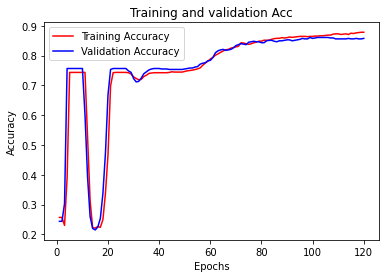

In [69]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training Accuracy', c='r')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy', c='b')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

/var/folders/q3/n1kzrjss3rlcf4h0671f29640000gn/T/ipykernel_35287/2382457563.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'b', label='Training Loss', c='r')
/var/folders/q3/n1kzrjss3rlcf4h0671f29640000gn/T/ipykernel_35287/2382457563.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b', label='Validation Loss', c='b')


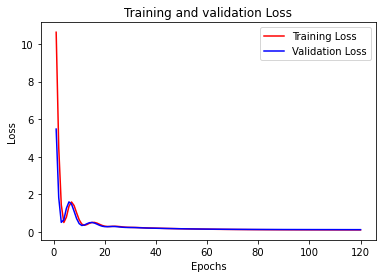

In [70]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, 'b', label='Training Loss', c='r')
plt.plot(epochs, val_loss, 'b', label='Validation Loss', c='b')
plt.title('Training and validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## KNN
For KNN, categorical attributes are removed, the best K is selected inside a range between the sqrt(n)-10 and sqrt(n)+10. 

In [34]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

In [35]:
train_set_no_cat = train_set.loc[:,~train_set.columns.str.contains('_num', case=False)] 
test_set_no_cat = test_set.loc[:,~test_set.columns.str.contains('_num', case=False)] 

k = math.sqrt(len(train_set))
k = round(k, 0)
k = int(k)
k = k - 10
k_range = []
for i in range(0,20):
    k_range.append(k)
    k = k + 1

In [36]:
knn_param_grid = {
    'n_neighbors': k_range,
    'metric': ['euclidean', 'manhattan'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'weights': ['uniform', 'distance']
            }

knn_grid = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=8, scoring=make_scorer(f1_score))

In [37]:
knn_grid.fit(train_set_no_cat, train_label)

GridSearchCV(cv=8, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
                                         39, 40, 41, 42, 43, 44, 45, 46, 47,
                                         48],
                         'weights': ['uniform', 'distance']},
             scoring=make_scorer(f1_score))

In [38]:
train_pred_knn = knn_grid.predict(train_set_no_cat)
test_pred_knn = knn_grid.predict(test_set_no_cat)

### Evaluation

TRAINING:
               precision    recall  f1-score   support

  high-level       1.00      1.00      1.00       392
   low-level       1.00      1.00      1.00      1167

    accuracy                           1.00      1559
   macro avg       1.00      1.00      1.00      1559
weighted avg       1.00      1.00      1.00      1559

TEST:
               precision    recall  f1-score   support

  high-level       0.87      0.83      0.85       131
   low-level       0.94      0.96      0.95       389

    accuracy                           0.93       520
   macro avg       0.91      0.90      0.90       520
weighted avg       0.93      0.93      0.93       520



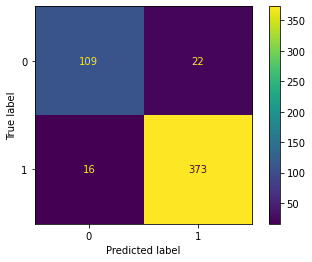

In [39]:
print_all(knn_grid,train_set_no_cat,train_pred_knn,test_set_no_cat,test_pred_knn,roc="None")

## Radius-Neighbors Classifier 

In [40]:
from sklearn.neighbors import RadiusNeighborsClassifier
from scipy.stats import uniform
#radius = np.arange(1.0, 100000.0, 0.1)
radius = uniform(1.0, 10000000.0)
radius_param_grid = {
    'radius': radius,
    'metric': ['euclidean', 'manhattan'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'weights': ['uniform', 'distance']
            }

In [41]:
radius_grid = RandomizedSearchCV(RadiusNeighborsClassifier(), radius_param_grid, n_jobs=-1, n_iter = 100, cv=8, scoring='accuracy')

radius_grid.fit(train_set_no_cat, train_label)

print('Accuracy: ' + str(radius_grid.best_score_))
print('Parameters: ' + str(radius_grid.best_params_))

Accuracy: 0.7710084588950568
Parameters: {'algorithm': 'ball_tree', 'metric': 'euclidean', 'radius': 9650558.799499594, 'weights': 'distance'}


In [42]:
radius = RadiusNeighborsClassifier(**radius_grid.best_params_).fit(train_set_no_cat, train_label)

In [43]:
train_pred_radius = radius.predict(train_set_no_cat)

In [44]:
test_pred_radius = radius.predict(test_set_no_cat)

### Evaluation

TRAINING:
               precision    recall  f1-score   support

  high-level       1.00      1.00      1.00       392
   low-level       1.00      1.00      1.00      1167

    accuracy                           1.00      1559
   macro avg       1.00      1.00      1.00      1559
weighted avg       1.00      1.00      1.00      1559

TEST:
               precision    recall  f1-score   support

  high-level       0.94      0.13      0.23       131
   low-level       0.77      1.00      0.87       389

    accuracy                           0.78       520
   macro avg       0.86      0.56      0.55       520
weighted avg       0.82      0.78      0.71       520



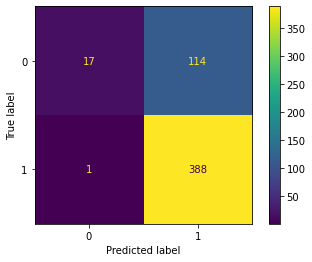

In [45]:
print_all(radius,train_set_no_cat,train_pred_radius,test_set_no_cat,test_pred_radius,roc="None")

## SVM

In [46]:
from sklearn.svm import SVC

In [47]:
svm_param_grid = {
    'C' : [0.5, 2.0],
    'kernel' : ['rbf', 'linear'] 
    }
svm_grid = GridSearchCV(SVC(probability=True), svm_param_grid, n_jobs=-1, cv=8, scoring=make_scorer(f1_score))

In [48]:
svm_grid.fit(train_set, train_label)

GridSearchCV(cv=8, estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [0.5, 2.0], 'kernel': ['rbf', 'linear']},
             scoring=make_scorer(f1_score))

In [49]:
train_pred_svm = svm_grid.predict(train_set)
test_pred_svm = svm_grid.predict(test_set)

### Evaluation

TRAINING:
               precision    recall  f1-score   support

  high-level       0.90      0.86      0.88       392
   low-level       0.95      0.97      0.96      1167

    accuracy                           0.94      1559
   macro avg       0.93      0.91      0.92      1559
weighted avg       0.94      0.94      0.94      1559

TEST:
               precision    recall  f1-score   support

  high-level       0.88      0.91      0.89       131
   low-level       0.97      0.96      0.96       389

    accuracy                           0.95       520
   macro avg       0.93      0.93      0.93       520
weighted avg       0.95      0.95      0.95       520



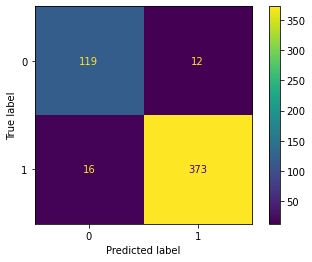

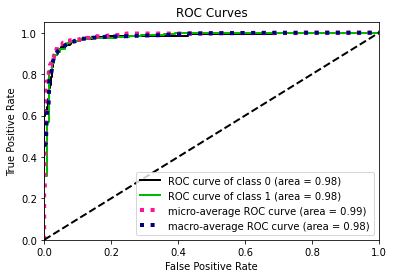

In [50]:
print_all(svm_grid,train_set,train_pred_svm,test_set,test_pred_svm)

## Rule Based Classifier

In [51]:
import wittgenstein as lw
param_grid = {
    "prune_size": [0.1, 0.2, 0.5, 0.6], 
    "k": [1, 3, 7, 10]
}
rb_grid = GridSearchCV(lw.RIPPER(), param_grid=param_grid, n_jobs=10)

In [52]:
rb_grid.fit(train_set, train_label)

GridSearchCV(estimator=<RIPPER(verbosity=0, random_state=None, prune_size=0.33, max_total_conds=None, k=2, max_rules=None, dl_allowance=64, max_rule_conds=None, n_discretize_bins=10)>,
             n_jobs=10,
             param_grid={'k': [1, 3, 7, 10],
                         'prune_size': [0.1, 0.2, 0.5, 0.6]})

In [53]:
rb = rb_grid.best_estimator_
rb.out_model()

[[hand_num=2 ^ gender_num=1] V
[ratio_2020-2021=<23.08 ^ num_matches=<18.0 ^ gender_num=1] V
[hand_num=2 ^ perc_v_df=<3.62] V
[ratio_2020-2021=<23.08 ^ num_matches=29.0-50.0 ^ hand_num=1] V
[perc_v_1stwon=23.25-33.09] V
[perc_v_1stwon=33.09-44.14] V
[perc_v_1stwon=<23.25] V
[ratio_2020-2021=<23.08 ^ num_matches=18.0-29.0 ^ gender_num=1] V
[num_matches=50.0-71.0 ^ _1stwon_1stIn=65.96-67.85] V
[birth=>2000.0] V
[ratio=31.95-40.0 ^ ratio_2020-2021=23.08-37.5] V
[gender_num=1 ^ ratio=40.0-44.0] V
[num_matches=29.0-50.0] V
[birth=1997.0-1998.0 ^ perc_ace=10.86-14.18] V
[ht=185.0-187.08 ^ num_matches_2020-2021=<1.0] V
[perc_v_1stwon=44.14-54.04 ^ perc_v_df=6.25-6.61] V
[num_matches=18.0-29.0] V
[num_matches=50.0-71.0 ^ gender_num=1] V
[num_matches=71.0-103.0 ^ perc_df=6.21-6.97] V
[num_matches=71.0-103.0 ^ birth=1987.0-1990.0] V
[hand_num=2]]


In [54]:
train_pred_rb = rb_grid.predict(train_set)
test_pred_rb = rb_grid.predict(test_set)

### Evaluation

TRAINING:
               precision    recall  f1-score   support

  high-level       0.70      0.93      0.80       392
   low-level       0.97      0.87      0.92      1167

    accuracy                           0.88      1559
   macro avg       0.84      0.90      0.86      1559
weighted avg       0.90      0.88      0.89      1559

TEST:
               precision    recall  f1-score   support

  high-level       0.69      0.91      0.79       131
   low-level       0.97      0.86      0.91       389

    accuracy                           0.88       520
   macro avg       0.83      0.89      0.85       520
weighted avg       0.90      0.88      0.88       520



base.py: .predict_proba: RuntimeWarning: 
Some examples lacked any rule with sufficient sample size to predict_proba: [20, 45, 106, 115, 144, 145, 157, 177, 183, 192, 217, 229, 236, 240, 241, 242, 249, 258, 262, 281, 297, 314, 316, 320, 322, 332, 335, 338, 345, 358, 364, 365, 366, 377, 415, 421, 431, 437, 443, 469, 474, 494, 497, 498, 504, 514, 517, 519]
 Consider running recalibrate_proba with smaller param min_samples, or set require_min_samples=False



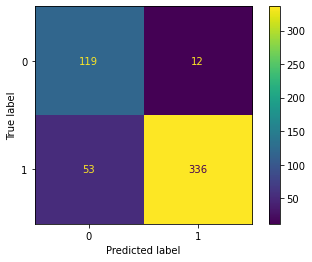

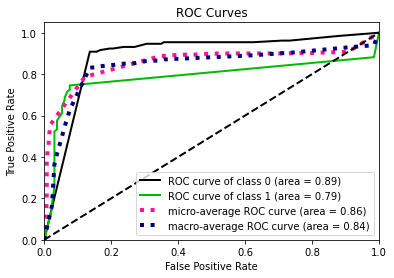

In [55]:
print_all(rb_grid,train_set,train_pred_rb,test_set,test_pred_rb)

## Random Forest Classifier

In [56]:
from sklearn.ensemble import RandomForestClassifier

In [57]:
param_dist = {"max_depth": [2,3,5,6,7,10,12,None],
              "max_features": sp_randint(1, len(train_set.iloc[0]) + 1),
              "min_samples_split": sp_randint(10, 51),
              "min_samples_leaf": sp_randint(10, 51),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"],
              "class_weight":['balanced', None, {0: 0.65, 1: 0.35}]}

rf_grid = RandomizedSearchCV(RandomForestClassifier(n_estimators=30), param_distributions=param_dist, 
                            n_iter=50, 
                            n_jobs=-1, 
                            scoring=make_scorer(accuracy_score))


In [58]:
rf_grid.fit(train_set, train_label)

RandomizedSearchCV(estimator=RandomForestClassifier(n_estimators=30), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced', None,
                                                         {0: 0.65, 1: 0.35}],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [2, 3, 5, 6, 7, 10, 12,
                                                      None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x177843a00>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x28e071190>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x177ca0df0>},
                   scoring=make_scorer(accuracy_score))

In [59]:
train_pred_rf = rf_grid.predict(train_set)
test_pred_rf = rf_grid.predict(test_set)

### Evaluation

TRAINING:
               precision    recall  f1-score   support

  high-level       0.89      0.94      0.91       392
   low-level       0.98      0.96      0.97      1167

    accuracy                           0.96      1559
   macro avg       0.93      0.95      0.94      1559
weighted avg       0.96      0.96      0.96      1559

TEST:
               precision    recall  f1-score   support

  high-level       0.81      0.90      0.85       131
   low-level       0.97      0.93      0.95       389

    accuracy                           0.92       520
   macro avg       0.89      0.91      0.90       520
weighted avg       0.93      0.92      0.92       520



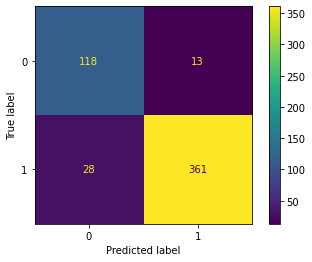

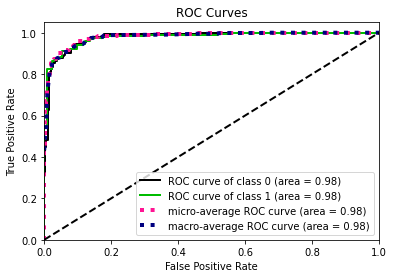

In [60]:
print_all(rf_grid,train_set,train_pred_rf,test_set,test_pred_rf)

## AdaBoosting

In [61]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier()
abc.fit(train_set, train_label)

AdaBoostClassifier()

In [62]:
test_pred_abc = abc.predict(test_set)
train_pred_abc= abc.predict(train_set)

TRAINING:
               precision    recall  f1-score   support

  high-level       0.92      0.93      0.93       392
   low-level       0.98      0.97      0.97      1167

    accuracy                           0.96      1559
   macro avg       0.95      0.95      0.95      1559
weighted avg       0.96      0.96      0.96      1559

TEST:
               precision    recall  f1-score   support

  high-level       0.85      0.85      0.85       131
   low-level       0.95      0.95      0.95       389

    accuracy                           0.93       520
   macro avg       0.90      0.90      0.90       520
weighted avg       0.93      0.93      0.93       520



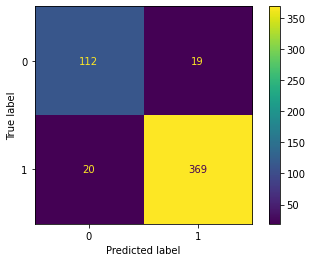

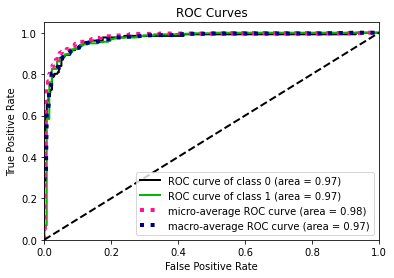

In [63]:
print_all(abc,train_set,train_pred_abc,test_set,test_pred_abc)

## Global models evaluation

The labels of players without a rank are estimated using all models and check the result obtained

In [72]:
blind_drop = train_set.loc[:,~blindtest.columns.str.contains('_num', case=False)] 

In [73]:
df_blind_test = pd.DataFrame()
df_blind_test['DecisionTree'] = pd.Series(dt_grid.predict(blindtest))
df_blind_test['Bayesian'] = pd.Series(gnb.predict(blindtest))
#df_blind_test['NeuralNetwork'] = pd.Series(nn_grid.predict(blindtest))
df_blind_test['KNN'] = pd.Series(knn_grid.predict(blind_drop))
df_blind_test['Radius-KNN'] = pd.Series(radius_grid.predict(blind_drop))
df_blind_test['SVM'] = pd.Series(svm_grid.predict(blindtest))
df_blind_test['RuleBased'] = pd.Series(rb_grid.predict(blindtest))
df_blind_test['RandomForest'] = pd.Series(rf_grid.predict(blindtest))
df_blind_test['AdaBoosting'] = pd.Series(abc.predict(blindtest))
df_blind_test

DecisionTree  Bayesian  KNN  Radius-KNN  SVM  RuleBased  RandomForest  \
0              1         1    0           0    1       True             1   
1              1         1    1           1    1       True             1   
2              1         1    1           1    1       True             1   
3              1         1    0           0    1       True             1   
4              1         1    1           1    1       True             1   
5              1         1    1           1    1       True             1   
6              1         1    1           1    1       True             1   
7              1         1    1           1    1       True             1   
8              1         1    1           1    1       True             1   
9              1         1    0           0    1       True             1   
10             1         1    0           0    1       True             1   
11             1         1    1           1    1       True             1   
12             1         1    1           1    1       True             1   
13             1         1    1           1    1       True             1   
14             1         1    1           1    1       True             1   
15             1         1    1           1    1       True             1   
16             1         1    1           1    1       True             1   
17             1         1    1           1    1       True             1   
18             1         1    1           1    1       True             1   
19             1         1    1           1    1       True             1   
20             1         1    0           0    1       True             1   
21             1         1    1           1    1       True             1   
22             1         1    1           1    1       True             1   
23             1         1    1           1    1       True             1   
24             1         1    1           1    1       True             1   
25             1         1    0           0    1       True             1   
26             1         1    1           1    1       True             1   
27             1         1    1           1    1       True             1   
28             1         1    1           1    1       True             1   
29             1         1    1           1    1       True             1   
30             1         1    0           0    1       True             1   
31             1         1    1           1    1       True             1   
32             1         1    0           0    1       True             1   
33             1         1    1           1    1       True             1   
34             1         1    0           0    1       True             1   
35             1         1    1           1    1       True             1   
36             1         1    0           0    1       True             1   
37             1         1    1           1    1       True             1   
38             1         1    0           0    1       True             1   
39             1         1    0           0    1       True             1   
40             1         1    0           0    1       True             1   

    AdaBoosting  
0             1  
1             1  
2             1  
3             1  
4             1  
5             1  
6             1  
7             1  
8             1  
9             1  
10            1  
11            1  
12            1  
13            1  
14            1  
15            1  
16            1  
17            1  
18            1  
19            1  
20            1  
21            1  
22            1  
23            1  
24            1  
25            1  
26            1  
27            1  
28            1  
29            1  
30            1  
31            1  
32            1  
33            1  
34            1  
35            1  
36            1  
37            1  
38            1  
39            1  
40            1

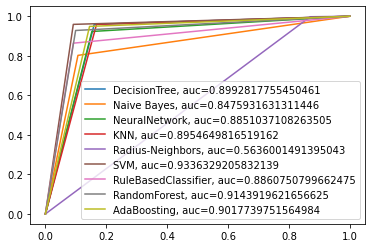

In [71]:

#decision tree 
fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_dt)
auc = metrics.roc_auc_score(test_label, test_pred_dt)
plt.plot(fpr,tpr,label="DecisionTree, auc="+str(auc))

#bayesian classifier
fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_gnb)
auc = metrics.roc_auc_score(test_label, test_pred_gnb)
plt.plot(fpr,tpr,label="Naive Bayes, auc="+str(auc))

#neural network
fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_nn)
auc = metrics.roc_auc_score(test_label, test_pred_nn)
plt.plot(fpr,tpr,label="NeuralNetwork, auc="+str(auc))

#KNN
fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_knn)
auc = metrics.roc_auc_score(test_label, test_pred_knn)
plt.plot(fpr,tpr,label="KNN, auc="+str(auc))

#Radius-Neighbors
fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_radius)
auc = metrics.roc_auc_score(test_label, test_pred_radius)
plt.plot(fpr,tpr,label="Radius-Neighbors, auc="+str(auc))

#SVM
fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_svm)
auc = metrics.roc_auc_score(test_label, test_pred_svm)
plt.plot(fpr,tpr,label="SVM, auc="+str(auc))

#Rule Based Classifier
fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_rb)
auc = metrics.roc_auc_score(test_label, test_pred_rb)
plt.plot(fpr,tpr,label="RuleBasedClassifier, auc="+str(auc))

#RandomForest
fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_rf)
auc = metrics.roc_auc_score(test_label, test_pred_rf)
plt.plot(fpr,tpr,label="RandomForest, auc="+str(auc))

#AdaBoosting
fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_abc)
auc = metrics.roc_auc_score(test_label, test_pred_abc)
plt.plot(fpr,tpr,label="AdaBoosting, auc="+str(auc))

plt.legend(loc=0)